In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, linregress, t
from scipy.signal import argrelextrema

from sklearn.metrics import r2_score

from ase import units

mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='same')

def moving_std(data, window_size):
    """Calculates moving standard deviation with padding."""
    windows = np.lib.stride_tricks.sliding_window_view(data, window_size)
    std_dev = np.std(windows, axis=1)
    padding = np.full(window_size - 1, np.nan)
    padded_std = np.concatenate([padding, std_dev])
    return padded_std

def apply_kwargs(ax, x, y, kwargs):
    if kwargs is None:
        ax.plot(x, y)
    else:
        ax.plot(x, y, **kwargs)

def confidence_interval(x, res):
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    slope_confidence = ts * res.stderr
    intercept_confidence = ts * res.intercept_stderr
    return slope_confidence, intercept_confidence


def linregress_with_ci(x, y):
    res = linregress(x, y)
    slope = res.slope
    intercept = res.intercept
    r2 = res.rvalue**2
    slope_ci, intercept_ci = confidence_interval(x, res)
    return slope, intercept, r2, slope_ci, intercept_ci

def unit_vector(vector):
    return vector / np.linalg.norm(vector) 

def angle_between_vectors(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    value = np.arccos(np.clip(np.dot(v1_u, v2_u), -1, 1))
    if np.isnan(value):
        return -1
    else:
        return value


def label_mosaic_subplot(axs, outside = False):
    for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        if outside:
           ax.annotate(
                label,
                xy=(-0.1, 1.12), xycoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='center',
                #xytext=(-0.5, +0.5), textcoords='offset fontsize',
                #verticalalignment='top', # fontsize='medium', fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                ) 
        else:
            ax.annotate(
                label,
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                 verticalalignment='top', 
                # fontsize='medium',
                #fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                )

def set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))



def save_figure(fig, prefix):
    for suffix in ['eps', 'pdf', 'png', 'tiff']:
        fig.savefig(f'{suffix}/{prefix}.{suffix}')

In [4]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=1

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=1


# Parity

Calculating Angle Error...
Generating plots...


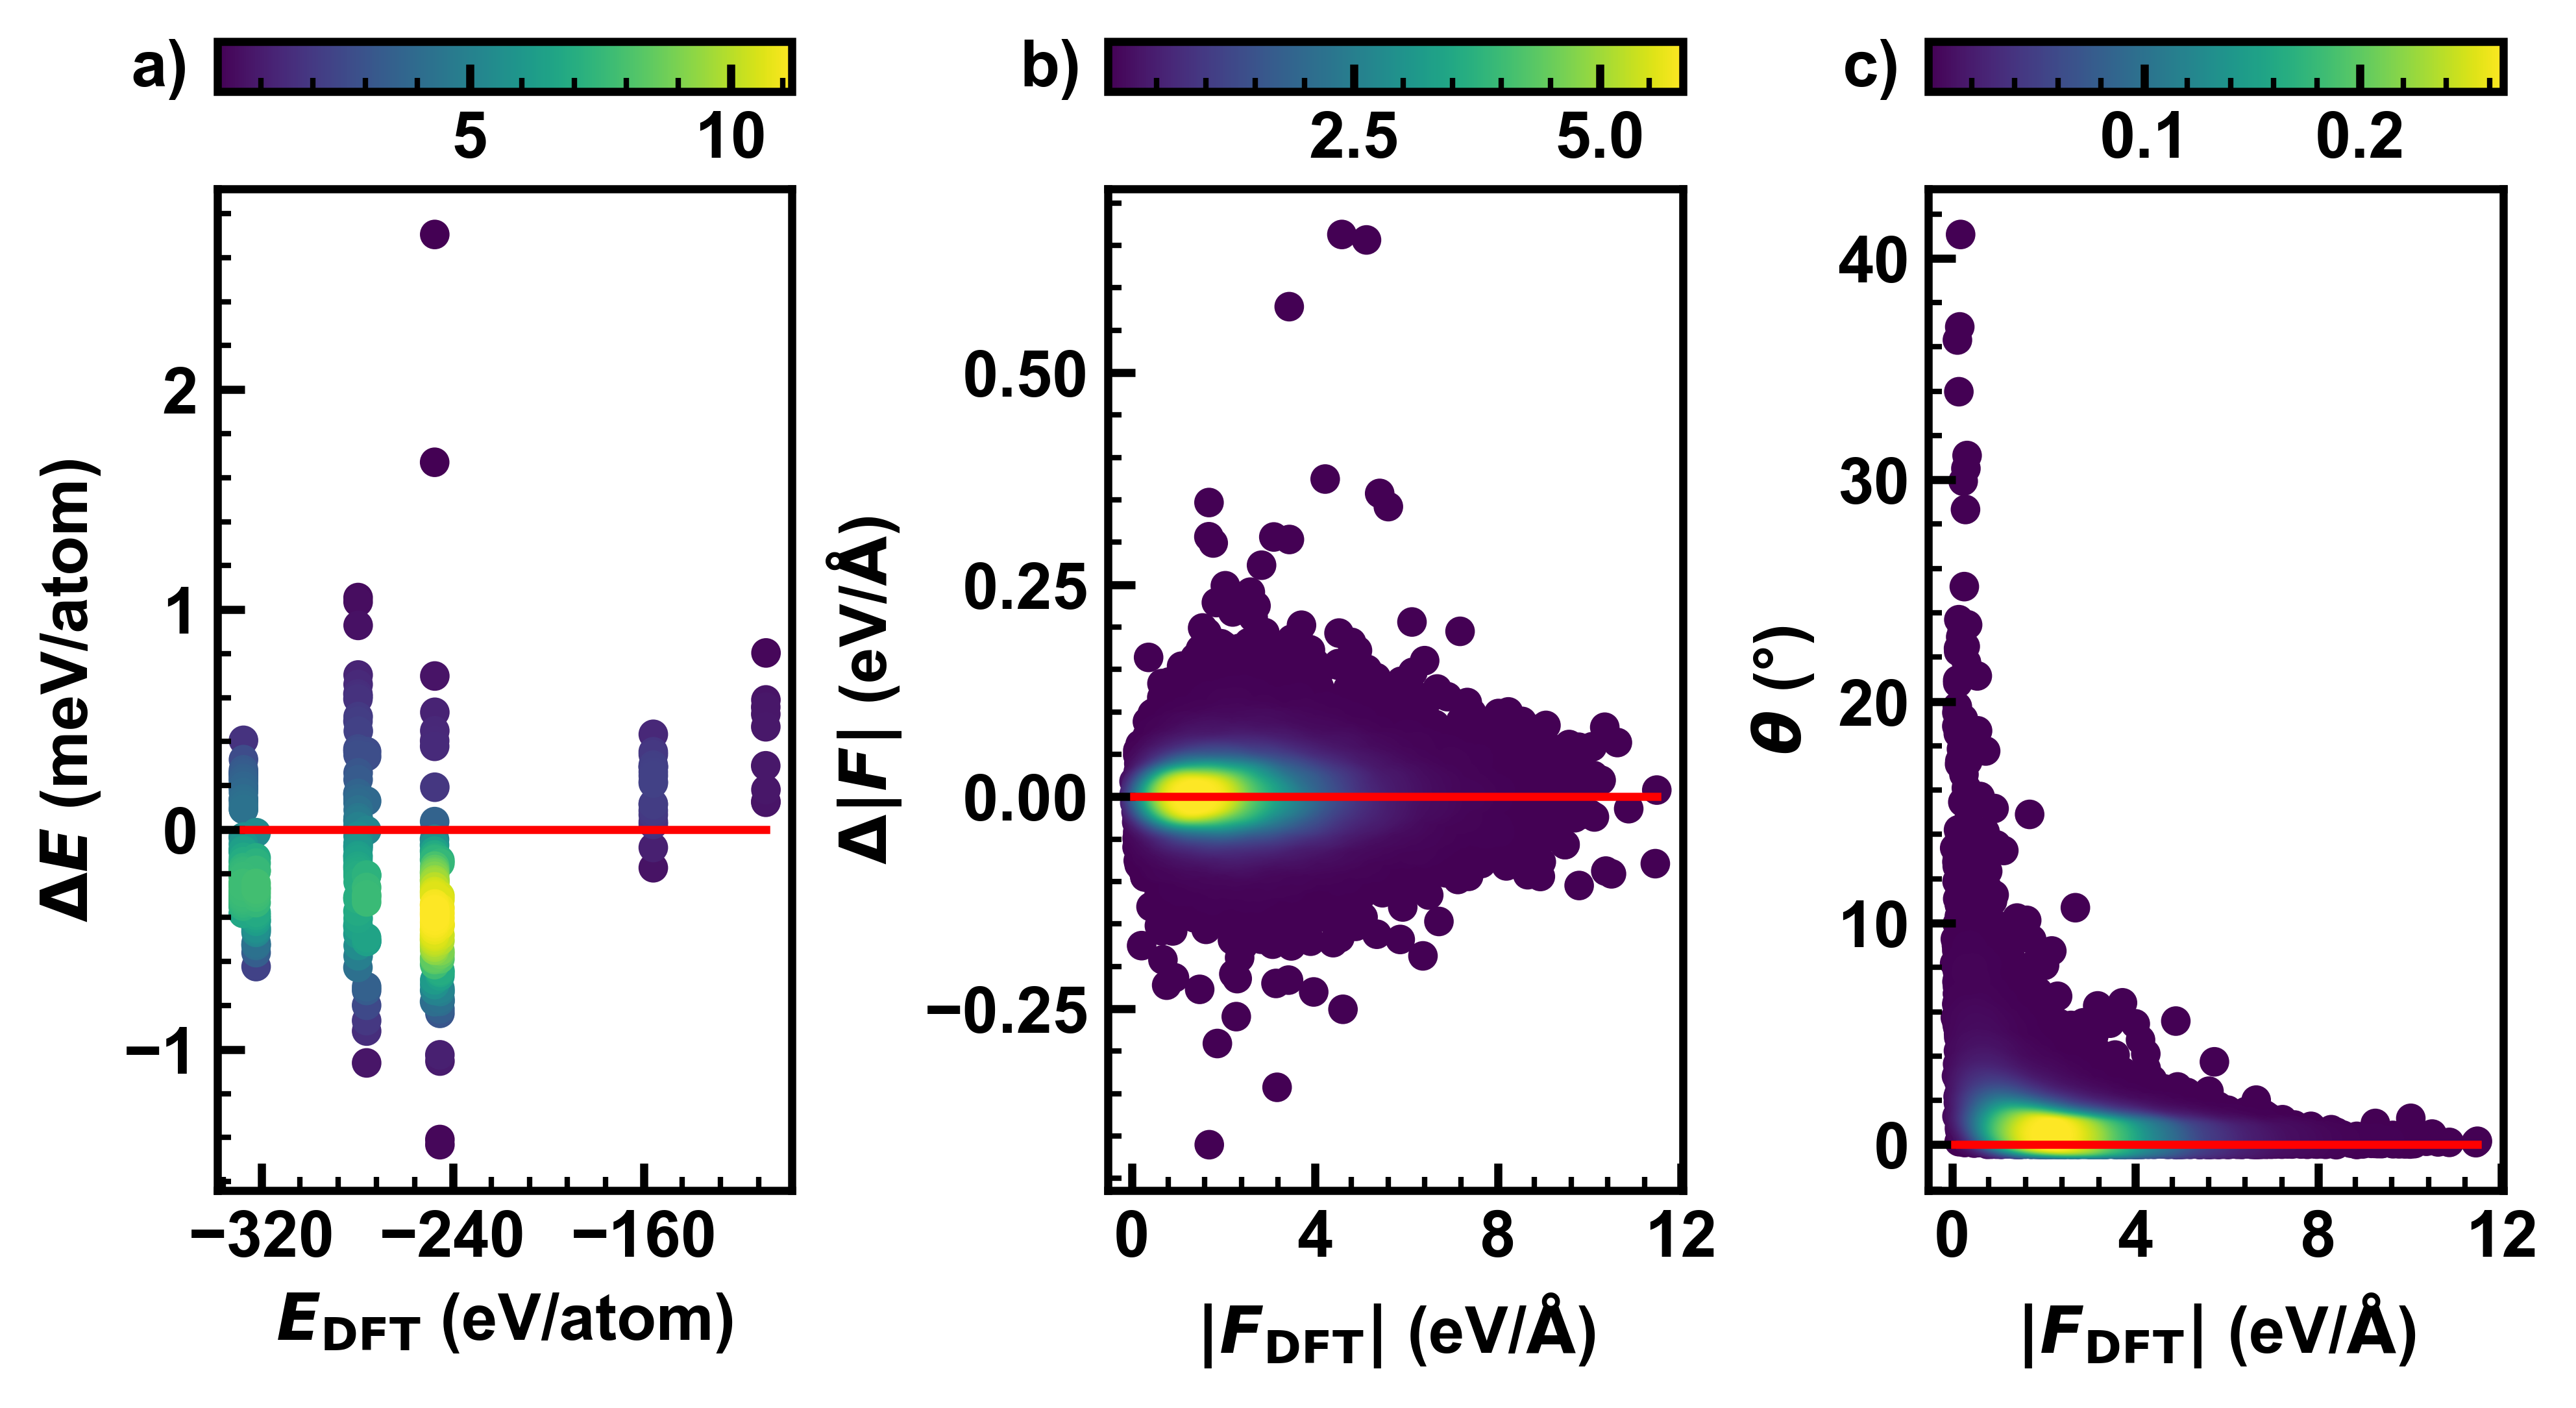

In [4]:

def plot_distribution(ax, x, y, z, square=False, hexbin=False, colorbarlims = None):
    
    #print("Stacking Vectors...")
    #xy = np.vstack([x, y])
    #print("Fitting PDF with Gaussian KDE...")
    #KDE = gaussian_kde(xy)
    #print("Estimating PDF on datapoints...")
    #z = KDE(xy)
    
    idx = z.argsort()
    if hexbin:
        mappable = plt.hexbin(x, y, gridsize=30, bins="log", cmap="plasma")
    else:
        mappable = ax.scatter(x[idx], y[idx], c=z[idx], s=20)

    pmin = min(np.min(x), np.min(y))
    pmax = max(np.max(x), np.max(y))
    if square:
        ax.plot((pmin, pmax), (pmin, pmax), color="red")
        pmin = min(np.min(x), np.min(y))
        pmax = max(np.max(x), np.max(y))
        ax.set_xticks(ax.get_yticks())
        
        #ax.set_xlim(pmin, pmax)
        #ax.set_ylim(pmin, pmax)
    
    else:
        ax.plot((np.min(x), np.max(x)), (0, 0), color="red")
        
        #ax.set_xlim(np.min(x), np.max(x))
        #ax.set_ylim(np.min(y), np.max(y))
        #ax.set_box_aspect(1)
    return mappable 



fig, axs = plt.subplots(
    nrows = 1, ncols = 3, 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )


energy_correlation = np.load("../../../training/sn-bea/mace/N2_v3_r5_l1_f128/energy_correlation.npy") 
kde_energy = np.load("../../../training/sn-bea/mace/N2_v3_r5_l1_f128/gkde-energy_residuals.npy")
dft_energy = energy_correlation[:,0]
nn_energy = energy_correlation[:,1] 

dft_force = np.load('../../../training/sn-bea/mace/N2_v3_r5_l1_f128/dft_forces.npy')
nn_force = np.load('../../../training/sn-bea/mace/N2_v3_r5_l1_f128/nn_forces.npy')
kde_force = np.load("../../../training/sn-bea/mace/N2_v3_r5_l1_f128/gkde-force_residuals.npy")
kde_angle = np.load("../../../training/sn-bea/mace/N2_v3_r5_l1_f128/gkde-force_angle.npy")

dft_force_mag = np.linalg.norm(dft_force, axis=1)
nn_force_mag = np.linalg.norm(nn_force, axis=1)

print("Calculating Angle Error...")
angle_error = np.zeros(dft_force_mag.shape)
for index in range(len(dft_force_mag)):
    angle_error[index] = angle_between_vectors(dft_force[index], nn_force[index]) / np.pi * 180 

print("Generating plots...")
mappable1 = plot_distribution(axs[0], dft_energy, (dft_energy - nn_energy)*1000.0, kde_energy, square=False, hexbin=False)
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable1, cax=cax1, orientation='horizontal')

mappable2 = plot_distribution(axs[1], dft_force_mag, dft_force_mag - nn_force_mag, kde_force, square=False, hexbin=False)
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable2, cax=cax2, orientation='horizontal')

mappable3 = plot_distribution(axs[2], dft_force_mag, angle_error, kde_angle, square=False, hexbin=False)
divider = make_axes_locatable(axs[2])
cax3 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable3, cax=cax3, orientation='horizontal')


set_ticks(axs[0], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
set_ticks(axs[1], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
set_ticks(axs[2], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)


#axs[0].set_xlabel("$-E_{\mathrm{DFT}}$ (meV/atom x 10$^5$)")
#axs[0].set_ylabel(r"$\Delta E $ (meV/atom)")
#axs[0].set_ylabel("$E_{DFT} - E_{MACE}$ (meV/atom)")

#axs[1].set_xlabel("$|F_{DFT}|$ \mathrm{\AA}$))")
#axs[1].set_ylabel("$F_{DFT} - F_{MACE}$ (eV/Å)")
axs[0].set_xlabel("$E_{\mathrm{DFT}}$ (eV/atom)")
axs[0].set_ylabel("$\Delta E $ (meV/atom)")
axs[1].set_xlabel("$|F_{\mathrm{DFT}}|$ (eV/$\mathrm{\AA}$)")
axs[1].set_ylabel("$\Delta |F|$ (eV/$\mathrm{\AA}$)")
axs[2].set_xlabel("$|F_{\mathrm{DFT}}|$ (eV/$\mathrm{\AA}$)")
axs[2].set_ylabel(r"$\theta$ (°)")

axs[0].text(
        -0.1, 1.12,
        f"a)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0].transAxes,
    )

axs[1].text(
        -0.1, 1.12,
        f"b)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[1].transAxes,
    )

axs[2].text(
        -0.1, 1.12,
        f"c)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[2].transAxes,
    )

save_figure(fig, "residuals")

pass

O $R^2$ = 0.99946200215602
Si $R^2$ = 0.999559355218017
H $R^2$ = 0.9996202096560403
C $R^2$ = 0.9997090454670622
Sn $R^2$ = 0.9980624332526754


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


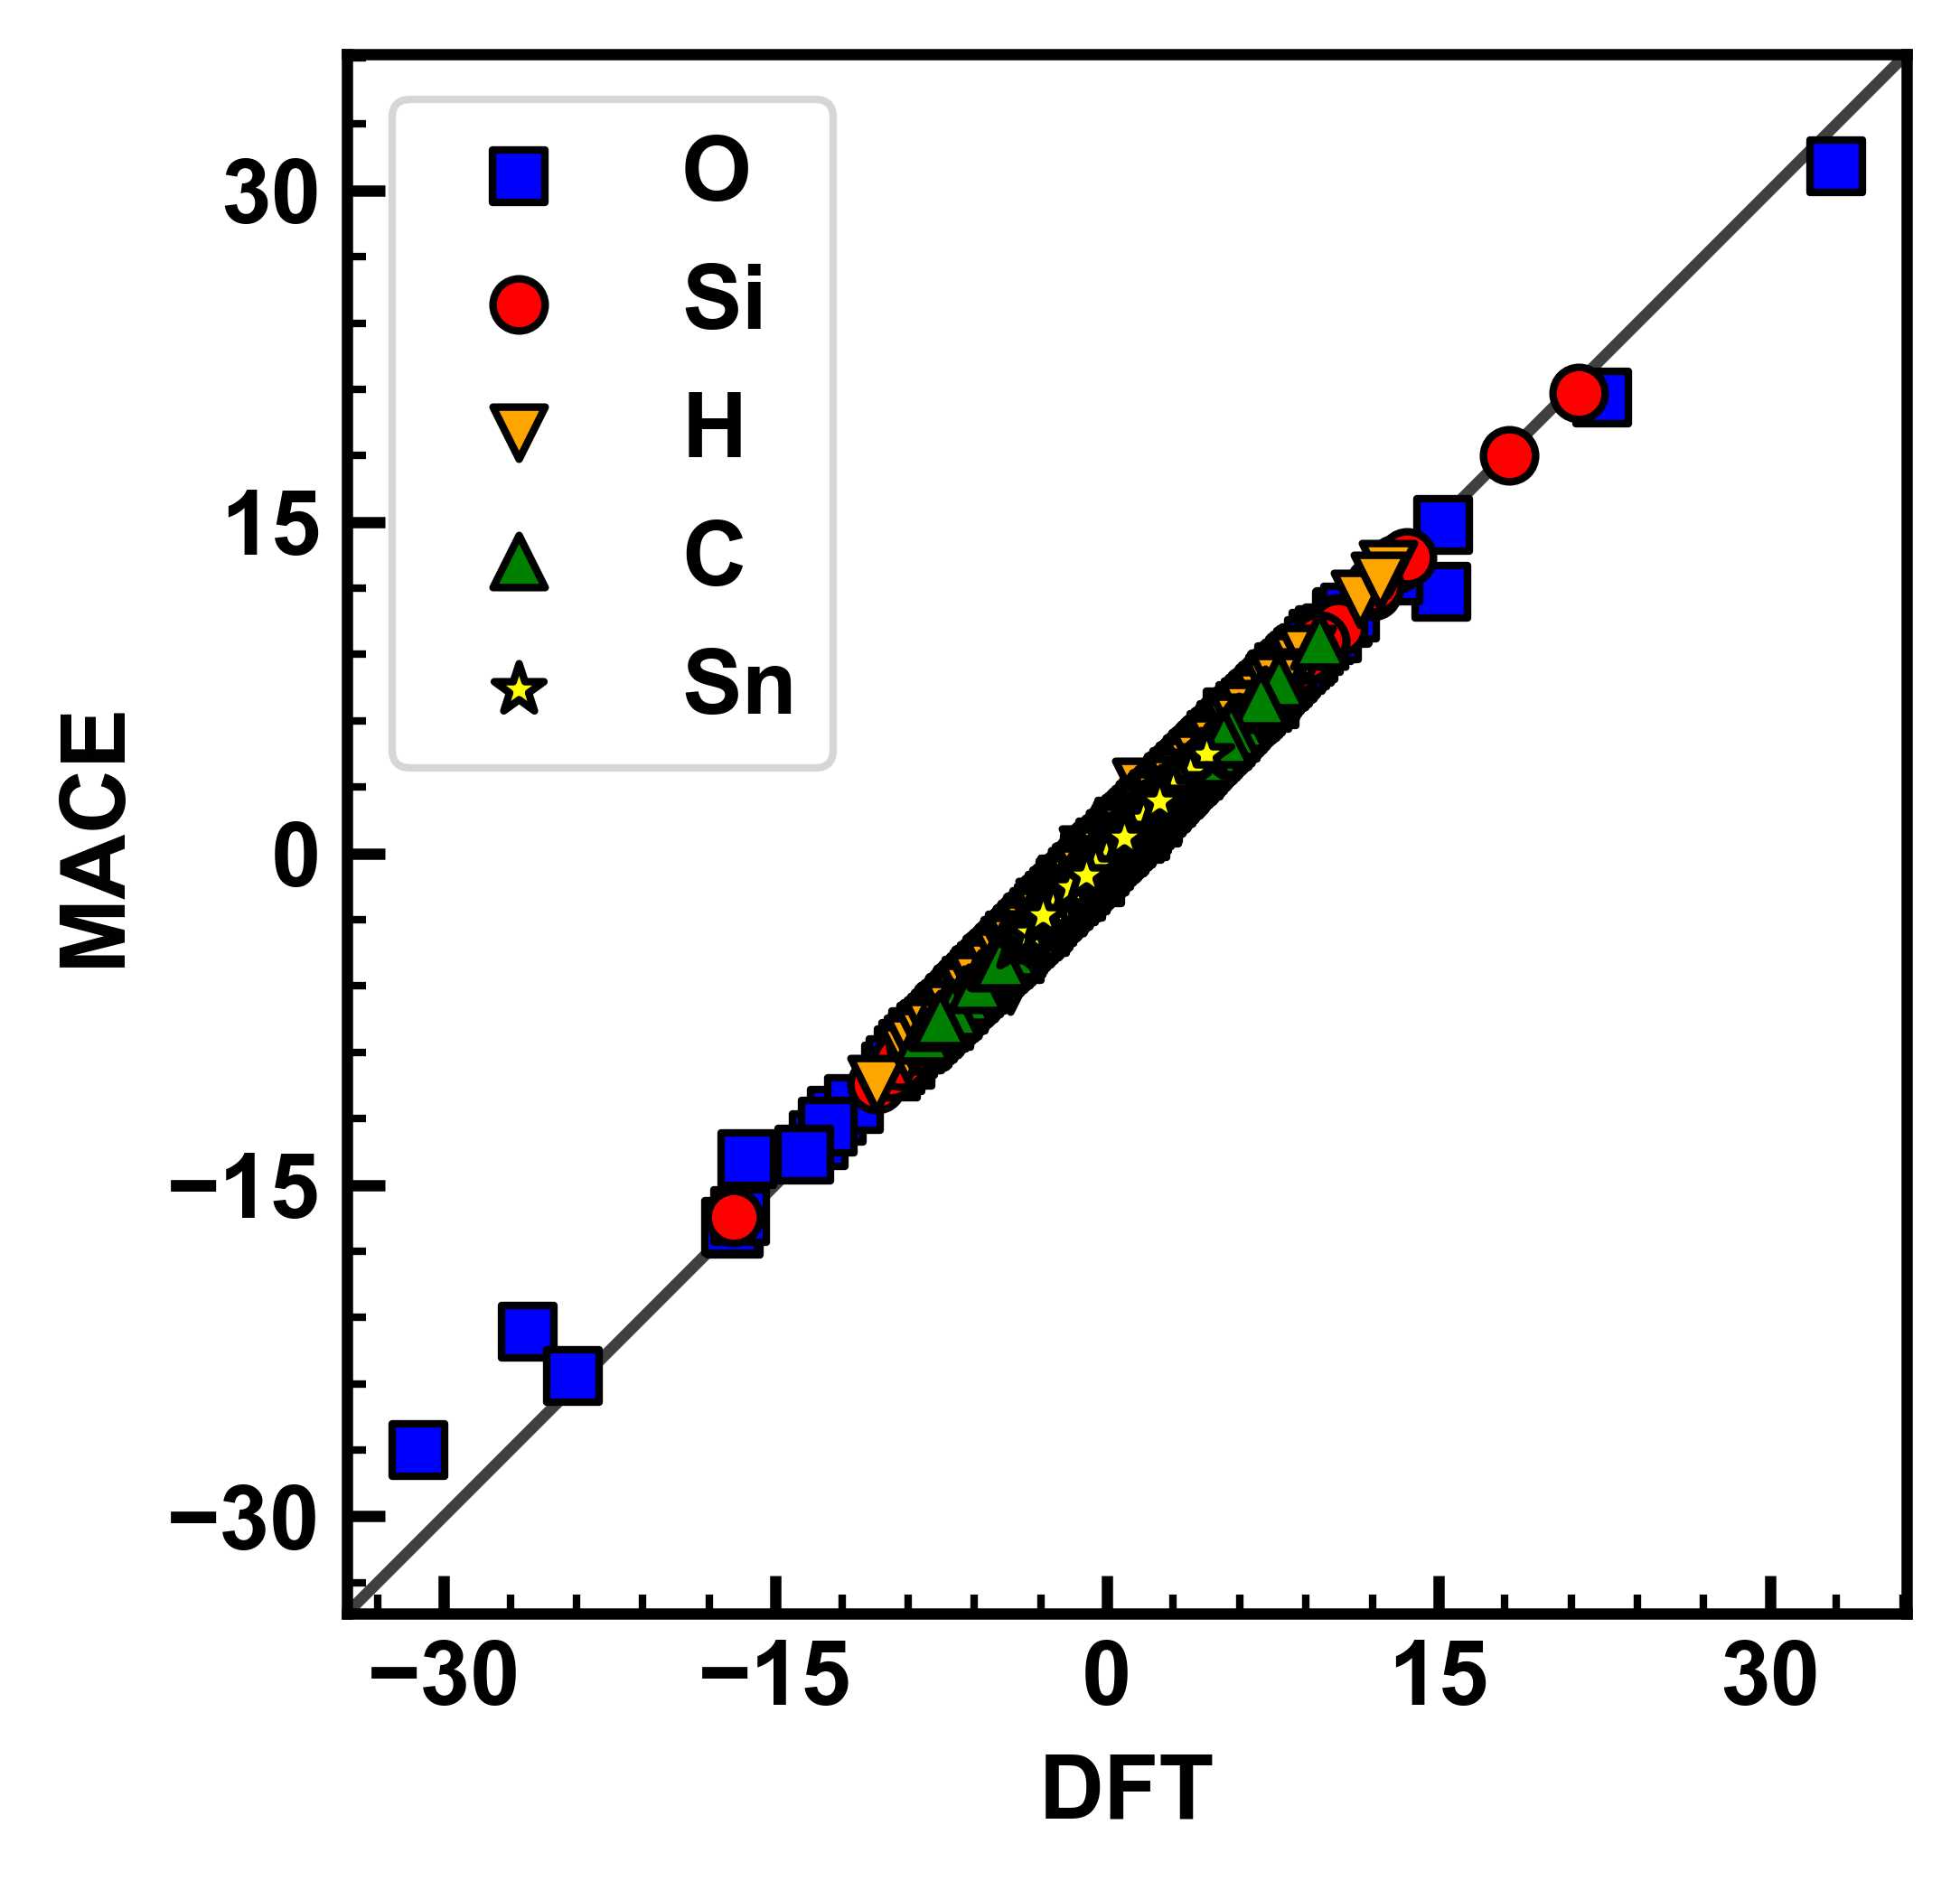

In [5]:
def plot_parity(directory, ax, aspect_equal = True, legend = True, labels = True, 
                symbols = { "O": ["s", "blue"],  "Si": ["o", "red"], "H": ["v", "orange"], "C": ["^", "green"], "Sn": ["*", "yellow"],}):

    force_correlation = {}
    for key, value in symbols.items():
        force_correlation[key] = np.load(f"{directory}/{key}_force_correlation.npy")

    for element, value in symbols.items():
        x = force_correlation[element][:,0]
        y = force_correlation[element][:,1]
                    
        if labels:
            ax.scatter(x,y, label = element, marker = value[0], c = value[1], s =48, edgecolors = 'k')

        else:
            ax.scatter(x,y, marker = value[0], c = value[1], s =48, edgecolors = 'k')

        R_square = r2_score(x, y) 
                
        print(f"{element} $R^2$ = {R_square}")

    if legend: ax.legend()

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]), 
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    if aspect_equal: ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)





fig, axs = plt.subplots(
    nrows = 1, ncols = 1, 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

plot_parity("../../../training/sn-bea/mace/N2_v3_r5_l1_f128", axs)

axs.set_ylabel("MACE")
axs.set_xlabel("DFT")

set_ticks(axs, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5)

save_figure(fig, "parity")

pass

# Active Learning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


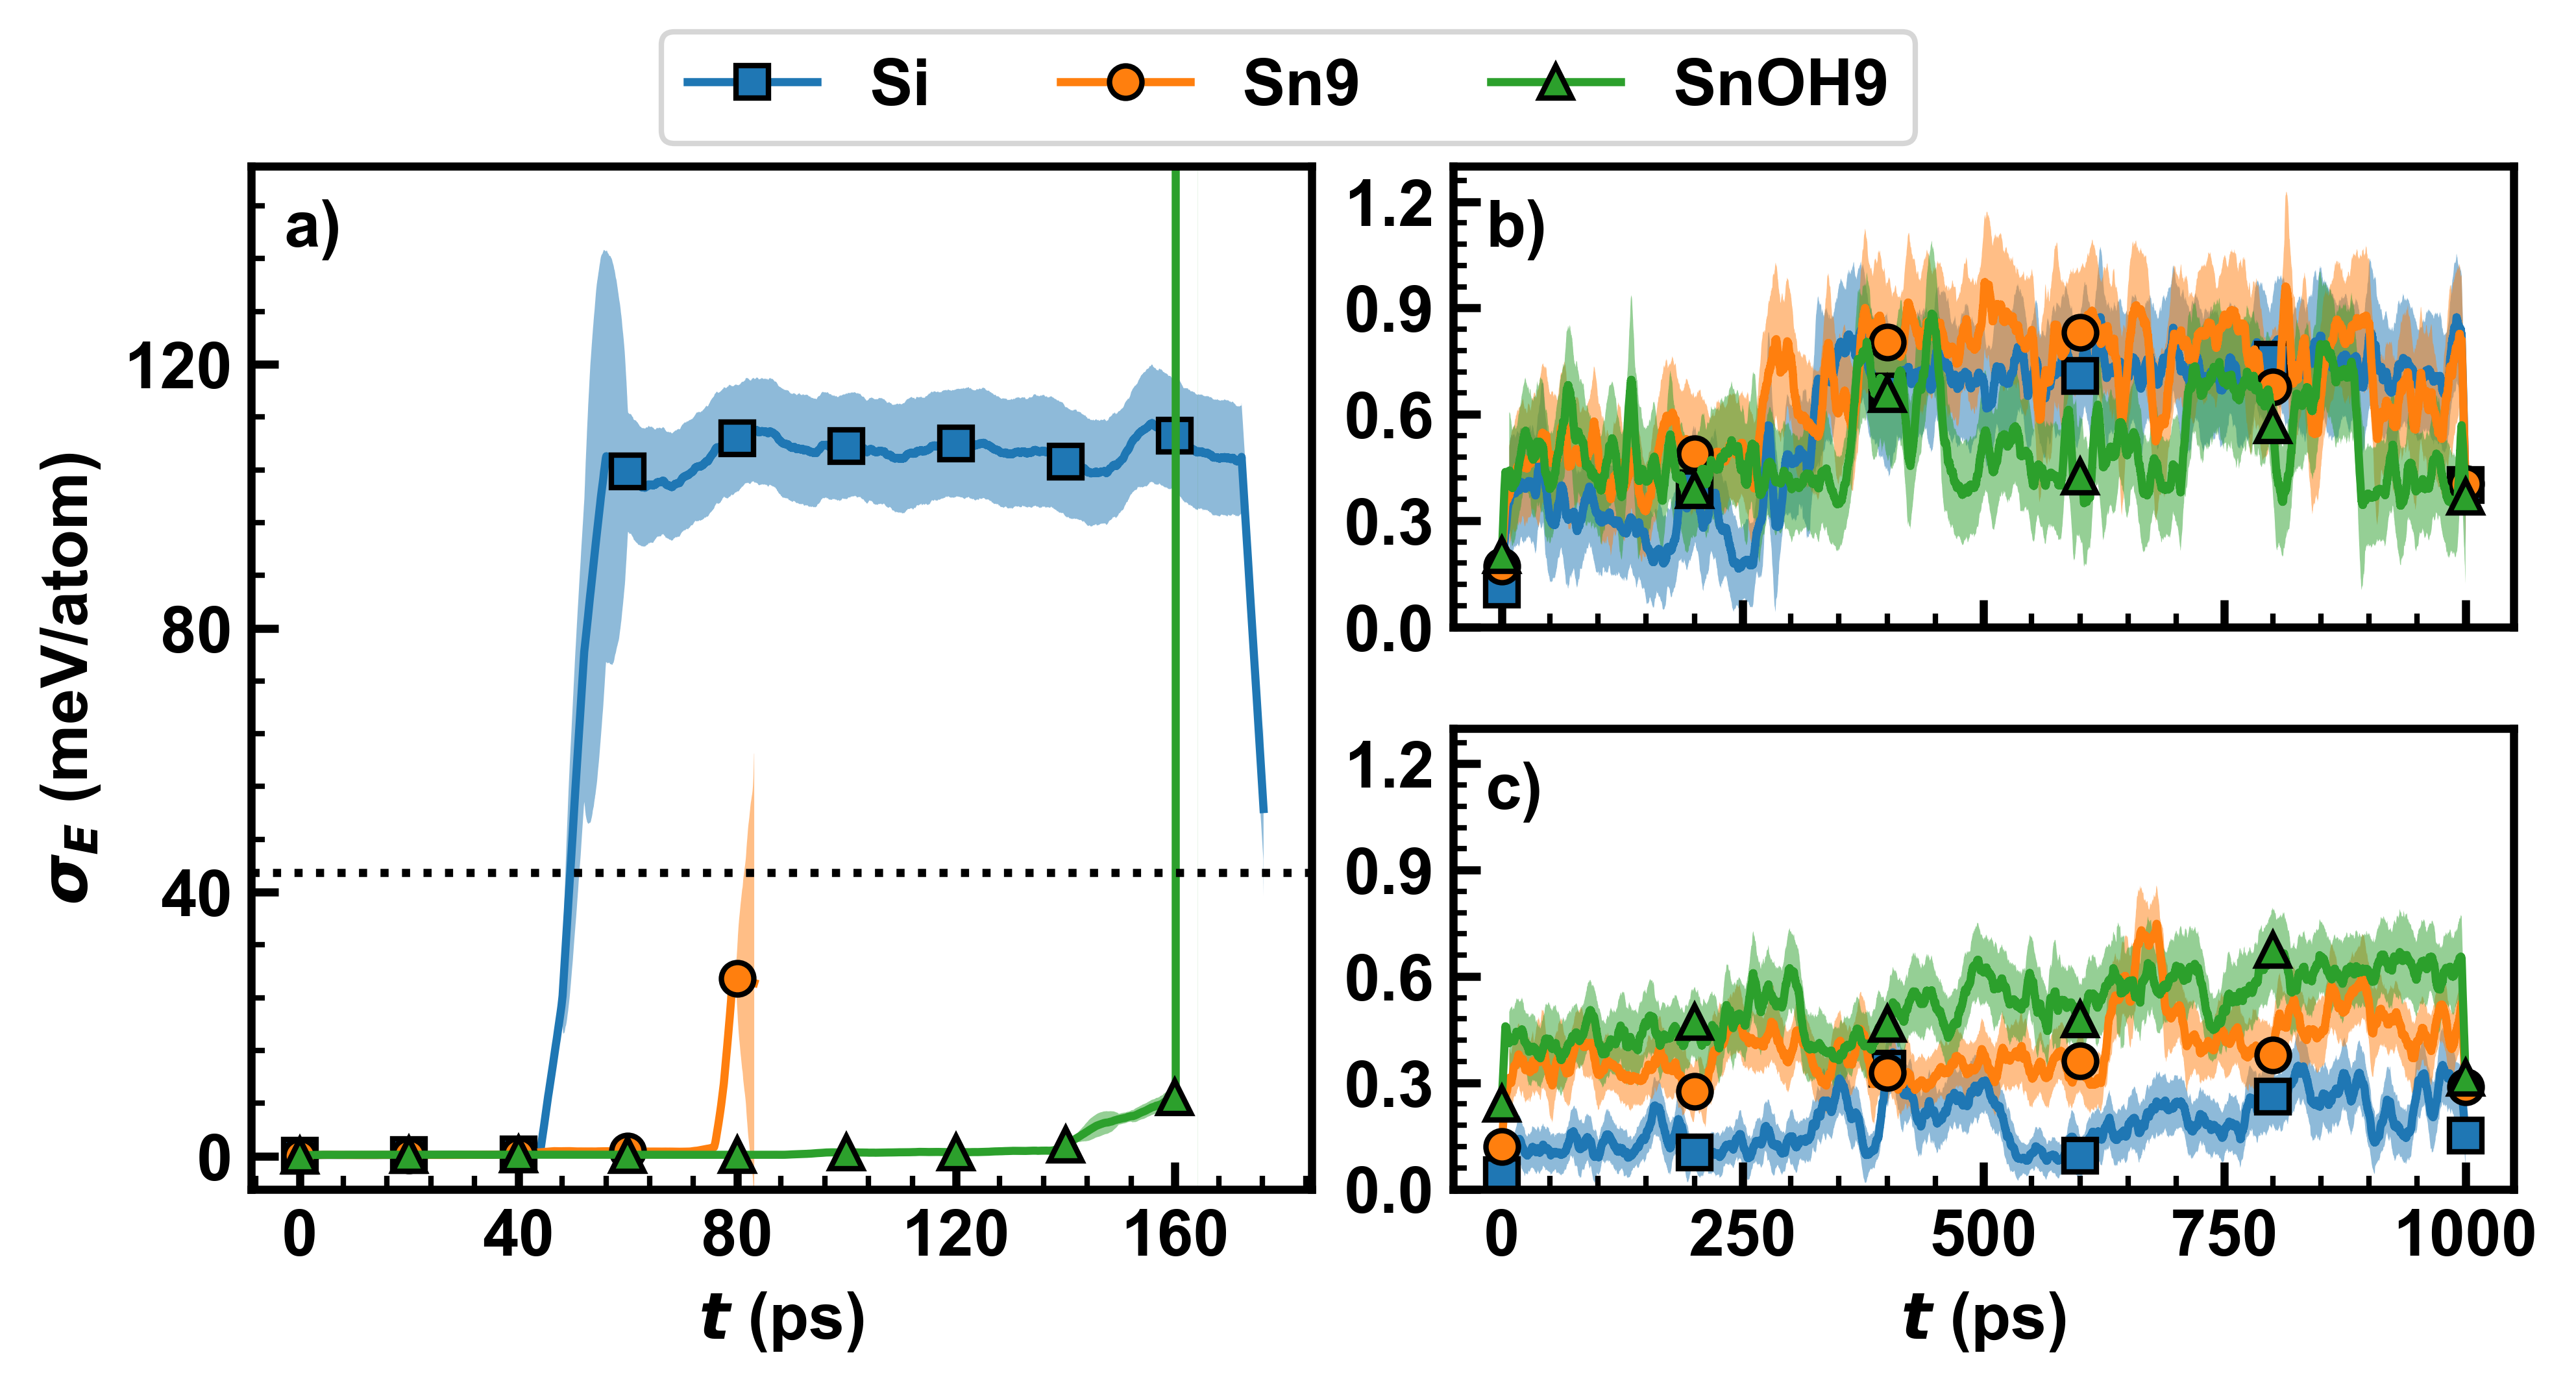

In [6]:
def plot_uncertainty(directory, ax, time_per_step = 0.004,  window = 2000, kwargs = None):
    variance = np.load(f"{directory}/uncertainty.npy")
    time = np.arange(len(variance)) * time_per_step

    std = np.sqrt(variance)
    std_mv = moving_average(std, window)
    std_ms = moving_std(std, window)
     
    apply_kwargs(ax, time, std_mv, kwargs)
    ax.fill_between(time, std_mv+std_ms, std_mv - std_ms, alpha = 0.5)


fig, axs = plt.subplot_mosaic(
    [["a)", "b)"], ["a)", "c)"]], 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

plot_uncertainty("../wat-39/pureSi/equilibrate/0_active_learning", axs["a)"], kwargs = {"label": "Si", "marker": "s", "markeredgecolor": "k", "markevery": 5000})
plot_uncertainty("../wat-39/t9/equilibrate/0_active_learning", axs["a)"], kwargs = {"label": "Sn9", "marker": "o", "markeredgecolor": "k", "markevery": 5000})
plot_uncertainty("../wat-39/st9/equilibrate/0_active_learning", axs["a)"], kwargs = {"label": "SnOH9", "marker": "^", "markeredgecolor": "k", "markevery": 5000})

plot_uncertainty("../wat-39/pureSi/equilibrate/1_active_learning", axs["b)"], kwargs = {"marker": "s", "markeredgecolor": "k", "markevery": 50000})
plot_uncertainty("../wat-39/t9/equilibrate/1_active_learning", axs["b)"], kwargs = {"marker": "o", "markeredgecolor": "k", "markevery": 50000})
plot_uncertainty("../wat-39/st9/equilibrate/1_active_learning", axs["b)"], kwargs = {"marker": "^", "markeredgecolor": "k", "markevery": 50000})

plot_uncertainty("../meoh-9/pureSi/equilibrate/1_active_learning", axs["c)"], kwargs = {"marker": "s", "markeredgecolor": "k", "markevery": 50000})
plot_uncertainty("../meoh-9/t9/equilibrate/1_active_learning", axs["c)"], kwargs = {"marker": "o", "markeredgecolor": "k", "markevery": 50000})
plot_uncertainty("../meoh-9/st9/equilibrate/1_active_learning", axs["c)"], kwargs = {"marker": "^", "markeredgecolor": "k", "markevery": 50000})


axs["a)"].set_ylim((-5, 150))
axs["b)"].set_ylim((0, 1.3))
axs["c)"].set_ylim((0, 1.3))

plim = axs["a)"].get_xlim()

axs["a)"].hlines(y=43, xmin = plim[0] , xmax =  plim[1], linestyles="dotted", color="k")
axs["a)"].set_xlim(plim)

axs["a)"].set_ylabel(r"$\sigma_E$ (meV/atom)")
axs["a)"].set_xlabel(r"$t$ (ps)")
axs["c)"].set_xlabel(r"$t$ (ps)")


fig.legend(loc = "outside upper center", ncols = 3)

label_mosaic_subplot(axs)

for key, ax in axs.items():
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5)

axs["b)"].set_xticklabels([])

save_figure(fig, "active-learning")

# RDFs

../meoh-9/pureSi/323/rdf
Relative Maxima
r [2.23333333 2.36666667 4.1        4.23333333 5.5        5.63333333
 8.96666667 9.76666667]
rdf [1.19587550e-03 1.19390805e-03 1.39483338e+00 1.38625347e+00
 1.35917344e+00 1.36028926e+00 9.61402331e-01 1.11421125e+00]
ni [9.63880473e-06 3.05170096e-05 2.76744463e-01 3.62425709e-01
 1.35222923e+00 1.50196281e+00 6.08991354e+00 8.00809703e+00]

Relative Minima
[2.3        2.43333333 4.16666667 4.7        5.56666667 7.7
 9.03333333]
[1.02003039e-03 7.83053729e-04 1.38009969e+00 1.09522554e+00
 1.35297022e+00 7.67616300e-01 9.60032270e-01]
[1.97562143e-05 4.06015020e-05 3.18963451e-01 6.70456319e-01
 1.42618184e+00 4.03882284e+00 6.22851815e+00]

../meoh-9/pureSi/373/rdf
Relative Maxima
r [4.23333333 5.5        9.76666667]
rdf [1.21916533 1.37904137 1.10390132]
ni [0.29627306 1.25880191 8.09750707]

Relative Minima
[4.7        7.56666667 9.9       ]
[1.04705628 0.815036   1.09706496]
[0.57802348 3.77417296 8.47673979]

../meoh-9/pureSi/423/rdf
Rel

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


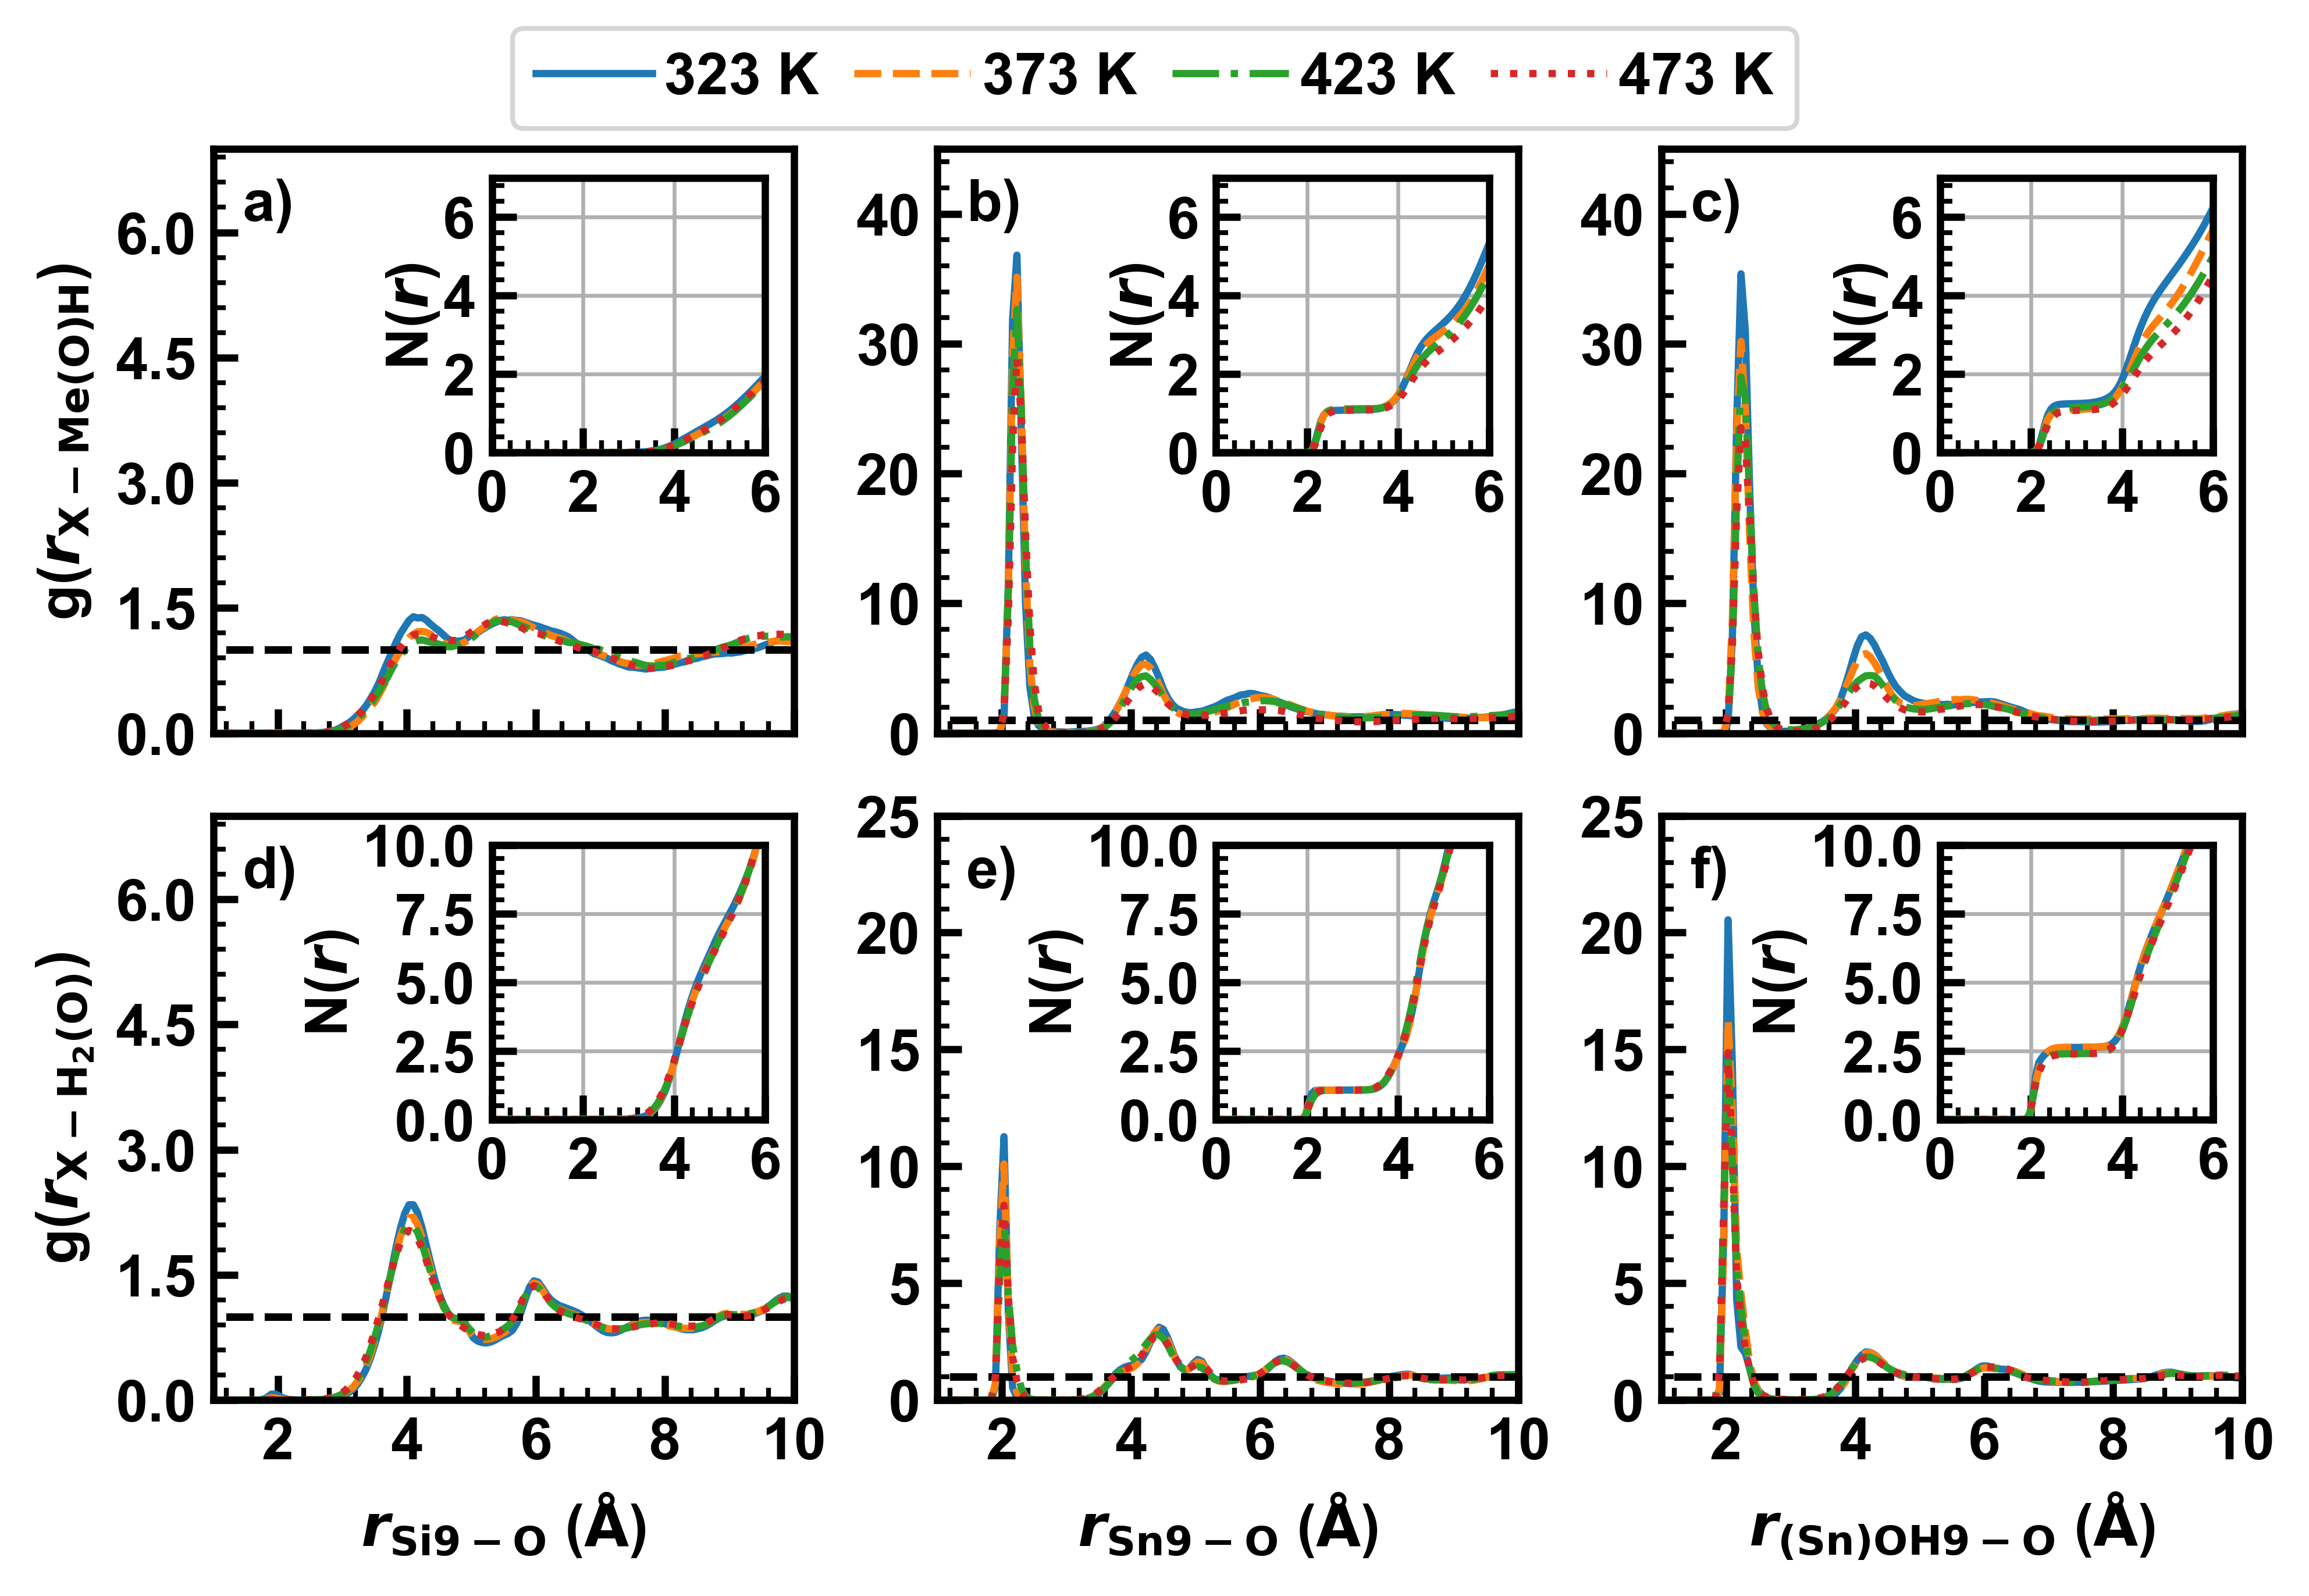

In [ ]:
def plot_rdf(directory, ax, plot_one = True, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/rdf.npy")
    if plot_one: ax.hlines(xmin=0, xmax=x[-1], y=1.0, color="k", linestyles='dashed')
    
    apply_kwargs(ax, x, y, kwargs) 


def plot_ni(directory, ax, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/number_integral.npy")   
    apply_kwargs(ax, x, y, kwargs) 

def find_extrema(directory):
    print(directory)
    x = np.load(f"{directory}/xbins.npy")
    ni = np.load(f"{directory}/number_integral.npy")   
    rdf = np.load(f"{directory}/rdf.npy")
    print("Relative Maxima")
    max_indices = argrelextrema(rdf, np.greater)[0] 
    print("r", x[max_indices])
    print("rdf", rdf[max_indices])
    print("ni", ni[max_indices])
    print() 

    # for local minima
    min_indices = argrelextrema(rdf, np.less)[0]
    print("Relative Minima")
    print(x[min_indices])
    print(rdf[min_indices])
    print(ni[min_indices]) 
    print() 




fig, axs = plt.subplot_mosaic(
    [["a)", "b)", "c)"], ["d)", "e)", "f)"]], 
    figsize=(6.5, 4.5), dpi=600, 
    sharex = True, sharey = False, 
    layout="constrained"
    )

def rdf_over_temps(ax, directory, label = False, ins_lims = (0.0, 7.0)):

    axins = inset_axes(ax, width="47%", height="47%")

    #if label:
        #plot_rdf(f"{directory}/323/rdf", ax, kwargs = {"label": "323 K", "marker": "s", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/373/rdf", ax, kwargs = {"label": "373 K", "marker": "o", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/423/rdf", ax, kwargs = {"label": "423 K", "marker": "d", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/473/rdf", ax, kwargs = {"label": "473 K", "marker": "^", "markeredgecolor": "k", "markevery": 15})
    #else:
        #plot_rdf(f"{directory}/323/rdf", ax, kwargs = {"marker": "s", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/373/rdf", ax, kwargs = {"marker": "o", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/423/rdf", ax, kwargs = {"marker": "d", "markeredgecolor": "k", "markevery": 15})
        #plot_rdf(f"{directory}/473/rdf", ax, kwargs = { "marker": "^", "markeredgecolor": "k", "markevery": 15})

    #plot_ni(f"{directory}/323/rdf", axins, kwargs = {"marker": "s", "markeredgecolor": "k", "markevery": 10})
    #plot_ni(f"{directory}/373/rdf",  axins, kwargs = { "marker": "o", "markeredgecolor": "k", "markevery": 10})
    #plot_ni(f"{directory}/423/rdf",  axins, kwargs = { "marker": "d", "markeredgecolor": "k", "markevery": 10})
    #plot_ni(f"{directory}/473/rdf",  axins, kwargs = {"marker": "^", "markeredgecolor": "k", "markevery": 10})

    if label:
        plot_rdf(f"{directory}/323/rdf", ax, kwargs = {"label": "323 K", "linestyle":"solid" })
        find_extrema(f"{directory}/323/rdf")
        plot_rdf(f"{directory}/373/rdf", ax, kwargs = {"label": "373 K", "linestyle":"dashed"  })
        find_extrema(f"{directory}/373/rdf")
        plot_rdf(f"{directory}/423/rdf", ax, kwargs = {"label": "423 K", "linestyle":"dashdot" })
        find_extrema(f"{directory}/423/rdf")
        plot_rdf(f"{directory}/473/rdf", ax, kwargs = {"label": "473 K", "linestyle":"dotted"  })
        find_extrema(f"{directory}/473/rdf")
    else:
        plot_rdf(f"{directory}/323/rdf", ax, kwargs = { "linestyle":"solid"})
        find_extrema(f"{directory}/323/rdf")
        plot_rdf(f"{directory}/373/rdf", ax, kwargs = {"linestyle":"dashed" })
        find_extrema(f"{directory}/373/rdf")
        plot_rdf(f"{directory}/423/rdf", ax, kwargs = {"linestyle":"dashdot"})
        find_extrema(f"{directory}/423/rdf")
        plot_rdf(f"{directory}/473/rdf", ax, kwargs = {"linestyle":"dotted"})
        find_extrema(f"{directory}/473/rdf")

    plot_ni(f"{directory}/323/rdf", axins, kwargs = {"linestyle":"solid"})
    plot_ni(f"{directory}/373/rdf",  axins, kwargs = { "linestyle":"dashed"})
    plot_ni(f"{directory}/423/rdf",  axins, kwargs = {"linestyle":"dashdot"})
    plot_ni(f"{directory}/473/rdf",  axins, kwargs = {"linestyle":"dotted"})




    ax.set_xlim((1.0, 10.0))
    #ax.set_ylim((0.0, 40.0))

    axins.set_xlim((0, 6))
    axins.set_ylim(ins_lims)


    #ax.set_ylabel(r"g($r$)")
    #ax.set_xlabel(r"$r$ ($\mathrm{\AA}$)")
    axins.set_ylabel(r"N($r$)", labelpad=0.25)
    #axins.set_xlabel(r"$r$ ($\mathrm{\AA}$)")

    axins.grid(True)
    set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)

rdf_over_temps(axs["a)"], "../meoh-9/pureSi", label = True)
rdf_over_temps(axs["b)"], "../meoh-9/t9", label = False)
rdf_over_temps(axs["c)"], "../meoh-9/st9", label = False)


rdf_over_temps(axs["d)"], "../wat-39/pureSi", label = False, ins_lims=(0.0, 10.0))
rdf_over_temps(axs["e)"], "../wat-39/t9", label = False, ins_lims=(0.0, 10.0))
rdf_over_temps(axs["f)"], "../wat-39/st9", label = False, ins_lims=(0.0, 10.0))



axs["a)"].set_ylabel(r"g($r_{\mathrm{X-Me(O)H}}$)")
axs["d)"].set_ylabel(r"g($r_{\mathrm{X-H_2(O)}}$)")
axs["a)"].set_ylim((0.0, 7.0))
axs["d)"].set_ylim((0.0, 7.0))
fig.legend(loc = "outside upper center", ncols = 4, columnspacing = 0.6, handletextpad=0.2)



axs["b)"].set_ylim((0.0, 45))
axs["c)"].set_ylim((0.0, 45))


axs["e)"].set_ylim((0.0, 25))
axs["f)"].set_ylim((0.0, 25))


axs["d)"].set_xlabel(r"$r_{\mathrm{Si9-O}}$ ($\mathrm{\AA}$)")
axs["e)"].set_xlabel(r"$r_{\mathrm{Sn9-O}}$ ($\mathrm{\AA}$)")
axs["f)"].set_xlabel(r"$r_{\mathrm{(Sn)OH9-O}}$ ($\mathrm{\AA}$)")


label_mosaic_subplot(axs)

for key, ax in axs.items():
    
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5)


save_figure(fig, "T9-solventO-rdfs")



# MSDs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


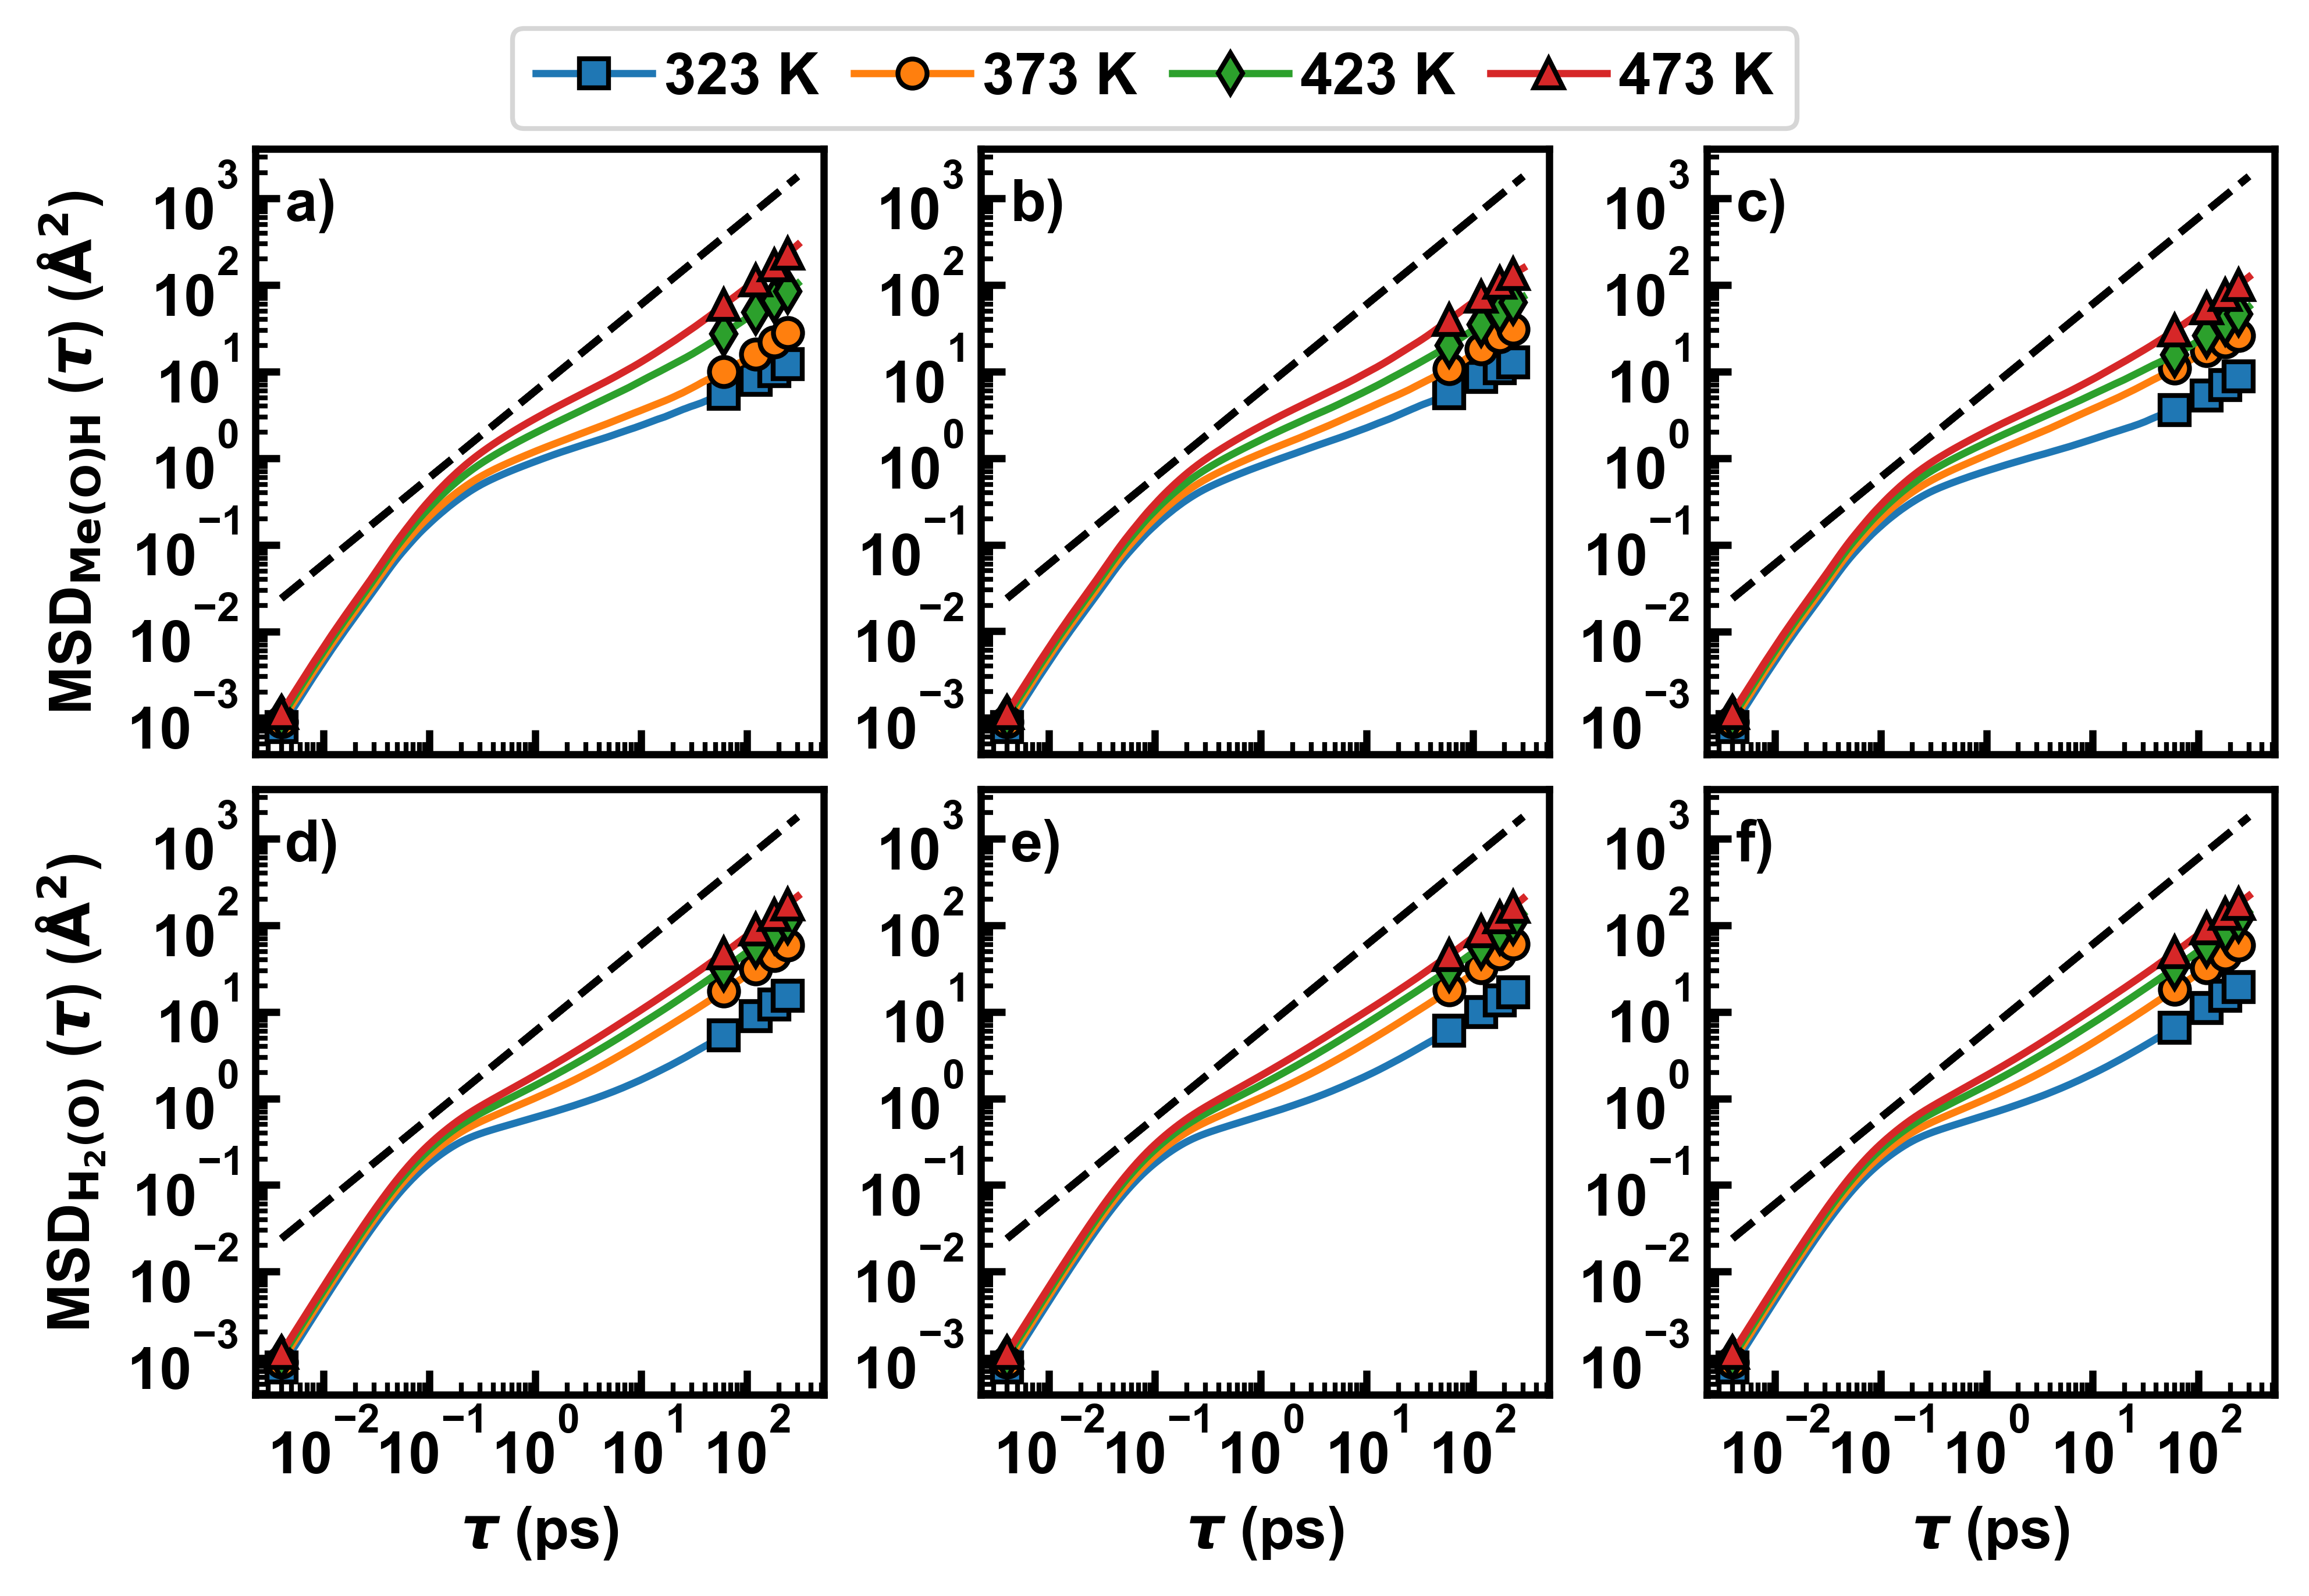

In [ ]:
def plot_msd(directory, ax, kwargs = None):
    
    ax.loglog()

    x = np.load(f"{directory}/tau.npy")
    y = np.load(f"{directory}/msd.npy")

    apply_kwargs(ax, x, y, kwargs) 

    exact = x*6
    # plot the exact result , label=r'$y=2 D\tau$'
    ax.plot(x, exact, color="black", linestyle="--")


    start_time = 15.0
    timestep = 0.004
    start_index = int(start_time/timestep)
    end_index = -1

    linear_model = linregress(x[start_index:end_index], y[start_index:end_index])

    slope = linear_model.slope
    error = linear_model.stderr
    # dim_fac is 3 as we computed a 3D msd with 'xyz'
    D = slope * 1.0/(2.0*3.0)
    D_error = error  * 1.0/(2.0*3.0)
    return D, D_error


fig, axs = plt.subplot_mosaic(
    [["a)", "b)", "c)"], ["d)", "e)", "f)"]], 
    figsize=(6.5, 4.5), dpi=600, 
    sharex = True, sharey = False, 
    layout="constrained"
    )

def msd_over_temps(ax, directory, label = False):

    Ds = []
    D_errors = []

    if label:
        D, D_error = plot_msd(f"{directory}/323/msd", ax, kwargs = {"label": "323 K", "marker": "s", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/373/msd", ax, kwargs = {"label": "373 K", "marker": "o", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/423/msd", ax, kwargs = {"label": "423 K", "marker": "d", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/473/msd", ax, kwargs = {"label": "473 K", "marker": "^", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

    else:
        D, D_error = plot_msd(f"{directory}/323/msd", ax, kwargs = {"marker": "s", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/373/msd", ax, kwargs = { "marker": "o", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/423/msd", ax, kwargs = { "marker": "d", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

        D, D_error = plot_msd(f"{directory}/473/msd", ax, kwargs = { "marker": "^", "markeredgecolor": "k", "markevery": 15000})
        Ds.append(D)
        D_errors.append(D_error)

    nticks = 5
    maj_loc = ticker.LogLocator(numticks=nticks)
    min_loc = ticker.LogLocator(subs='all', numticks=nticks)
    ax.yaxis.set_major_locator(maj_loc)
    ax.yaxis.set_minor_locator(min_loc)
    ax.xaxis.set_major_locator(maj_loc)
    ax.xaxis.set_minor_locator(min_loc)
    return np.array(Ds), np.array(D_errors)


diffusion = {
    "temperature": np.array([323, 373, 423, 473]),
    "meoh-9": {
        "pureSi": {"coefficient": [] ,"error": []}, 
        "t9": {"coefficient": [] ,"error": []}, 
        "st9": {"coefficient": [] ,"error": []},  
             },
    "wat-39": {
        "pureSi": {"coefficient": [] ,"error": []}, 
        "t9": {"coefficient": [] ,"error": []}, 
        "st9": {"coefficient": [] ,"error": []},  
             },
}




D, err = msd_over_temps(axs["a)"], "../meoh-9/pureSi", label = True)
diffusion["meoh-9"]["pureSi"]["coefficient"] = D
diffusion["meoh-9"]["pureSi"]["error"] = err 


D, err =  msd_over_temps(axs["b)"], "../meoh-9/t9", label = False)
diffusion["meoh-9"]["t9"]["coefficient"] = D
diffusion["meoh-9"]["t9"]["error"] = err 

D, err = msd_over_temps(axs["c)"], "../meoh-9/st9", label = False)
diffusion["meoh-9"]["st9"]["coefficient"] = D
diffusion["meoh-9"]["st9"]["error"] = err 

D, err = msd_over_temps(axs["d)"], "../wat-39/pureSi", label = False)
diffusion["wat-39"]["pureSi"]["coefficient"] = D
diffusion["wat-39"]["pureSi"]["error"] = err 

D, err = msd_over_temps(axs["e)"], "../wat-39/t9", label = False)
diffusion["wat-39"]["t9"]["coefficient"] = D
diffusion["wat-39"]["t9"]["error"] = err 

D, err = msd_over_temps(axs["f)"], "../wat-39/st9", label = False)
diffusion["wat-39"]["st9"]["coefficient"] = D
diffusion["wat-39"]["st9"]["error"] = err 

axs["a)"].set_ylabel(r"MSD$_{\mathrm{Me(O)H}}$ ($\tau$) ($\mathrm{\AA}^2$)")
axs["d)"].set_ylabel(r"MSD$_{\mathrm{H_2(O)}}$ ($\tau$) ($\mathrm{\AA}^2$)")

fig.legend(loc = "outside upper center", ncols = 4, columnspacing = 0.6, handletextpad=0.2)


axs["d)"].set_xlabel(r"$\tau$ (ps)")
axs["e)"].set_xlabel(r"$\tau$ (ps)")
axs["f)"].set_xlabel(r"$\tau$ (ps)")


ax = axs["a)"]


ax.text(
        0.6, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'Si',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["b)"]
ax.text(
        0.6, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'Sn9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["c)"]
ax.text(
        0.6, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'SnOH9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )




ax = axs["d)"]
ax.text(
        0.6, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'Si',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["e)"]
ax.text(
        0.6, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'Sn9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["f)"]
ax.text(
        0.6, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.6, 0.15,
        f'SnOH9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
""




label_mosaic_subplot(axs)

save_figure(fig, "solventO-msds")



MeOH Si
Arrhenius Analysis
Slope:  -0.28483484246050017
95% CI:  0.10880582090222332
Intercept:  4.994661538097323
95% CI:  3.270159586252964
R2:  0.9844803300332431

MeOH Sn9
Arrhenius Analysis
Slope:  -0.22327951445123678
95% CI:  0.037829467266097004
Intercept:  2.9593251267537672
95% CI:  1.1369648608619798
R2:  0.9969084563859525

MeOH SnOH9
Arrhenius Analysis
Slope:  -0.22307730350973712
95% CI:  0.049293849703035
Intercept:  2.664448449541134
95% CI:  1.4815269423365824
R2:  0.9947525637286287

Wat Si
Arrhenius Analysis
Slope:  -0.22273249271792733
95% CI:  0.10440073684948456
Intercept:  3.45202949657725
95% CI:  3.13776475917603
R2:  0.976814864539681

Wat Sn9
Arrhenius Analysis
Slope:  -0.20879801782699825
95% CI:  0.11086982839191291
Intercept:  3.055704883669597
95% CI:  3.332193343477881
R2:  0.9704402858611577

Wat SnOH9
Arrhenius Analysis
Slope:  -0.20484722156655893
95% CI:  0.061687269012170746
Intercept:  2.995122695927669
95% CI:  1.8540112324614935
R2:  0.9902981555

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


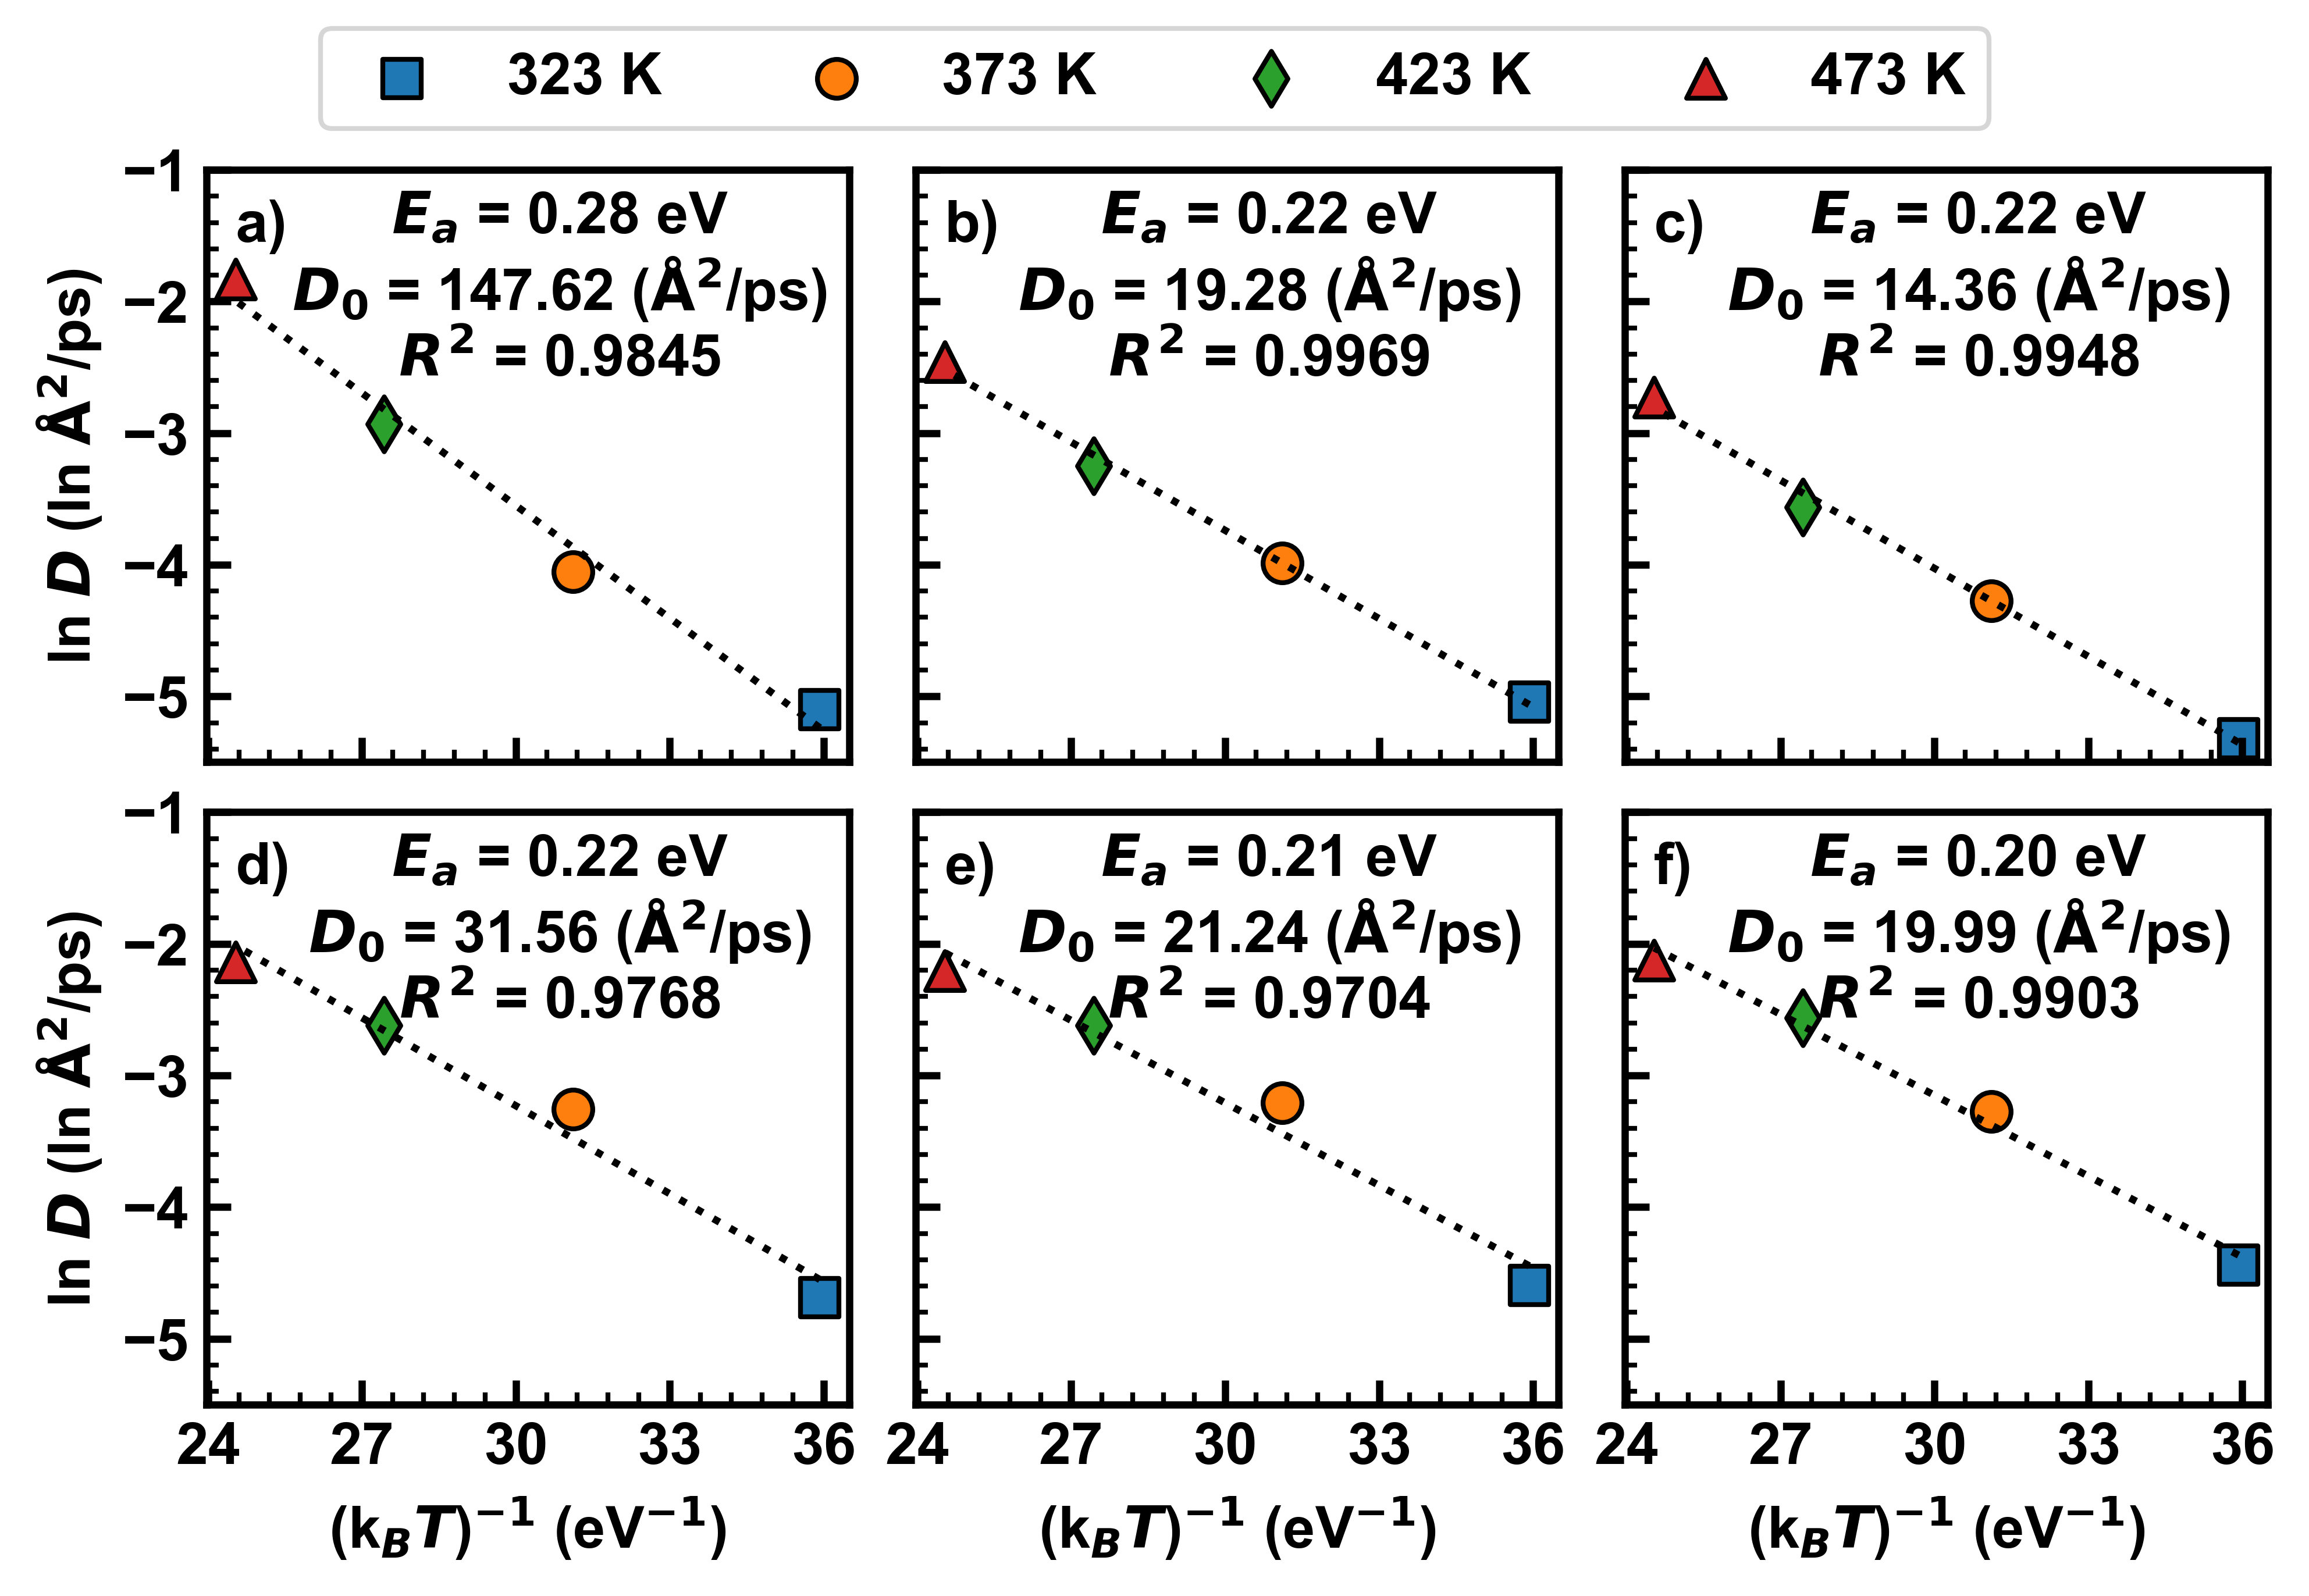

In [9]:

fig, axs = plt.subplot_mosaic(
    [["a)", "b)", "c)"], ["d)", "e)", "f)"]], 
    figsize=(6.5, 4.5), dpi=600, 
    sharex = True, sharey = True, 
    layout="constrained"
    )


def arrhenius_diffusion(temps, Ds, Derrs, ax, colors = [colors[0], colors[1], colors[2], colors[3]], markers = ["s", "o", "d", "^"], label = False, annotate = False):
    beta = 1.0 / temps / units.kB
    lnD = np.log(Ds)
    lnDerrs = Derrs / Ds
    res = linregress(beta, lnD)
    slope = res.slope
    intercept = res.intercept
    r2 = res.rvalue**2
    slope_confidence, intercept_confidence = confidence_interval(beta, res)

    x = np.linspace(beta[0], beta[-1])
    y = intercept + slope * x
    ax.plot(x, y, color = "k", linestyle = ":")

    for i in range(len(beta)):
        if label:
                #ax.errorbar(beta[i], lnD[i], yerr = lnDerrs[i], color = colors[i], markersize = 8, marker = markers[i], markeredgecolor = "k", label = f"{temps[i]} K" )
                ax.scatter(beta[i], lnD[i],  color = colors[i], s = 64, marker = markers[i], edgecolors = "k", label = f"{temps[i]} K" )

        else:
                ax.scatter(beta[i], lnD[i], color = colors[i], s = 64, marker = markers[i], edgecolors = "k")
                #ax.errorbar(beta[i], lnD[i], yerr = lnDerrs[i], color = colors[i], markersize = 8, marker = markers[i], markeredgecolor = "k" )

    print("Arrhenius Analysis")
    print("Slope: ", slope)
    print("95% CI: ", slope_confidence)
    print("Intercept: ", intercept)
    print("95% CI: ", intercept_confidence)
    print("R2: ", r2)
    print()



    if annotate:
        ax.text(
        0.55, 0.92,
        f'$E_a$ = {-slope:.2f} eV',
        #f'$E_a$ = {-slope:.2f}({slope_confidence:.2f}) eV',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

        d0 = np.exp(intercept)
        ci_exp = d0*intercept_confidence
        ax.text(
        0.55, 0.8,
        r"$D_0$ = " + f"{d0:.2f}"+ r" ($\mathrm{\AA}^2$/ps)",
        #f"$D_0$ = {d0:.2f} "+ r"$\mathrm{\AA}^2/ps", 
        #f'$D_0$ = {d0:.2f}({ci_exp:.2f}) $\mathrm{\AA}^2$/ps',
        horizontalalignment='center',
        verticalalignment='center', 
        transform = ax.transAxes
        )

        ax.text(
        0.55, 0.68,
        f'$R^2$ = {r2:.4}',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

    return slope, slope_confidence, intercept, intercept_confidence, r2 


#diffusion
print("MeOH Si")
arrhenius_diffusion(diffusion["temperature"], diffusion["meoh-9"]["pureSi"]["coefficient"], diffusion["meoh-9"]["pureSi"]["error"], axs["a)"], annotate = True, label = True)

print("MeOH Sn9")
arrhenius_diffusion(diffusion["temperature"], diffusion["meoh-9"]["t9"]["coefficient"], diffusion["meoh-9"]["t9"]["error"], axs["b)"], annotate = True)

print("MeOH SnOH9")
arrhenius_diffusion(diffusion["temperature"], diffusion["meoh-9"]["st9"]["coefficient"], diffusion["meoh-9"]["st9"]["error"], axs["c)"], annotate = True)

print("Wat Si")
arrhenius_diffusion(diffusion["temperature"], diffusion["wat-39"]["pureSi"]["coefficient"], diffusion["wat-39"]["pureSi"]["error"], axs["d)"], annotate = True)

print("Wat Sn9")
arrhenius_diffusion(diffusion["temperature"], diffusion["wat-39"]["t9"]["coefficient"], diffusion["wat-39"]["t9"]["error"], axs["e)"], annotate = True)

print("Wat SnOH9")
arrhenius_diffusion(diffusion["temperature"], diffusion["wat-39"]["st9"]["coefficient"], diffusion["wat-39"]["st9"]["error"], axs["f)"], annotate = True)

axs["a)"].set_ylim((-5.5, -1.0))

"""
ax = axs["a)"]
ax.text(
        0.3, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'Si',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["b)"]
ax.text(
        0.3, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'Sn9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["c)"]
ax.text(
        0.3, 0.25,
        f'MeOH',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'SnOH9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )




ax = axs["d)"]
ax.text(
        0.3, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'Si',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["e)"]
ax.text(
        0.3, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'Sn9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )

ax = axs["f)"]
ax.text(
        0.3, 0.25,
        f'H$_2$O',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
ax.text(
        0.3, 0.15,
        f'SnOH9',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
        )
"""


for ax in [axs["a)"], axs["d)"]]:
    ax.set_ylabel(r"ln $D$ (ln $\mathrm{\AA}^2$/ps)")


for ax in [axs["d)"], axs["e)"], axs["f)"]]:
    ax.set_xlabel(r"(k$_BT$)$^{-1}$ (eV$^{-1}$)")

    
for key, ax in axs.items():
    
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5)

label_mosaic_subplot(axs)

fig.legend(loc = "outside upper center", ncols = 4)

save_figure(fig, "solventO-Ea_diff")
pass


In [ ]:

fig, axs = plt.subplots(
    nrows = 1, ncols = 1, 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )
labels =  ["100 Silica", "100 Active", "010 Silica" , "010 Active"]



x = np.arange(len(labels))  # the label locations
w = 0.3

def plot_bar(x, distribution_over_time, label, width = 0.3):
    means = distribution_over_time.mean(axis = 0)
    std =  distribution_over_time.std(axis = 0)
    rects = axs.bar(x, means, width, yerr = std, label = label)
    return rects



s = "wat-39"
z = "pureSi"
t = "373"
plot_bar(x - w, results[s][z][t], label = "H$_2$O @ Si", width = w)


s = "wat-39"
z = "t9"
t = "373"
plot_bar(x, results[s][z][t], label = "H$_2$O @ Sn9", width = w)


s = "wat-39"
z = "st9"
t = "373"
plot_bar(x + w, results[s][z][t], label = "H$_2$O @ SnOH9", width = w)

# Add some text for labels, title and custom x-axis tick labels, etc.

axs.set_ylabel('No. Molecules')
axs.set_xticks(x)
axs.set_xticklabels(labels)

axs.tick_params(axis='x', which='both', length=0)
#axs.set_ylim((0, 30))
fig.legend(ncols = 3, loc = "outside upper center")

# VDOS

In [5]:

linestyles = ["solid", "dashed", "solid", "dashed", "solid", "dashed"]
linestyles = ["solid", 
              (0, (5, 1)), 
              (0, (5, 5)), 
              (0, (3, 1, 1, 1)), 
              (0, (3, 5, 1, 5)),
              (0, (1, 1)),
               
               
                ]


from scipy.signal import savgol_filter

def plot_2pt(axs, filename, colors, decomposed = True, linestyle = "solid", label = None, color = "blue", normalize = None, filter = False, filter_window=1000):
    
    if decomposed:
        df = pd.read_csv(filename)
        if normalize is not None:
            df['Sv_tot (cm)'] /= normalize
            df['Sv_trn (cm)'] /= normalize
            df['Sv_rot (cm)'] /= normalize
            df['Sv_vib (cm)'] /= normalize
            df['Sv_trn_s (cm)'] /= normalize
            df['Sv_trn_g (cm)'] /= normalize
            df['Sv_rot_s (cm)'] /= normalize
            df['Sv_rot_g (cm)'] /= normalize


        if filter:
            from scipy.signal import savgol_filter
            
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)
            df['Sv_trn_s (cm)'] = savgol_filter(df['Sv_trn_s (cm)'], filter_window, 3)
            df['Sv_trn_g (cm)'] = savgol_filter(df['Sv_trn_g (cm)'], filter_window, 3)
            df['Sv_rot_s (cm)'] = savgol_filter(df['Sv_rot_s (cm)'], filter_window, 3)
            df['Sv_rot_g (cm)'] = savgol_filter(df['Sv_rot_g (cm)'], filter_window, 3)

        ax = axs[0]
        ax.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], color = colors[0], label = "Total", linestyle = "solid")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], color = colors[1],  label = "Trn", linestyle = "dashed")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], color = colors[2],  label = "Rot", linestyle = "dashdot")
        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], color = colors[3],  label = "Vib", linestyle = "dotted")


        #ax.set_xlim((0, 1000))
        # #ax.set_ylim((0, 12))
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        #ax.legend()

        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], color = colors[1], linestyle = "dashed")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn_s (cm)'],  color = colors[4], label = "Trn(s)", linestyle = "dotted")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn_g (cm)'], color = colors[5], label = "Trn(g)", linestyle = "dashdot")

        #ax.set_xlim((0, 500))
        #ax.set_ylim((0, 12))  
        ax.set_xlabel(r"$\omega$ (1/cm)")
        #ax.set_ylabel(r"S($\nu$) (cm)")

        #ax.legend()

        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'],  color = colors[2], linestyle = "dashdot")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot_s (cm)'], color = colors[6], label = "Rot(s)", linestyle="dotted")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot_g (cm)'], color = colors[7],label = "Rot(g)",linestyle = "dashed" )

        #ax.set_xlim((0, 1000))
        #ax.set_ylim((0, 4))
        ax.set_xlabel(r"$\omega$ (1/cm)")
        #ax.set_ylabel(r"S($\nu$) (cm)")

        #ax.legend()

    else:
        df = pd.read_csv(filename)
        if normalize is not None:
            df['Sv_tot (cm)'] /= normalize

        if filter:
            from scipy.signal import savgol_filter           
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
 

        axs.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], label = label, color = color, linestyle = linestyle)


        #ax.set_xlim((0, 1000))
        # #ax.set_ylim((0, 12))
        #axs.set_xlabel(r"$\nu$ (1/cm)")
        #axs.set_ylabel(r"S($\nu$) (cm)")


def plot_2pt_temperature_effect(axs, temps, filename_prefix, filename_suffix, filter = False, filter_window=1000, linestyles = ["solid", "dashed", "dashdot", "dotted"]):
    for i, temp in enumerate(temps):
        df = pd.read_csv(f"{filename_prefix}/{temp}/{filename_suffix}/sv.csv")
        
        ax = axs[0]

        if filter:
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)


        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], label = f"{temp} K", linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], linestyle = linestyles[i])  
        ax.set_xlabel(r"$\omega$ (1/cm)")



def plot_2pt_zeolite_effect(axs, zeos, filename_prefix, filename_suffix, labels, filter = False, filter_window=1000, linestyles = ["solid", "dashed", "dashdot", "dotted"]):
    i = 0
    for zeo in zeos:

        '''
        if zeo == "pureSi":
            label = "Si-BEA"

        elif zeo == "t9":
            label = "Sn9-BEA"

        elif zeo == "st9":
            label = "SnOH9-BEA"'
        '''

        df = pd.read_csv(f"{filename_prefix}/{zeo}/{filename_suffix}/sv.csv")

        if filter:
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)
        ax = axs[0]

        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], label = labels[i], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], linestyle = linestyles[i])  
        ax.set_xlabel(r"$\omega$ (1/cm)")
        i += 1




    

        


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


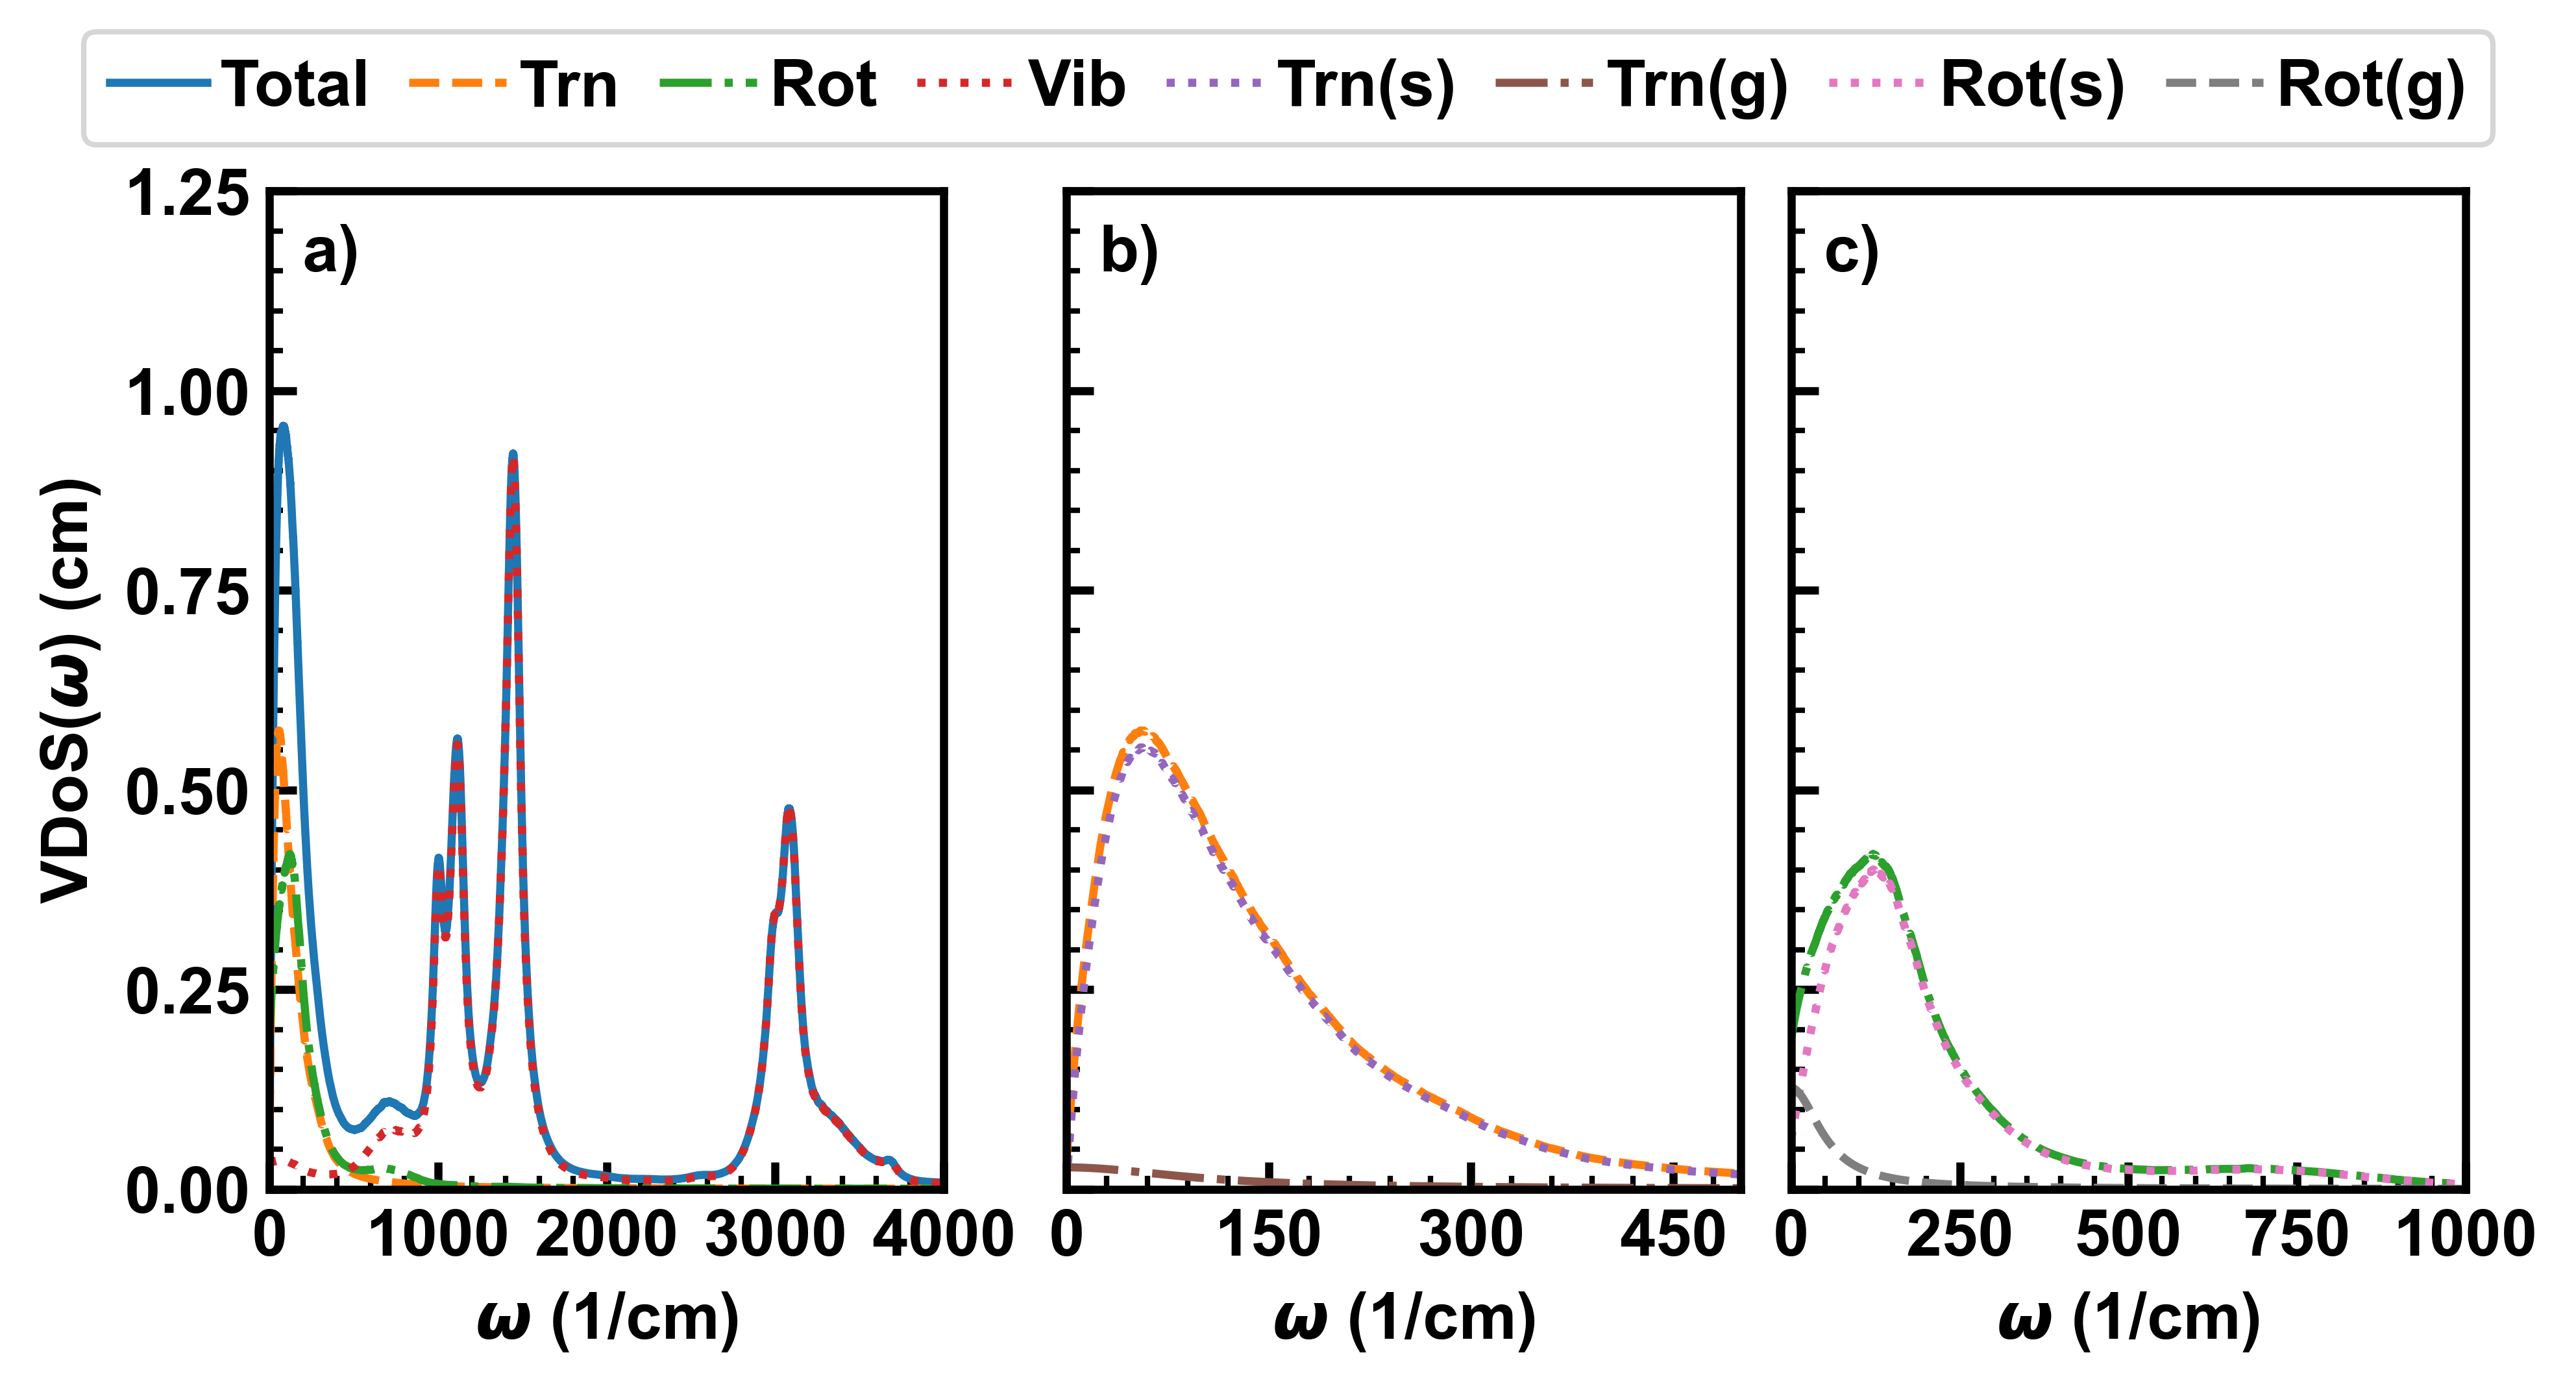

In [27]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, constrained_layout=True)
plot_2pt([axs["a)"], axs["b)"], axs["c)"]] , "../meoh-9/pureSi/373/vdos/solvent_all/sv.csv", colors, filter=True)

fig.legend(loc = "outside upper center", ncols = 8, columnspacing = 0.6, handletextpad=0.2, handlelength=1.5)

axs["a)"].set_xlim(0, 4000)
axs["b)"].set_xlim(0, 500)
axs["c)"].set_xlim(0, 1000)

for key, ax in axs.items():
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_ylim(0.0, 1.25)
label_mosaic_subplot(axs)
"""
axs["c)"].text(
        0.55, 0.75,
        r'$T$ = 373 K',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

axs["c)"].text(
        0.55, 0.65,
        r'MeOH Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

axs["c)"].text(
        0.55, 0.55,
        f'MeOH @ Si-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )
"""

save_figure(fig, "meoh-Si-373_decomposed-vdos")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


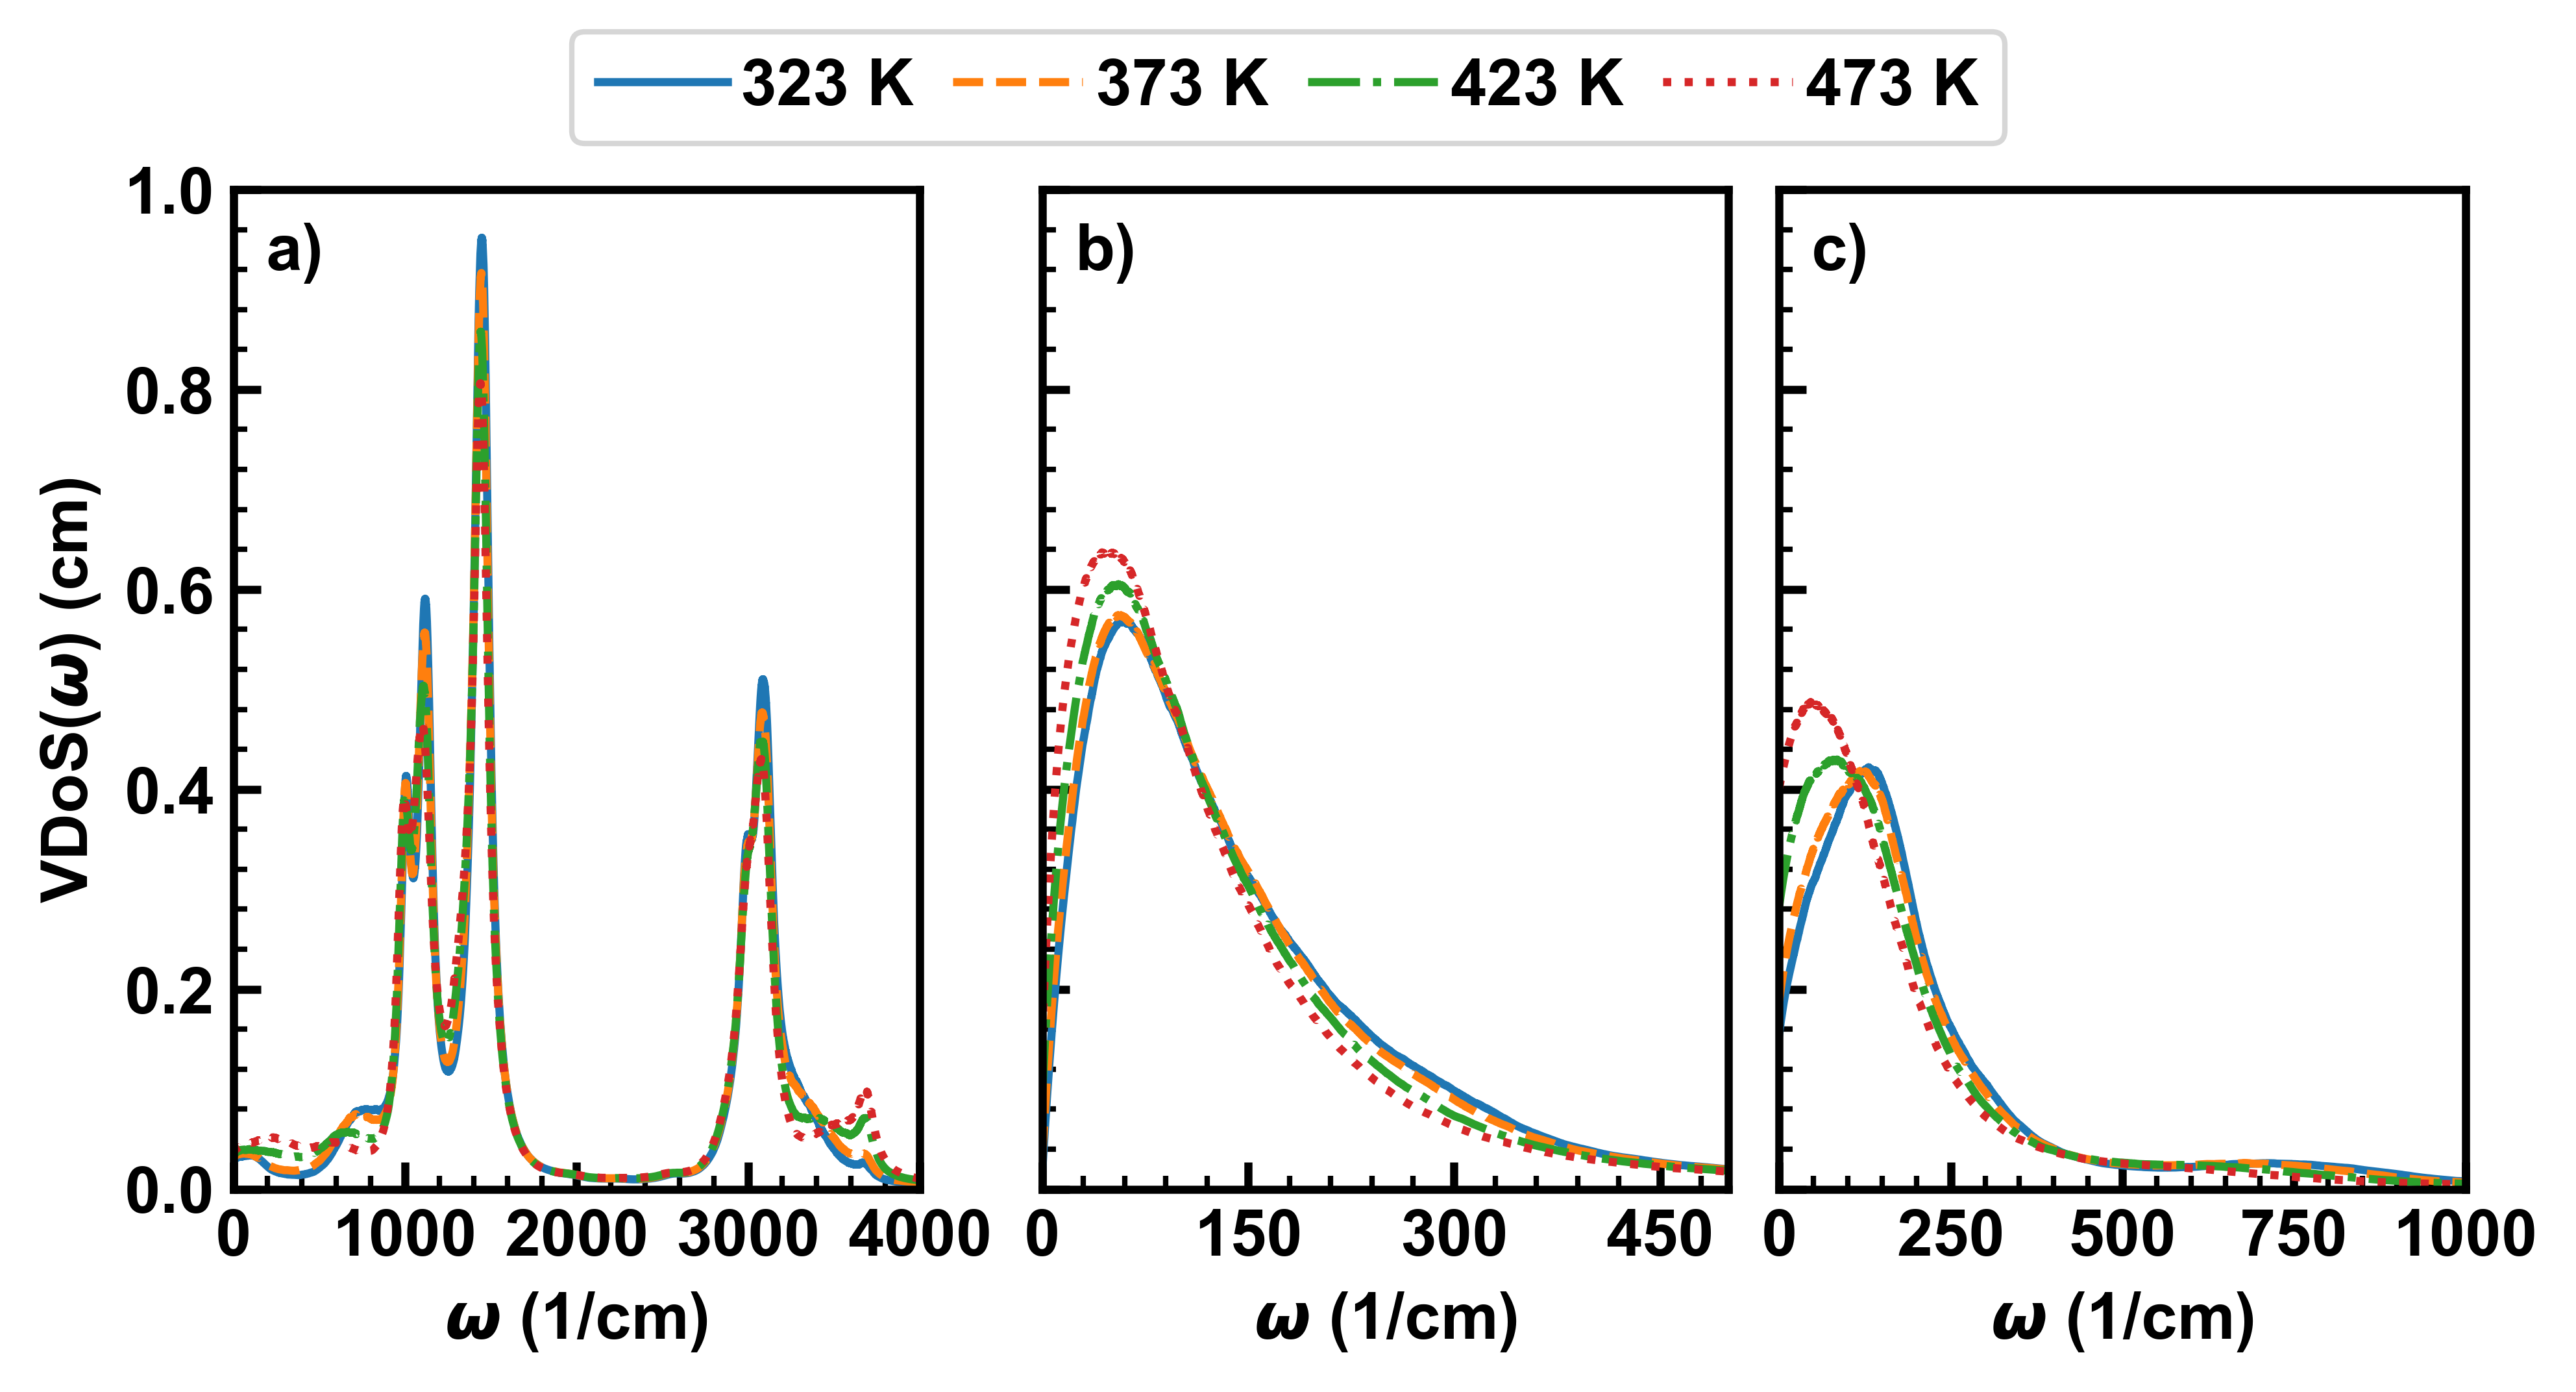

In [12]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')

plot_2pt_temperature_effect([axs["a)"], axs["b)"], axs["c)"]], [323, 373, 423, 473], "../meoh-9/pureSi", "vdos/solvent_all/", filter = True)
fig.legend(loc = "outside upper center", ncols = 4, columnspacing = 0.6, handletextpad=0.2)

axs["a)"].set_xlim(0, 4000)
axs["b)"].set_xlim(0, 500)
axs["c)"].set_xlim(0, 1000)

for key, ax in axs.items():
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_ylim(0.0, 1.0)
label_mosaic_subplot(axs)

"""
axs["c)"].text(
        0.55, 0.75,
        r'MeOH Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

axs["c)"].text(
        0.55, 0.65,
        f'MeOH @ Si-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

"""

save_figure(fig, "meoh-Si_temperature-vdos")
pass

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


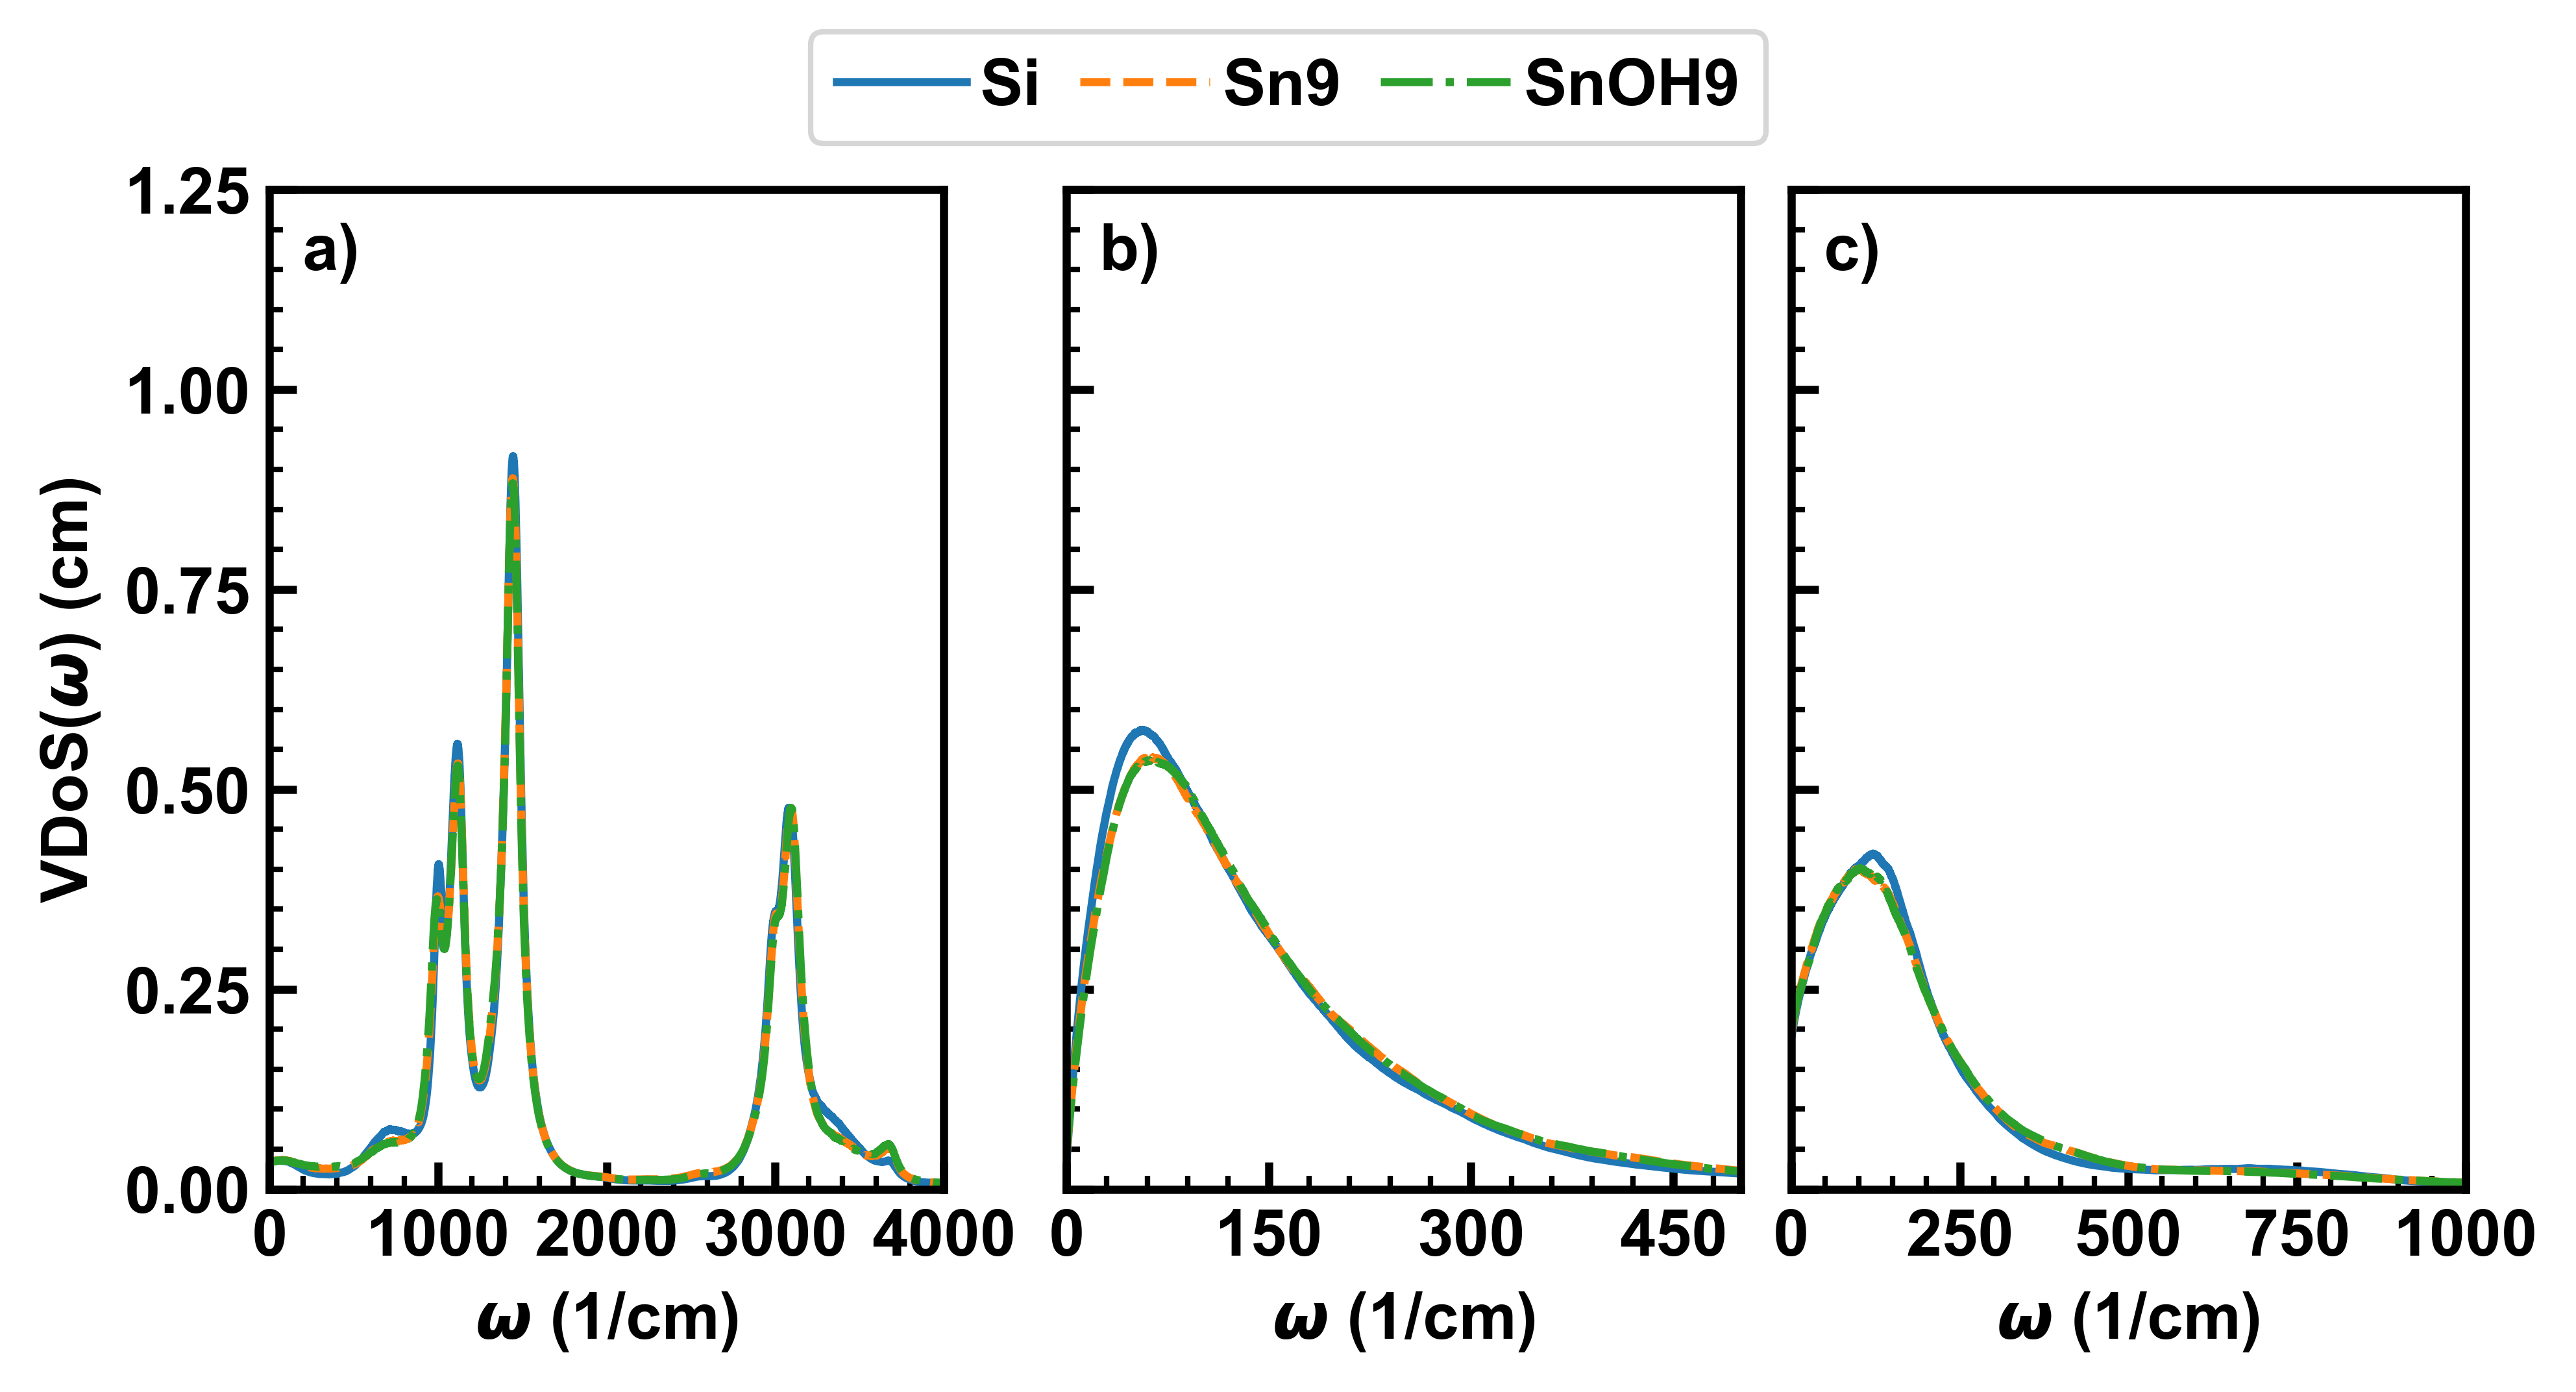

In [19]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')

plot_2pt_zeolite_effect([axs["a)"], axs["b)"], axs["c)"]], ["pureSi", "t9", "st9"], "../meoh-9", "373/vdos/solvent_all/", ["Si", "Sn9", "SnOH9"], filter = True)
fig.legend(loc = "outside upper center", ncols = 4, columnspacing = 0.6, handletextpad=0.2)

axs["a)"].set_xlim(0, 4000)
axs["b)"].set_xlim(0, 500)
axs["c)"].set_xlim(0, 1000)

for key, ax in axs.items():
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_ylim(0.0, 1.25)
label_mosaic_subplot(axs)
"""
axs["c)"].text(
        0.55, 0.75,
        r'MeOH Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

axs["c)"].text(
        0.55, 0.65,
        f'T = 373 K',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )
"""
pass



save_figure(fig, "meoh-373_zeolite-vdos")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


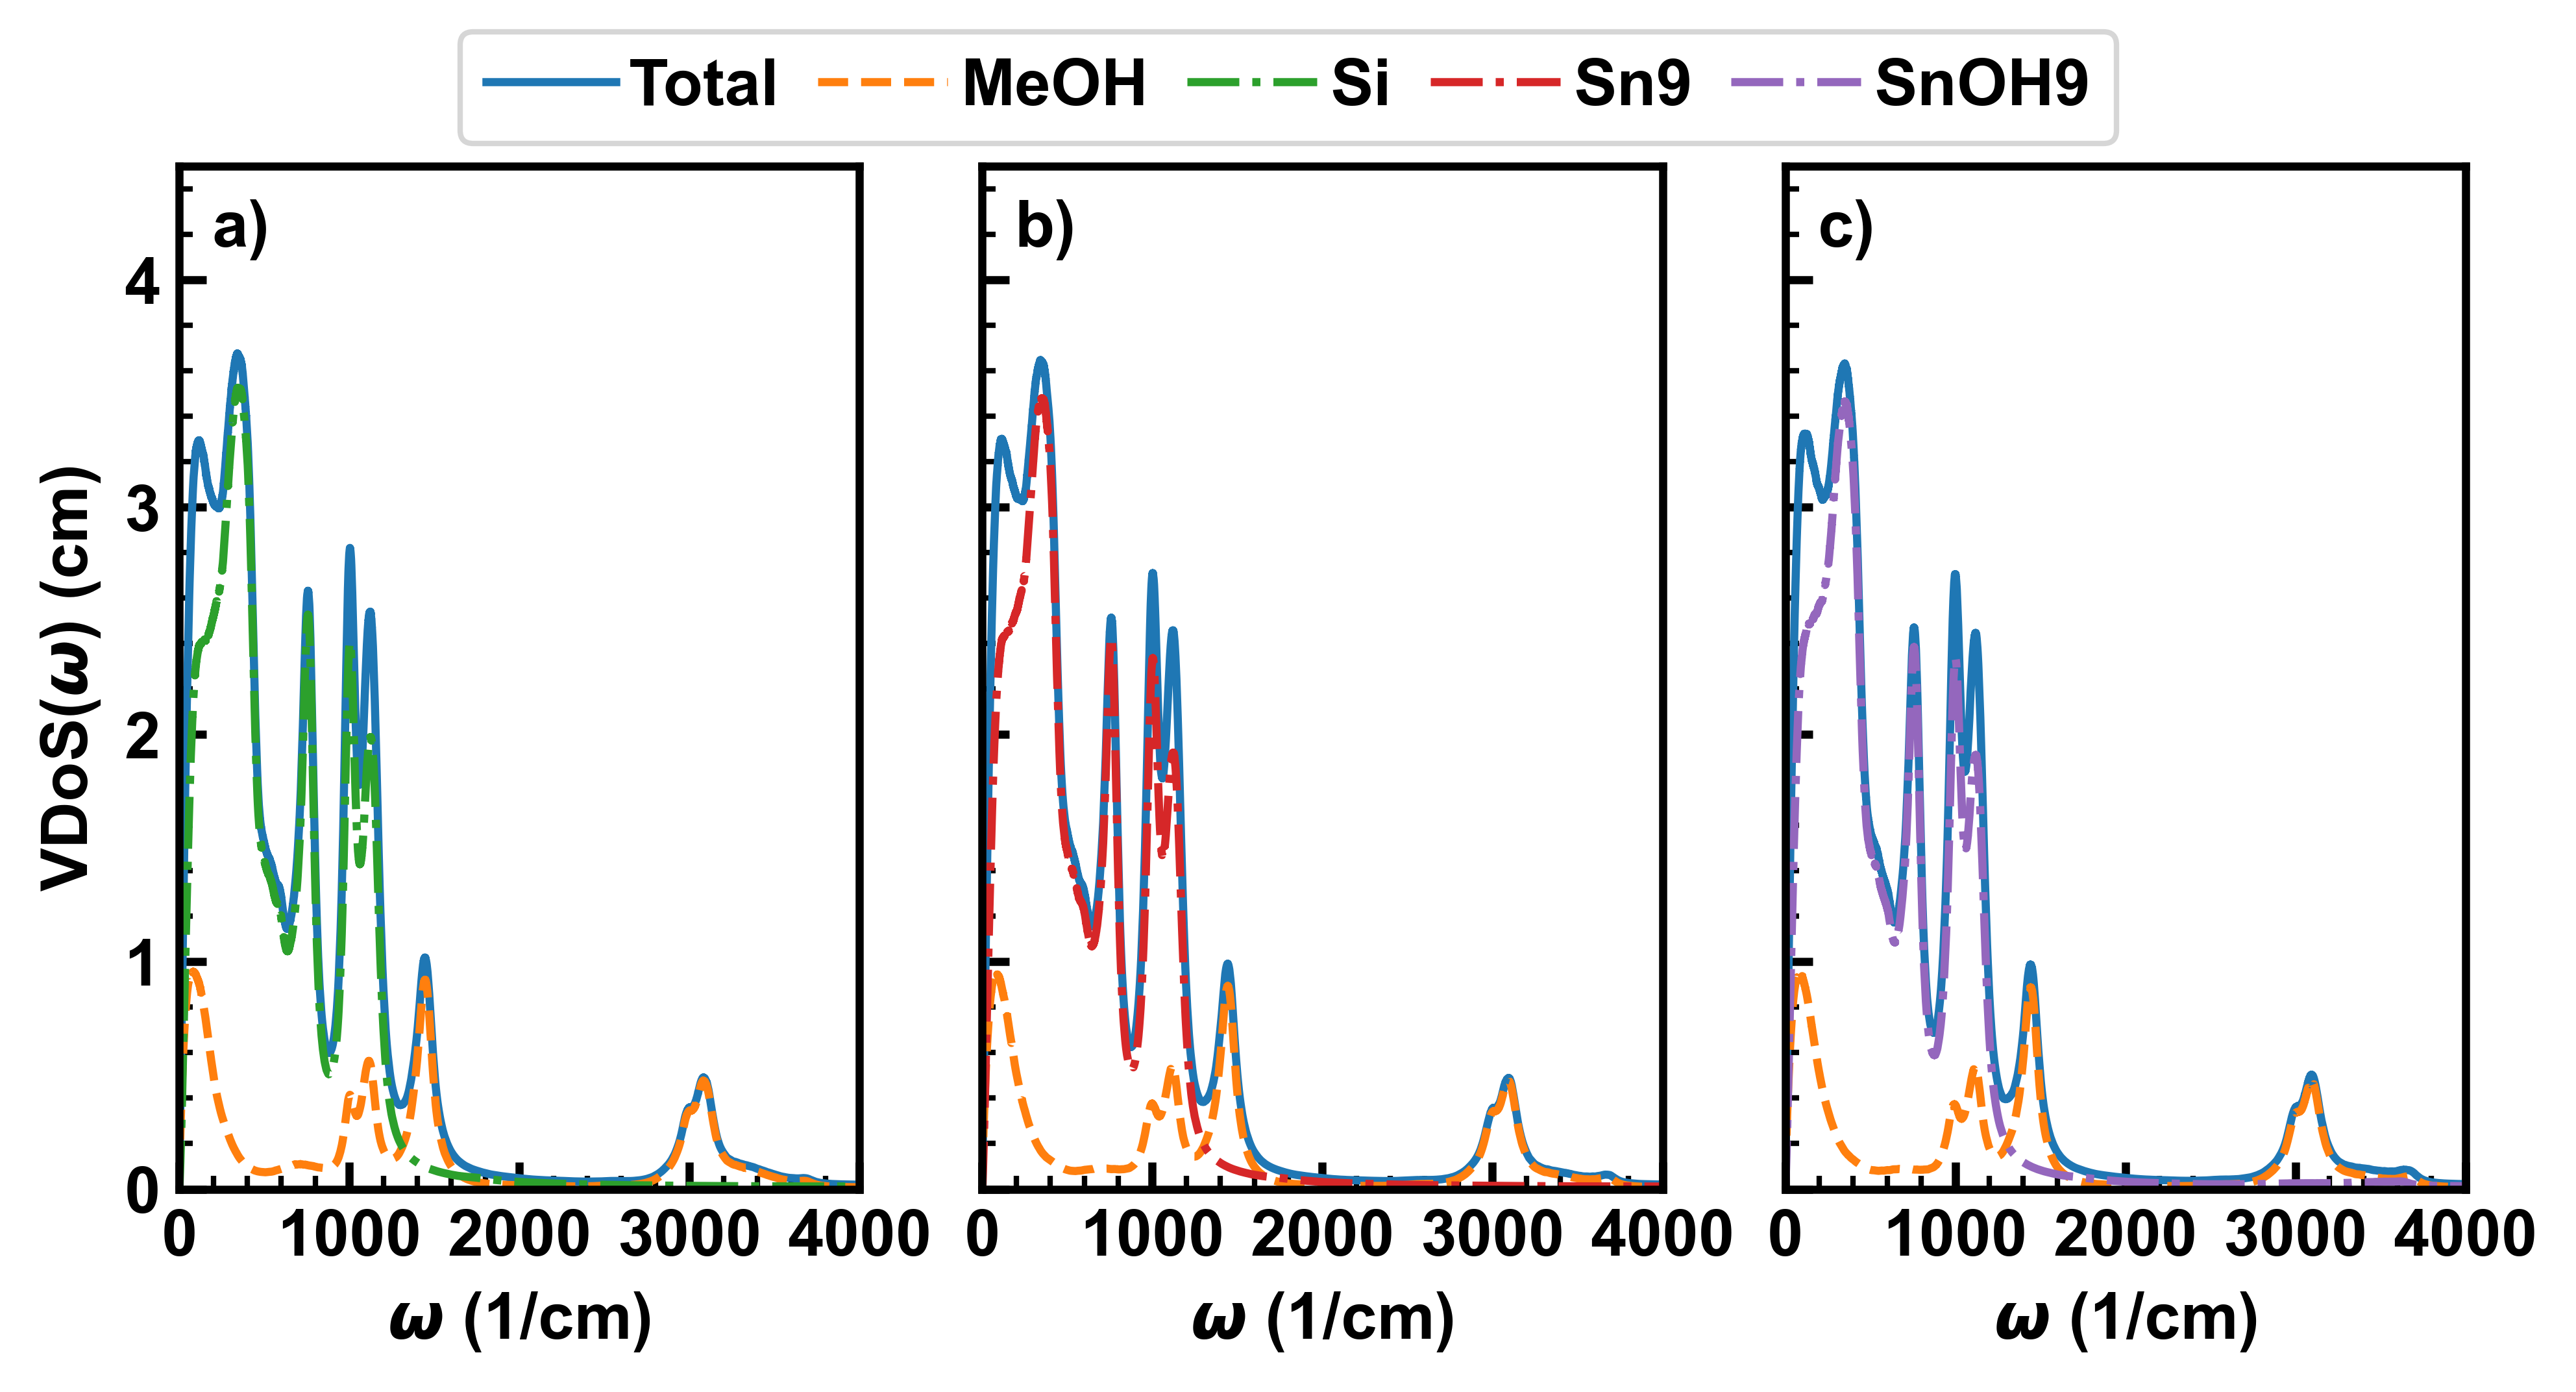

In [14]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')


plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/all/sv.csv", colors, decomposed=False, label = "Total", color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = "MeOH", color = colors[1], filter = True , linestyle="dashed")
plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Si", color = colors[2], filter = True, linestyle="dashdot")

plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, label = None, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = None, color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[3], filter = True, linestyle="dashdot")

plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/all/sv.csv", colors, decomposed=False, label = None, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = None, color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[4], filter = True, linestyle="dashdot")


fig.legend(loc = "outside upper center", ncols = 8, columnspacing = 0.6, handletextpad=0.2)


for key, ax in axs.items():
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_ylim(0.0, 4.5)
axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

label_mosaic_subplot(axs)

"""
axs["c)"].text(
        0.65, 0.75,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )


axs["c)"].text(
        0.65, 0.65,
        r'$T$ = 373 K',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )
"""


save_figure(fig, "meoh-zeolite-373_comparison-vdos")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


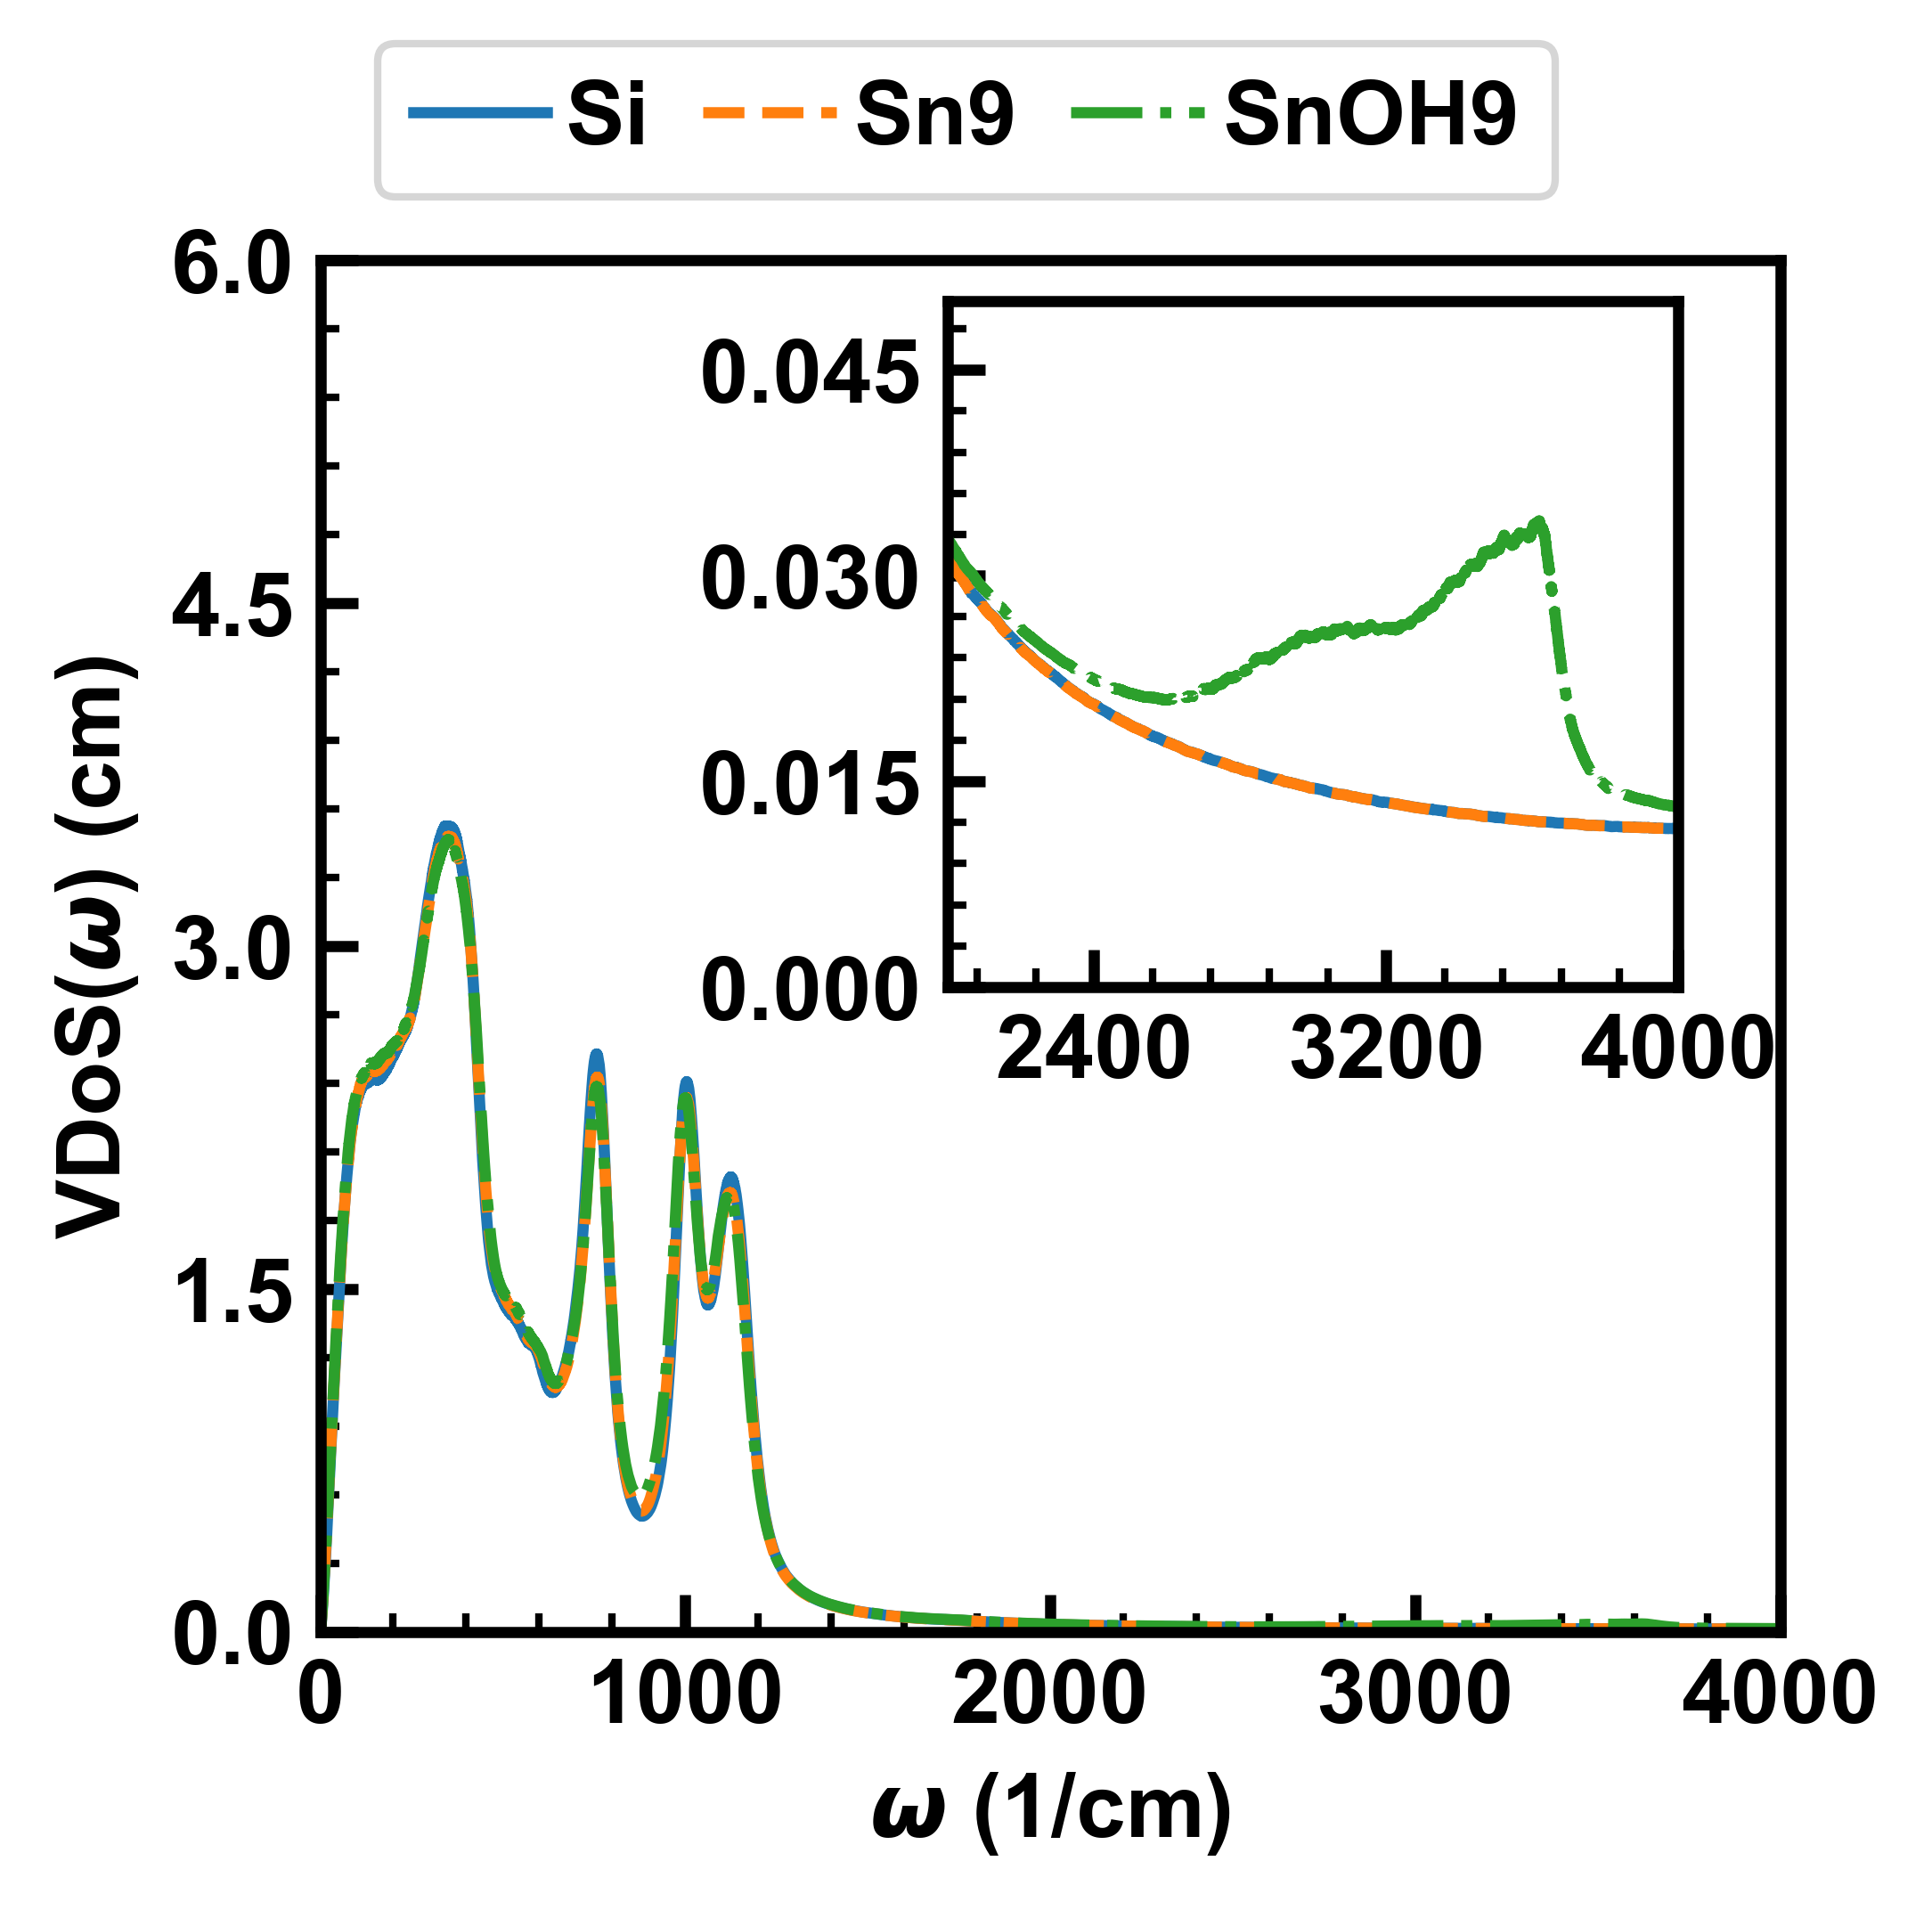

In [20]:
fig, axs = plt.subplot_mosaic([["a)"]], figsize=(3.5,3.5), sharey = False, dpi=600, layout='constrained')

plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Si", color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/t9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axs["a)"] , "../meoh-9/st9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[2], filter = True, linestyle="dashdot")


#axins = inset_axes(axs["a)"], width="47%", height="47%", borderpad=1.0)

axins = axs["a)"].inset_axes([0.43, 0.47, 0.5, 0.5])

plot_2pt(axins , "../meoh-9/pureSi/373/vdos/zeolite/sv.csv", colors, decomposed=False, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axins , "../meoh-9/t9/373/vdos/zeolite/sv.csv", colors, decomposed=False,  color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axins , "../meoh-9/st9/373/vdos/zeolite/sv.csv", colors, decomposed=False, color = colors[2], filter = True, linestyle="dashdot")


fig.legend(loc = "outside upper center", ncols = 8, columnspacing = 0.6, handletextpad=0.2, handlelength=1.5)


axs["a)"].set_xlabel(r"$\omega$ (1/cm)")
set_ticks(axs["a)"], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")
axs["a)"].set_ylim(0.0, 6)
axs["a)"].set_xlim(0, 4000)

axins.set_xlim(2000, 4000)
axins.set_ylim(0.0, 0.05)

"""
axs["b)"].text(
        0.65, 0.85,
        r'Zeolite Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )


axs["b)"].text(
        0.65, 0.75,
        r'MeOH, $T$ = 373 K',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )
"""
    
#label_mosaic_subplot(axs)



save_figure(fig, "zeolite-373-in_methanol_vdos")


pass


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


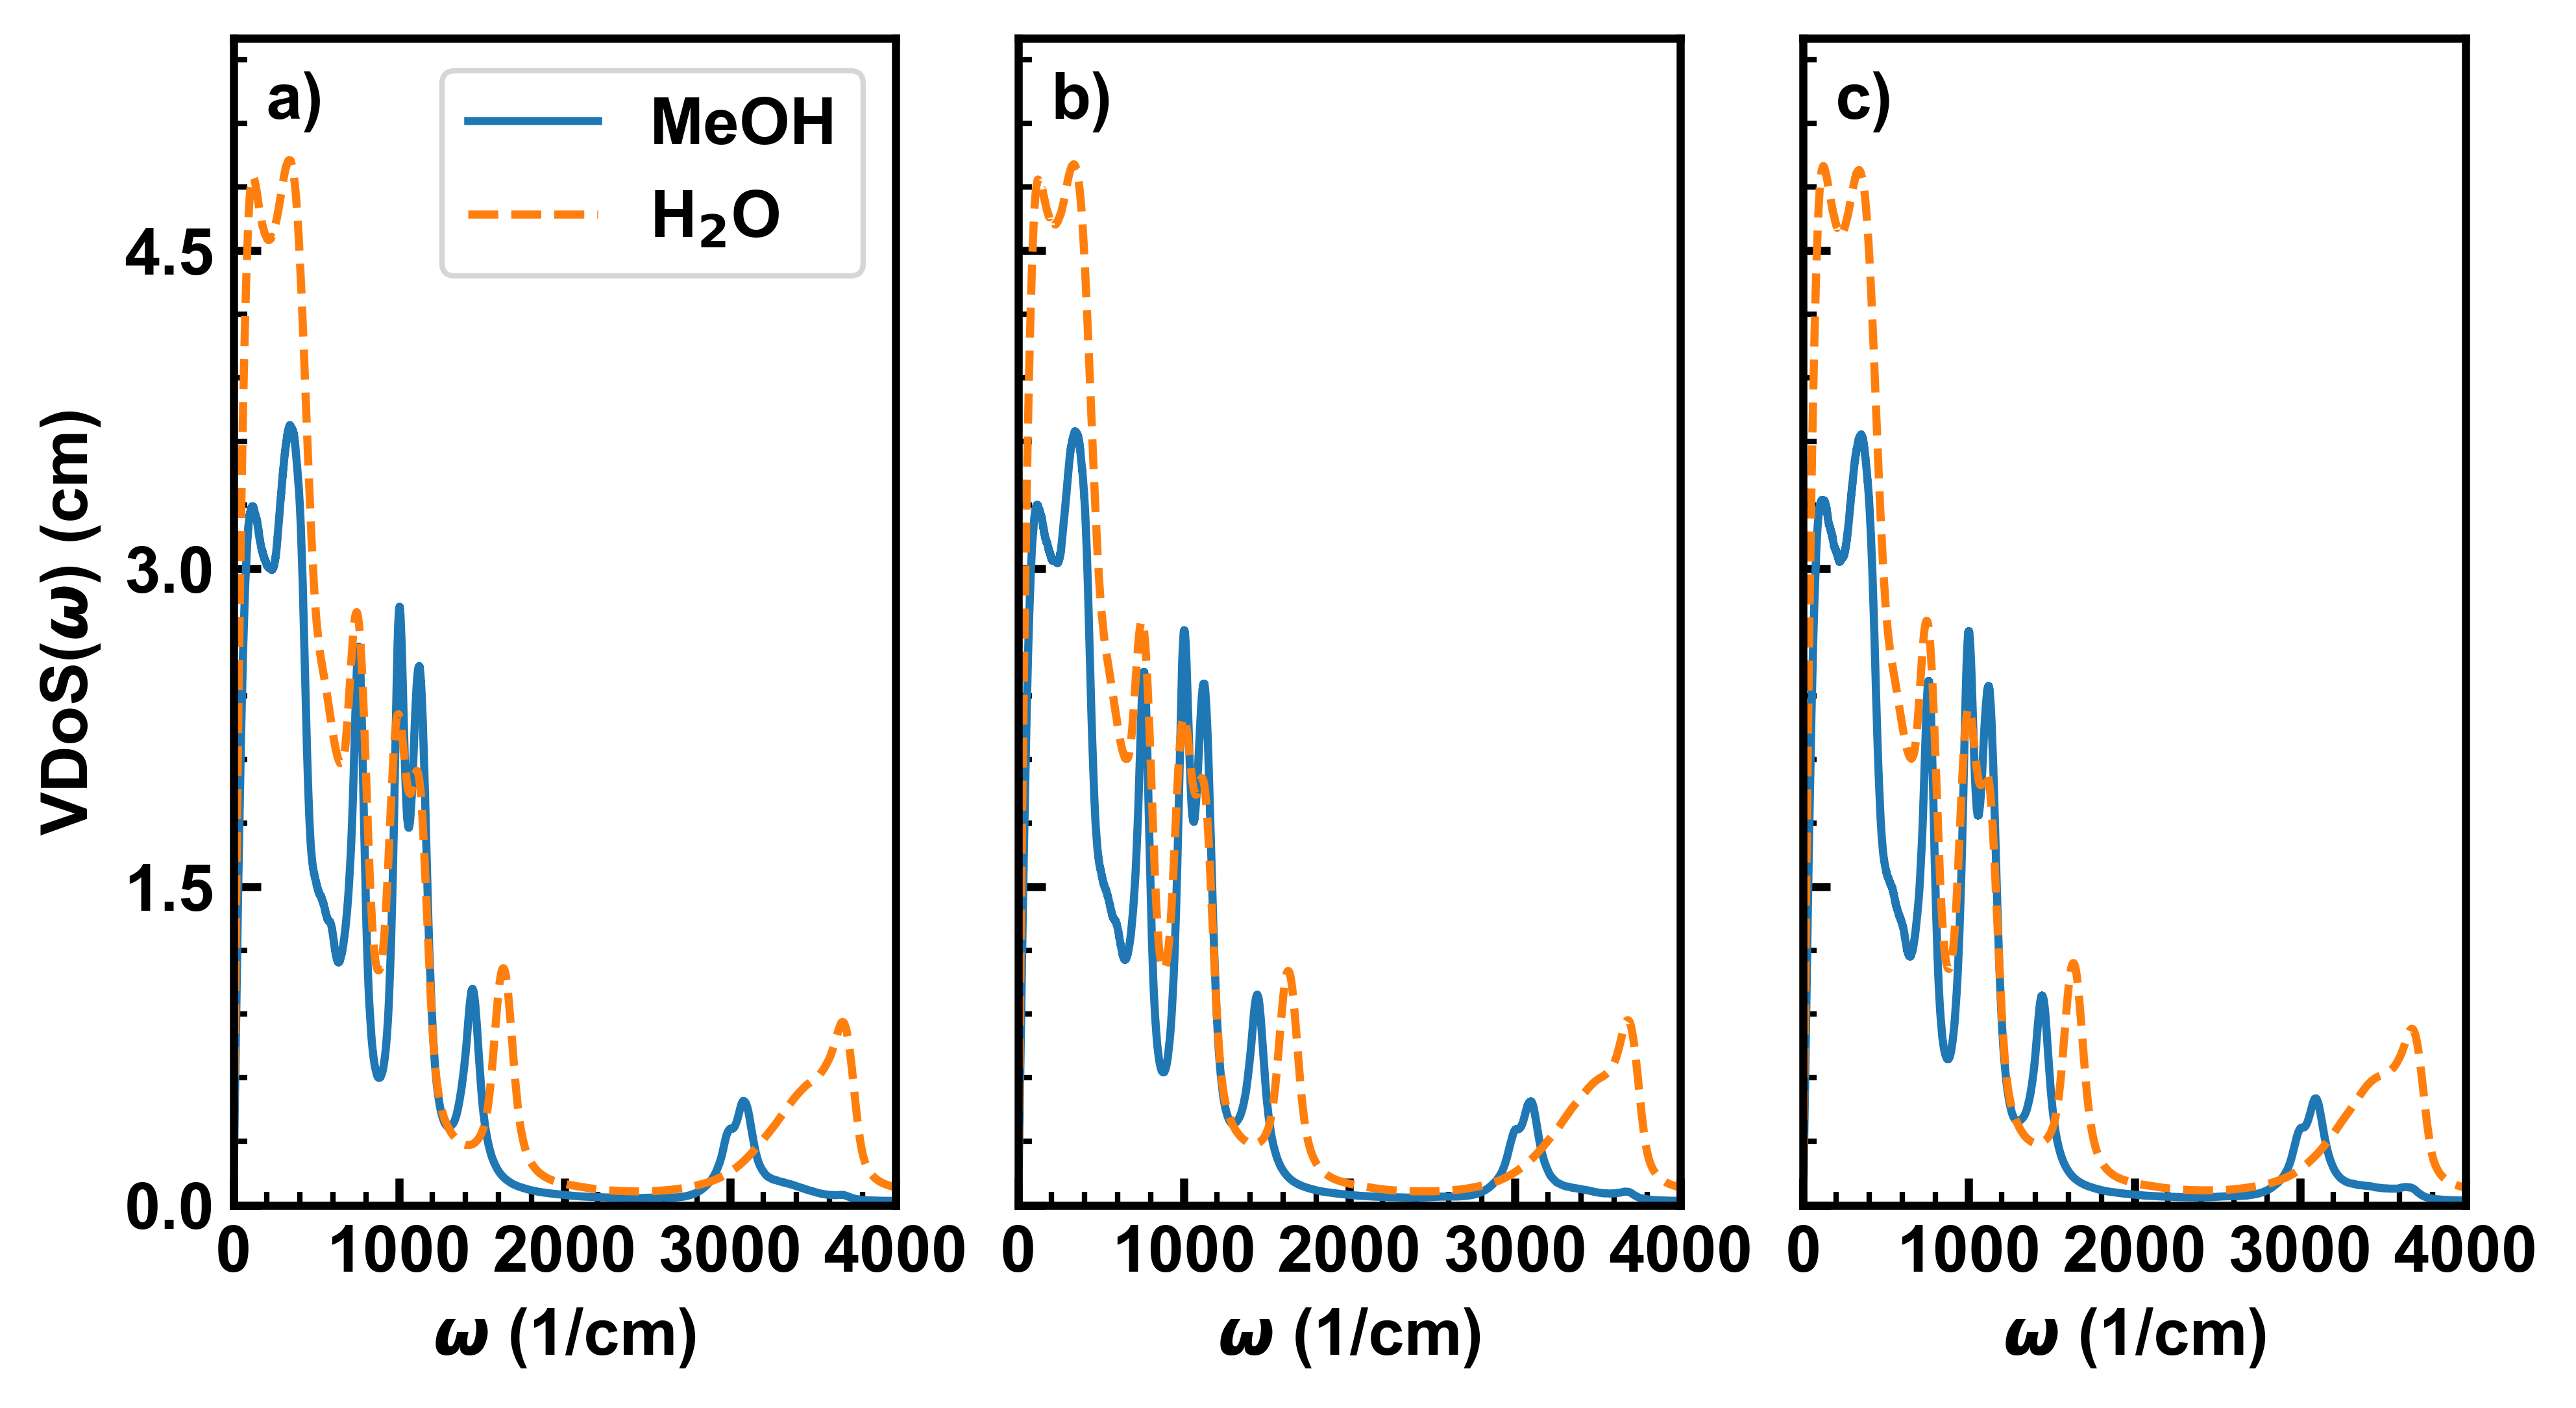

In [16]:

fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')

plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/all/sv.csv", colors, decomposed=False, label = "MeOH", color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../wat-39/pureSi/373/vdos/all/sv.csv", colors, decomposed=False, label = "H$_2$O", color = colors[1], filter = True, linestyle="dashed")


plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../wat-39/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1], filter = True, linestyle="dashed")


plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["c)"] , "../wat-39/st9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1], filter = True, linestyle="dashed")


#fig.legend(loc = "outside upper center", ncols = 2, columnspacing = 0.6, handletextpad=0.2)

axs["a)"].legend()


axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

'''

axs["a)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["a)"].transAxes
        )


axs["a)"].text(
        0.65, 0.75,
        r'Si-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["a)"].transAxes
        )




axs["b)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )


axs["b)"].text(
        0.65, 0.75,
        r'Sn9-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )



axs["c)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )


axs["c)"].text(
        0.65, 0.75,
        r'SnOH9-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

'''


label_mosaic_subplot(axs)



for key, ax in axs.items():
    ax.set_ylim(0.0, 5.5)
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

pass


save_figure(fig, "water-methanol_vdos")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


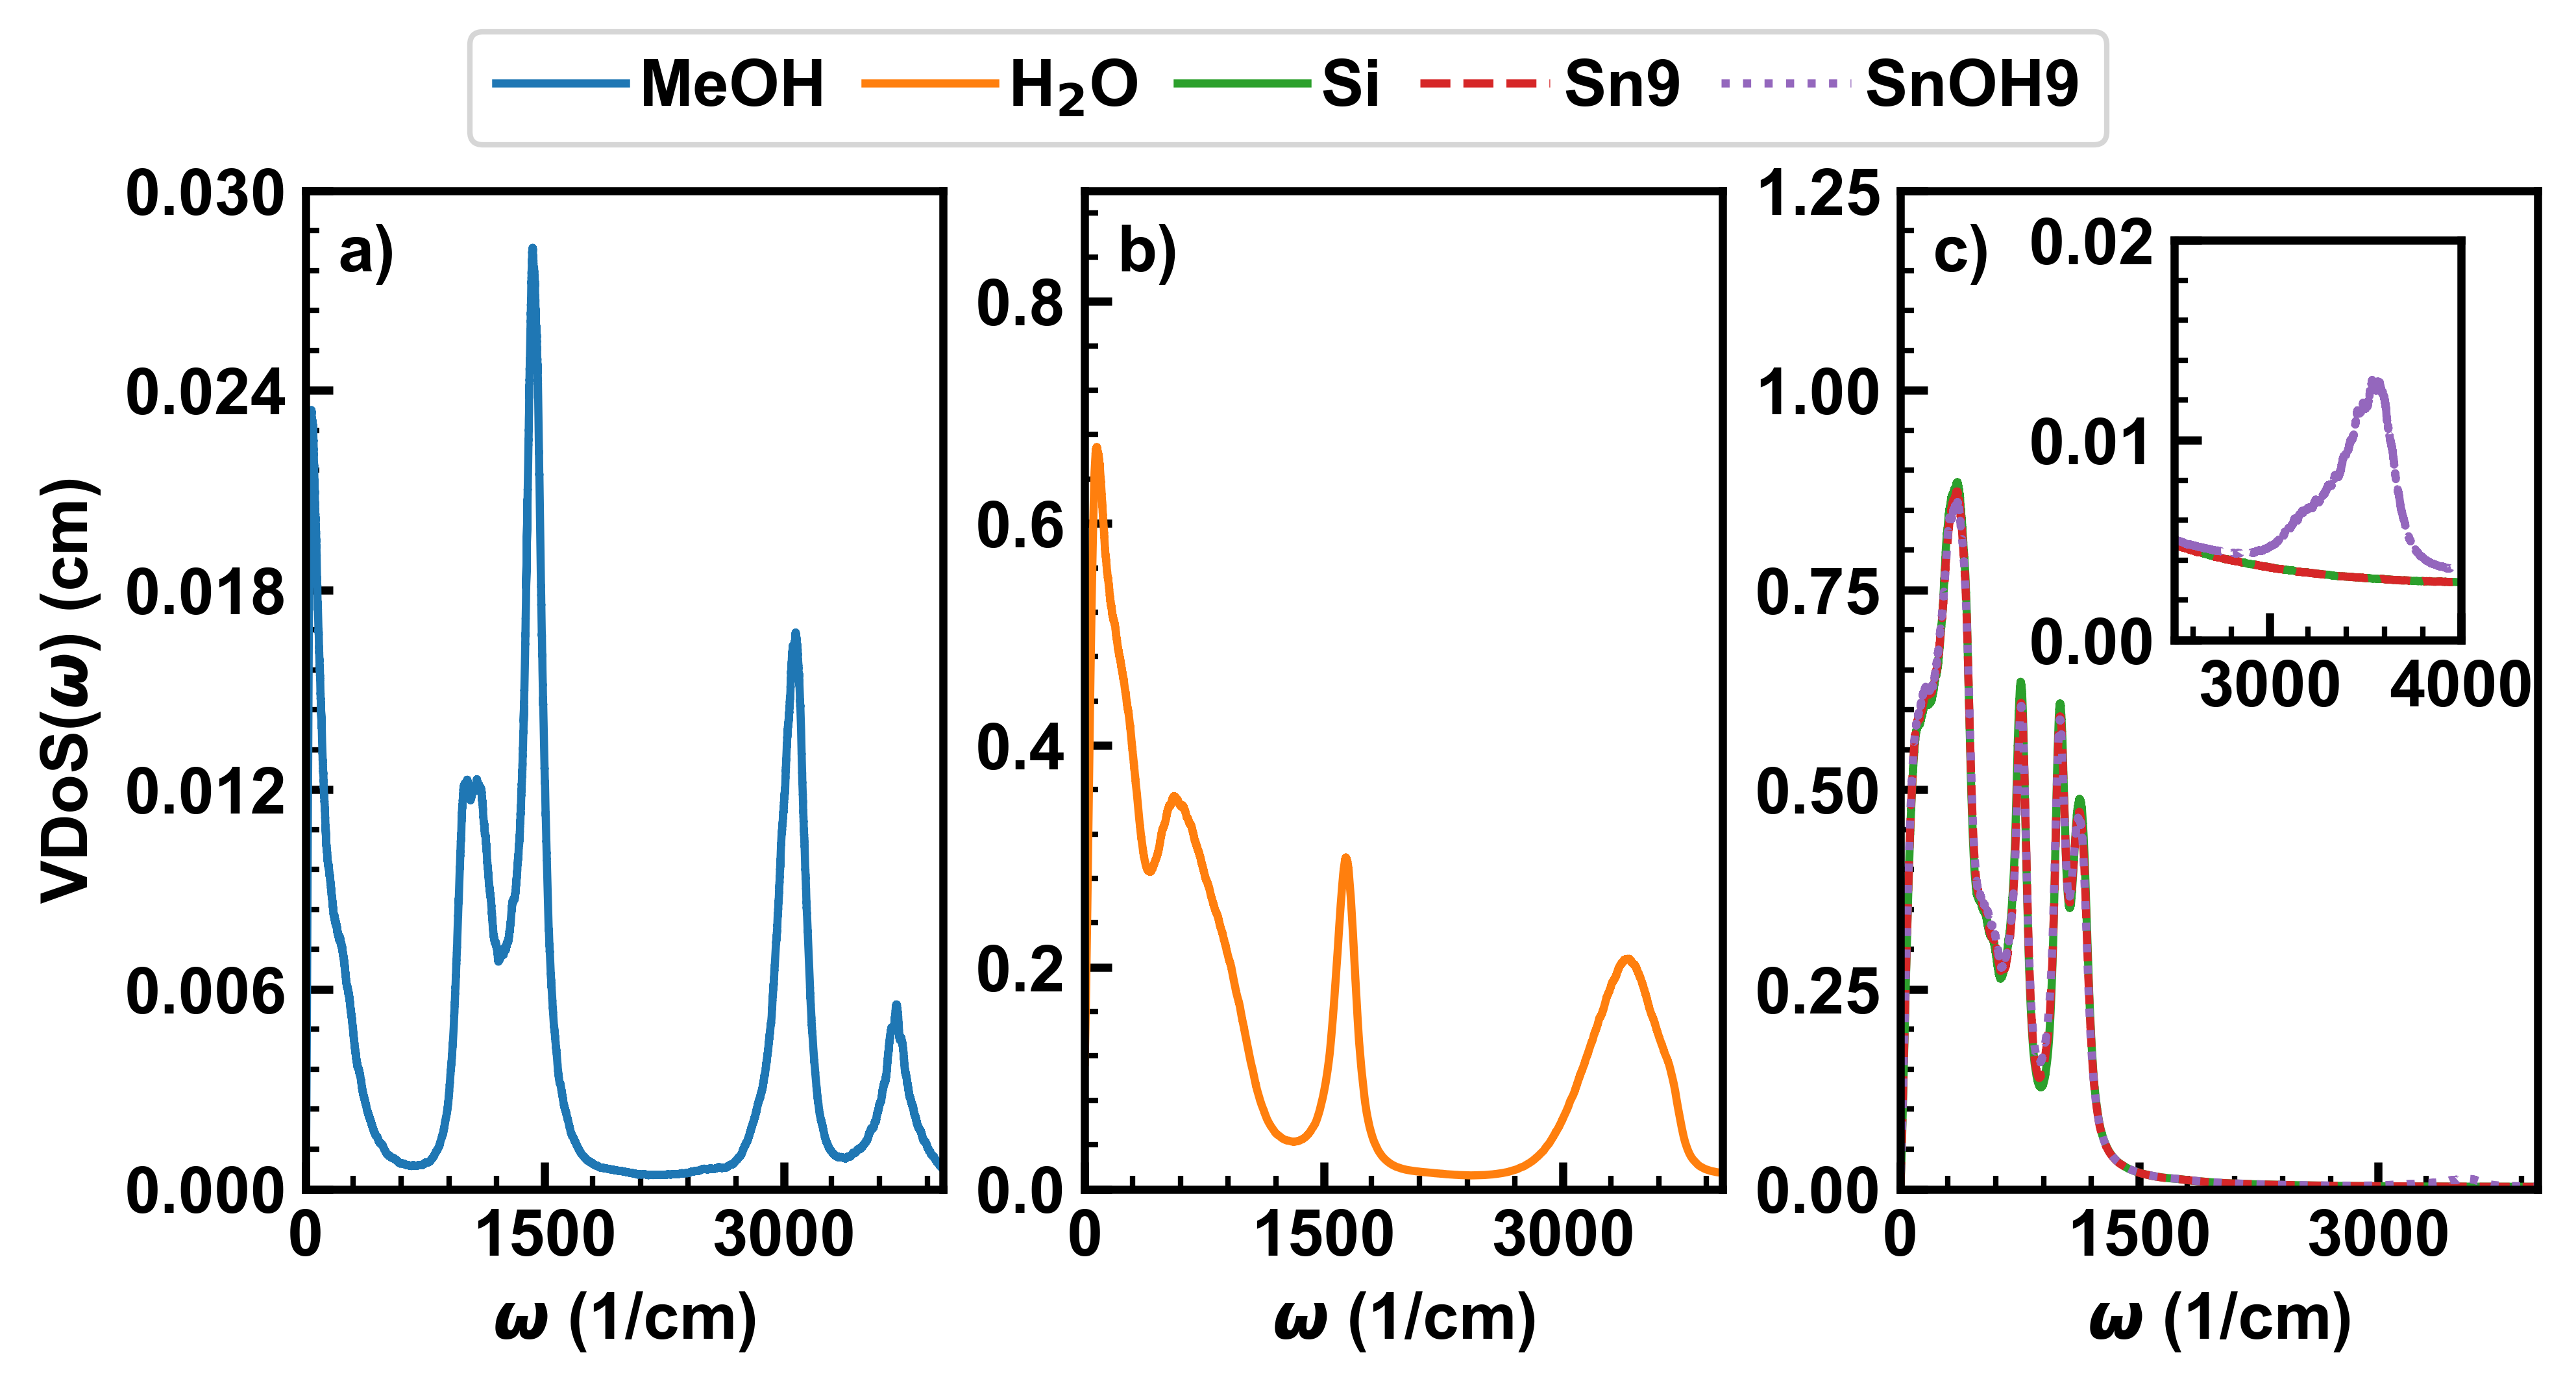

In [17]:

fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')

plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "MeOH", color = colors[0], normalize = 1, filter = True)
plot_2pt(axs["b)"] , "../solvents/wat-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "H$_2$O", color = colors[1], normalize = 1, filter = True)

plot_2pt(axs["c)"] , "../zeolites/pureSi/vdos/sv.csv", colors, decomposed=False, label = "Si", color = colors[2], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["c)"] , "../zeolites/t9/vdos/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[3], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["c)"] , "../zeolites/st9/vdos/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[4], normalize = 1, filter = True, linestyle="dotted")



"""
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0])
plot_2pt(axs["b)"] , "../wat-39/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1])


plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0])
plot_2pt(axs["c)"] , "../wat-39/st9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1])
"""
fig.legend(loc = "outside upper center", ncols = 5, columnspacing = 0.6, handletextpad=0.2)


axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

#axs["c)"].set_ylabel(r"VDoS($\omega$) (cm)")

label_mosaic_subplot(axs)


axs["a)"].set_ylim((0,0.03))
axs["b)"].set_ylim((0,0.9))
axs["c)"].set_ylim((0,1.25))

for key, ax in axs.items():
    #ax.set_ylim(0.0, 6.0)
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 3)



axs["c)"].set_xlabel(r"$\omega$ (1/cm)")


axins = axs["c)"].inset_axes([0.43, 0.55, 0.45, 0.4])
plot_2pt(axins , "../zeolites/pureSi/vdos/sv.csv", colors, decomposed=False, color = colors[2], filter = True, linestyle="solid")
plot_2pt(axins , "../zeolites/t9/vdos/sv.csv", colors, decomposed=False,  color = colors[3], filter = True, linestyle="dashed")
plot_2pt(axins , "../zeolites/st9/vdos/sv.csv", colors, decomposed=False, color = colors[4], filter = True, linestyle="dashdot")
axins.set_xlim(2500, 4000)
axins.set_ylim(0.0, 0.02)
#set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)

save_figure(fig, "pure-components_vdos")
pass

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


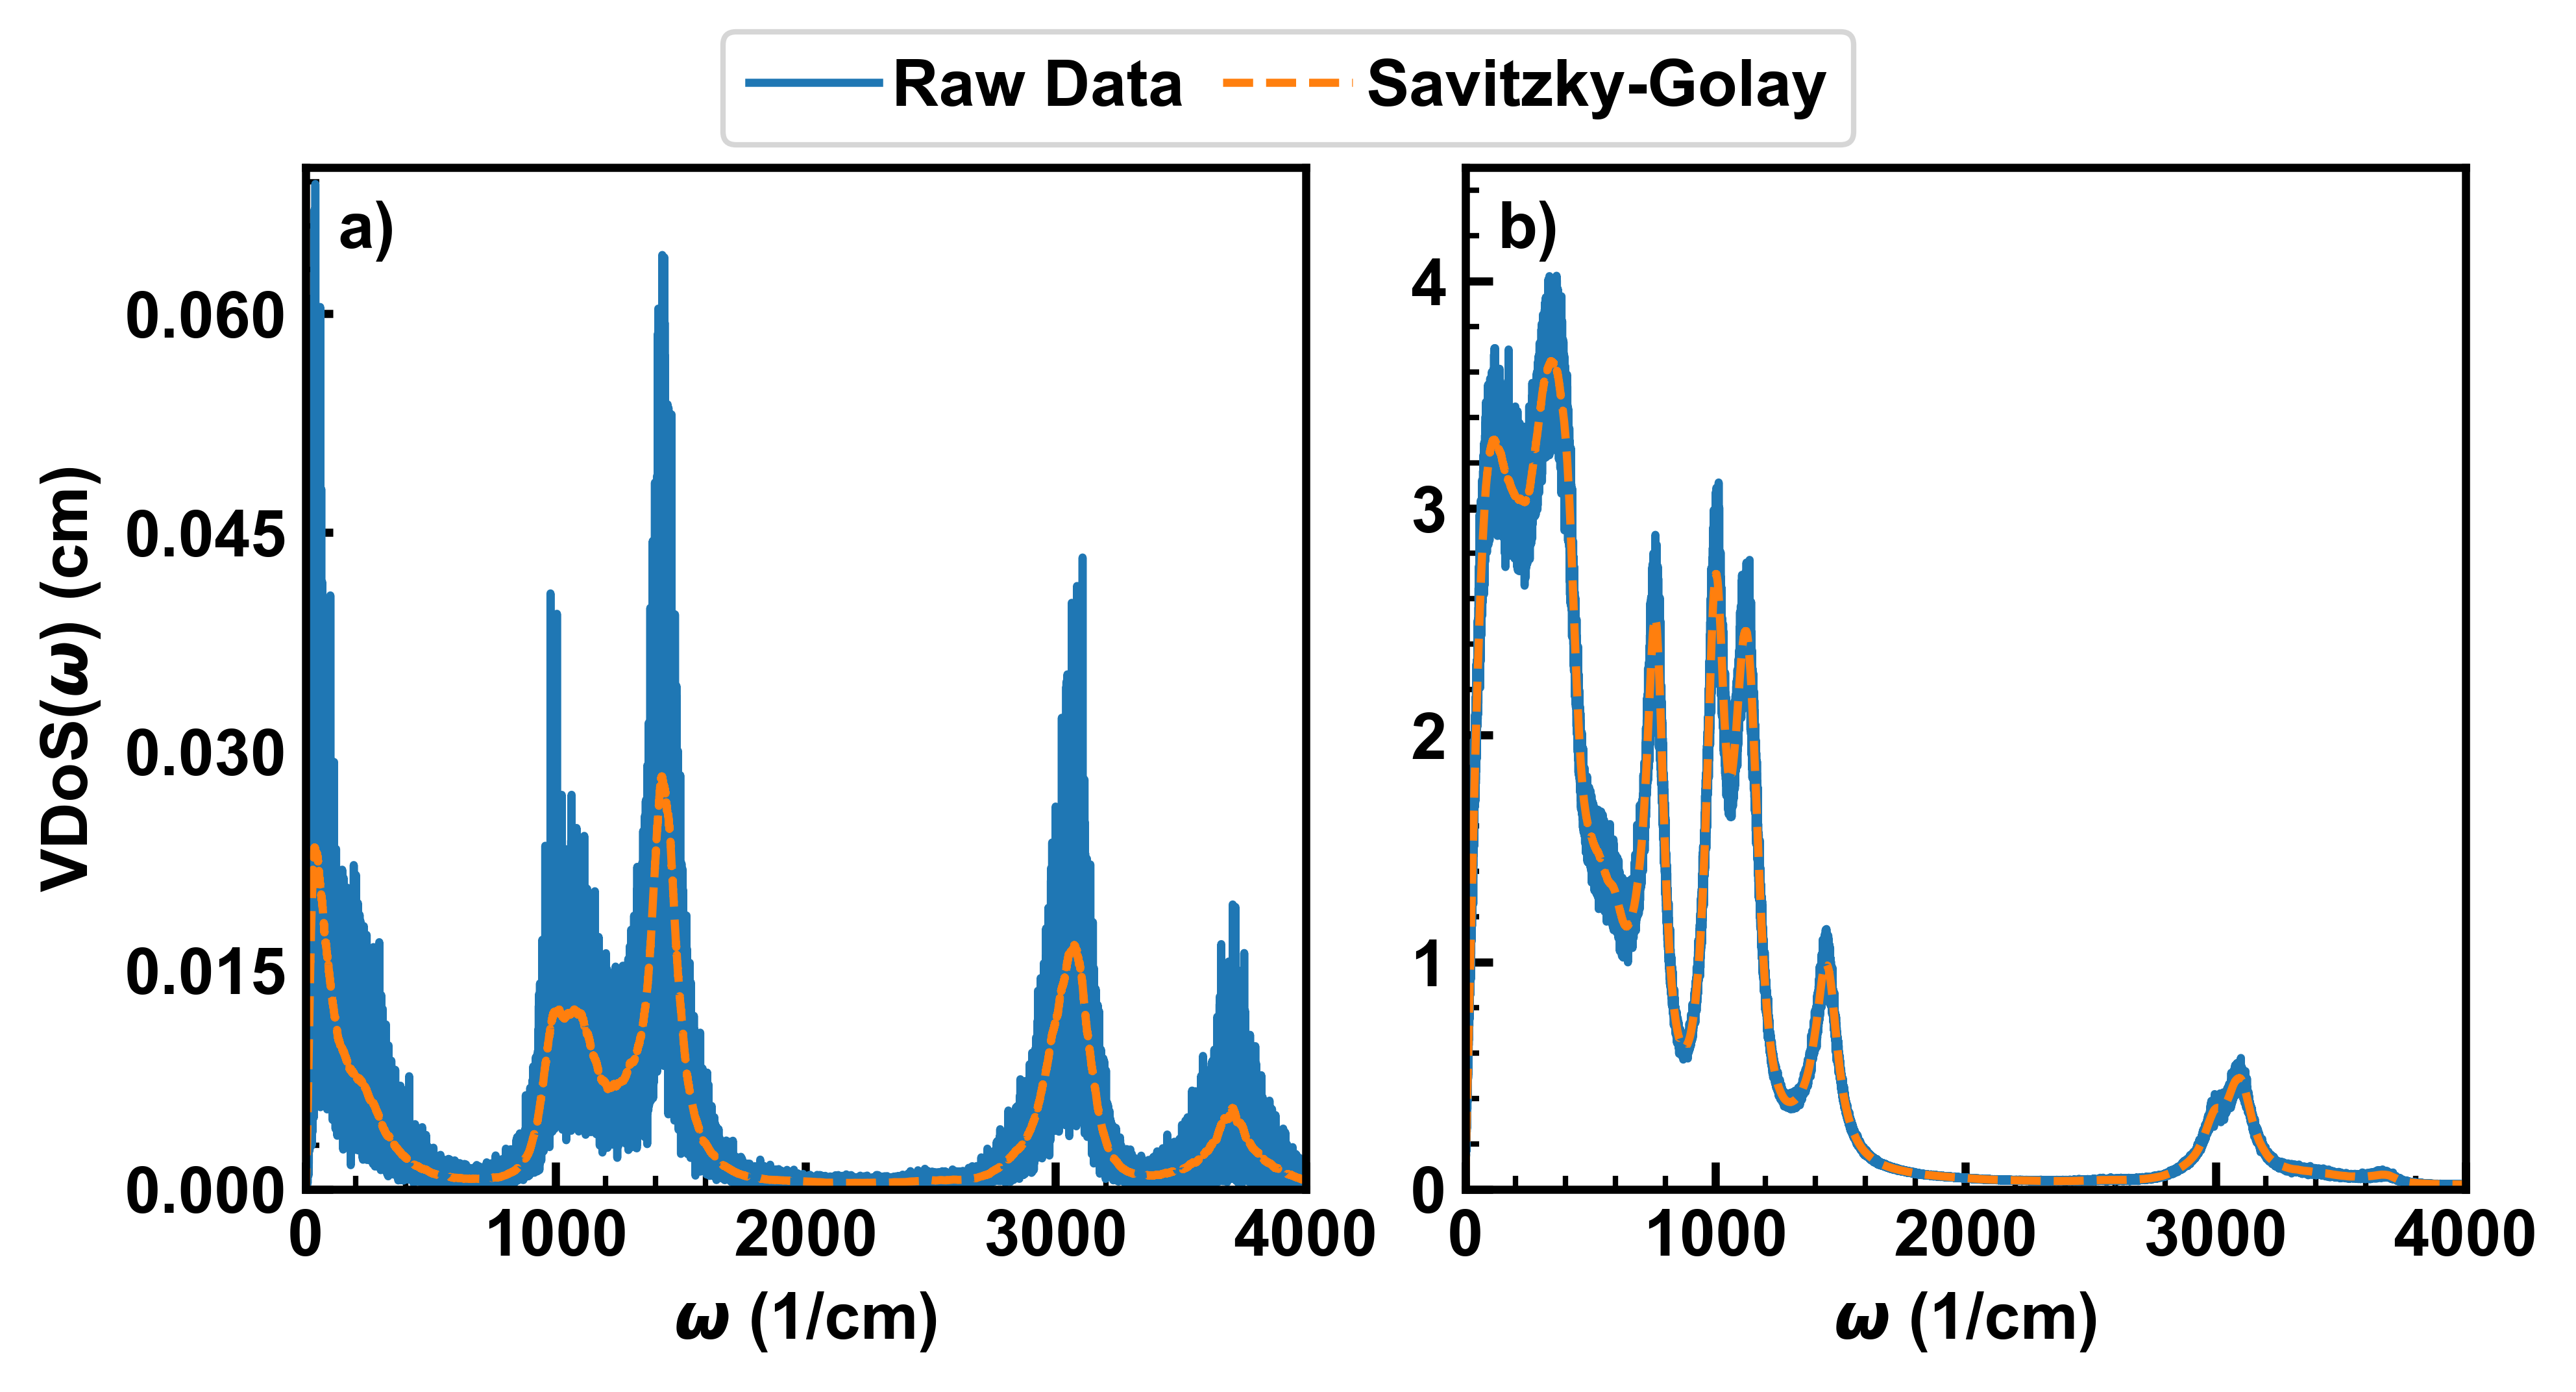

In [18]:

fig, axs = plt.subplot_mosaic([["a)", "b)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')

plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "Raw Data", color = colors[0], normalize = 1, filter = False, filter_window=100, linestyle="solid")
plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "Savitzky-Golay", color = colors[1], normalize = 1, filter = True, filter_window=1000, linestyle="dashed")


plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0], normalize = 1, filter = False, filter_window=100, linestyle="solid")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1], normalize = 1, filter = True, filter_window=1000, linestyle="dashed")



fig.legend(loc = "outside upper center", ncols = 5, columnspacing = 0.6, handletextpad=0.2)
#axs["a)"].legend()

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

axs['a)'].set_ylim(0.0, 0.07)
axs['b)'].set_ylim(0.0, 4.5)

for key, ax in axs.items():
    
    ax.set_xlim(0, 4000)
    #ax.set_xlabel(r"$\nu$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)



axs["a)"].set_xlabel(r"$\omega$ (1/cm)")
axs["b)"].set_xlabel(r"$\omega$ (1/cm)")
label_mosaic_subplot(axs)

save_figure(fig, "filter-comparison")
pass



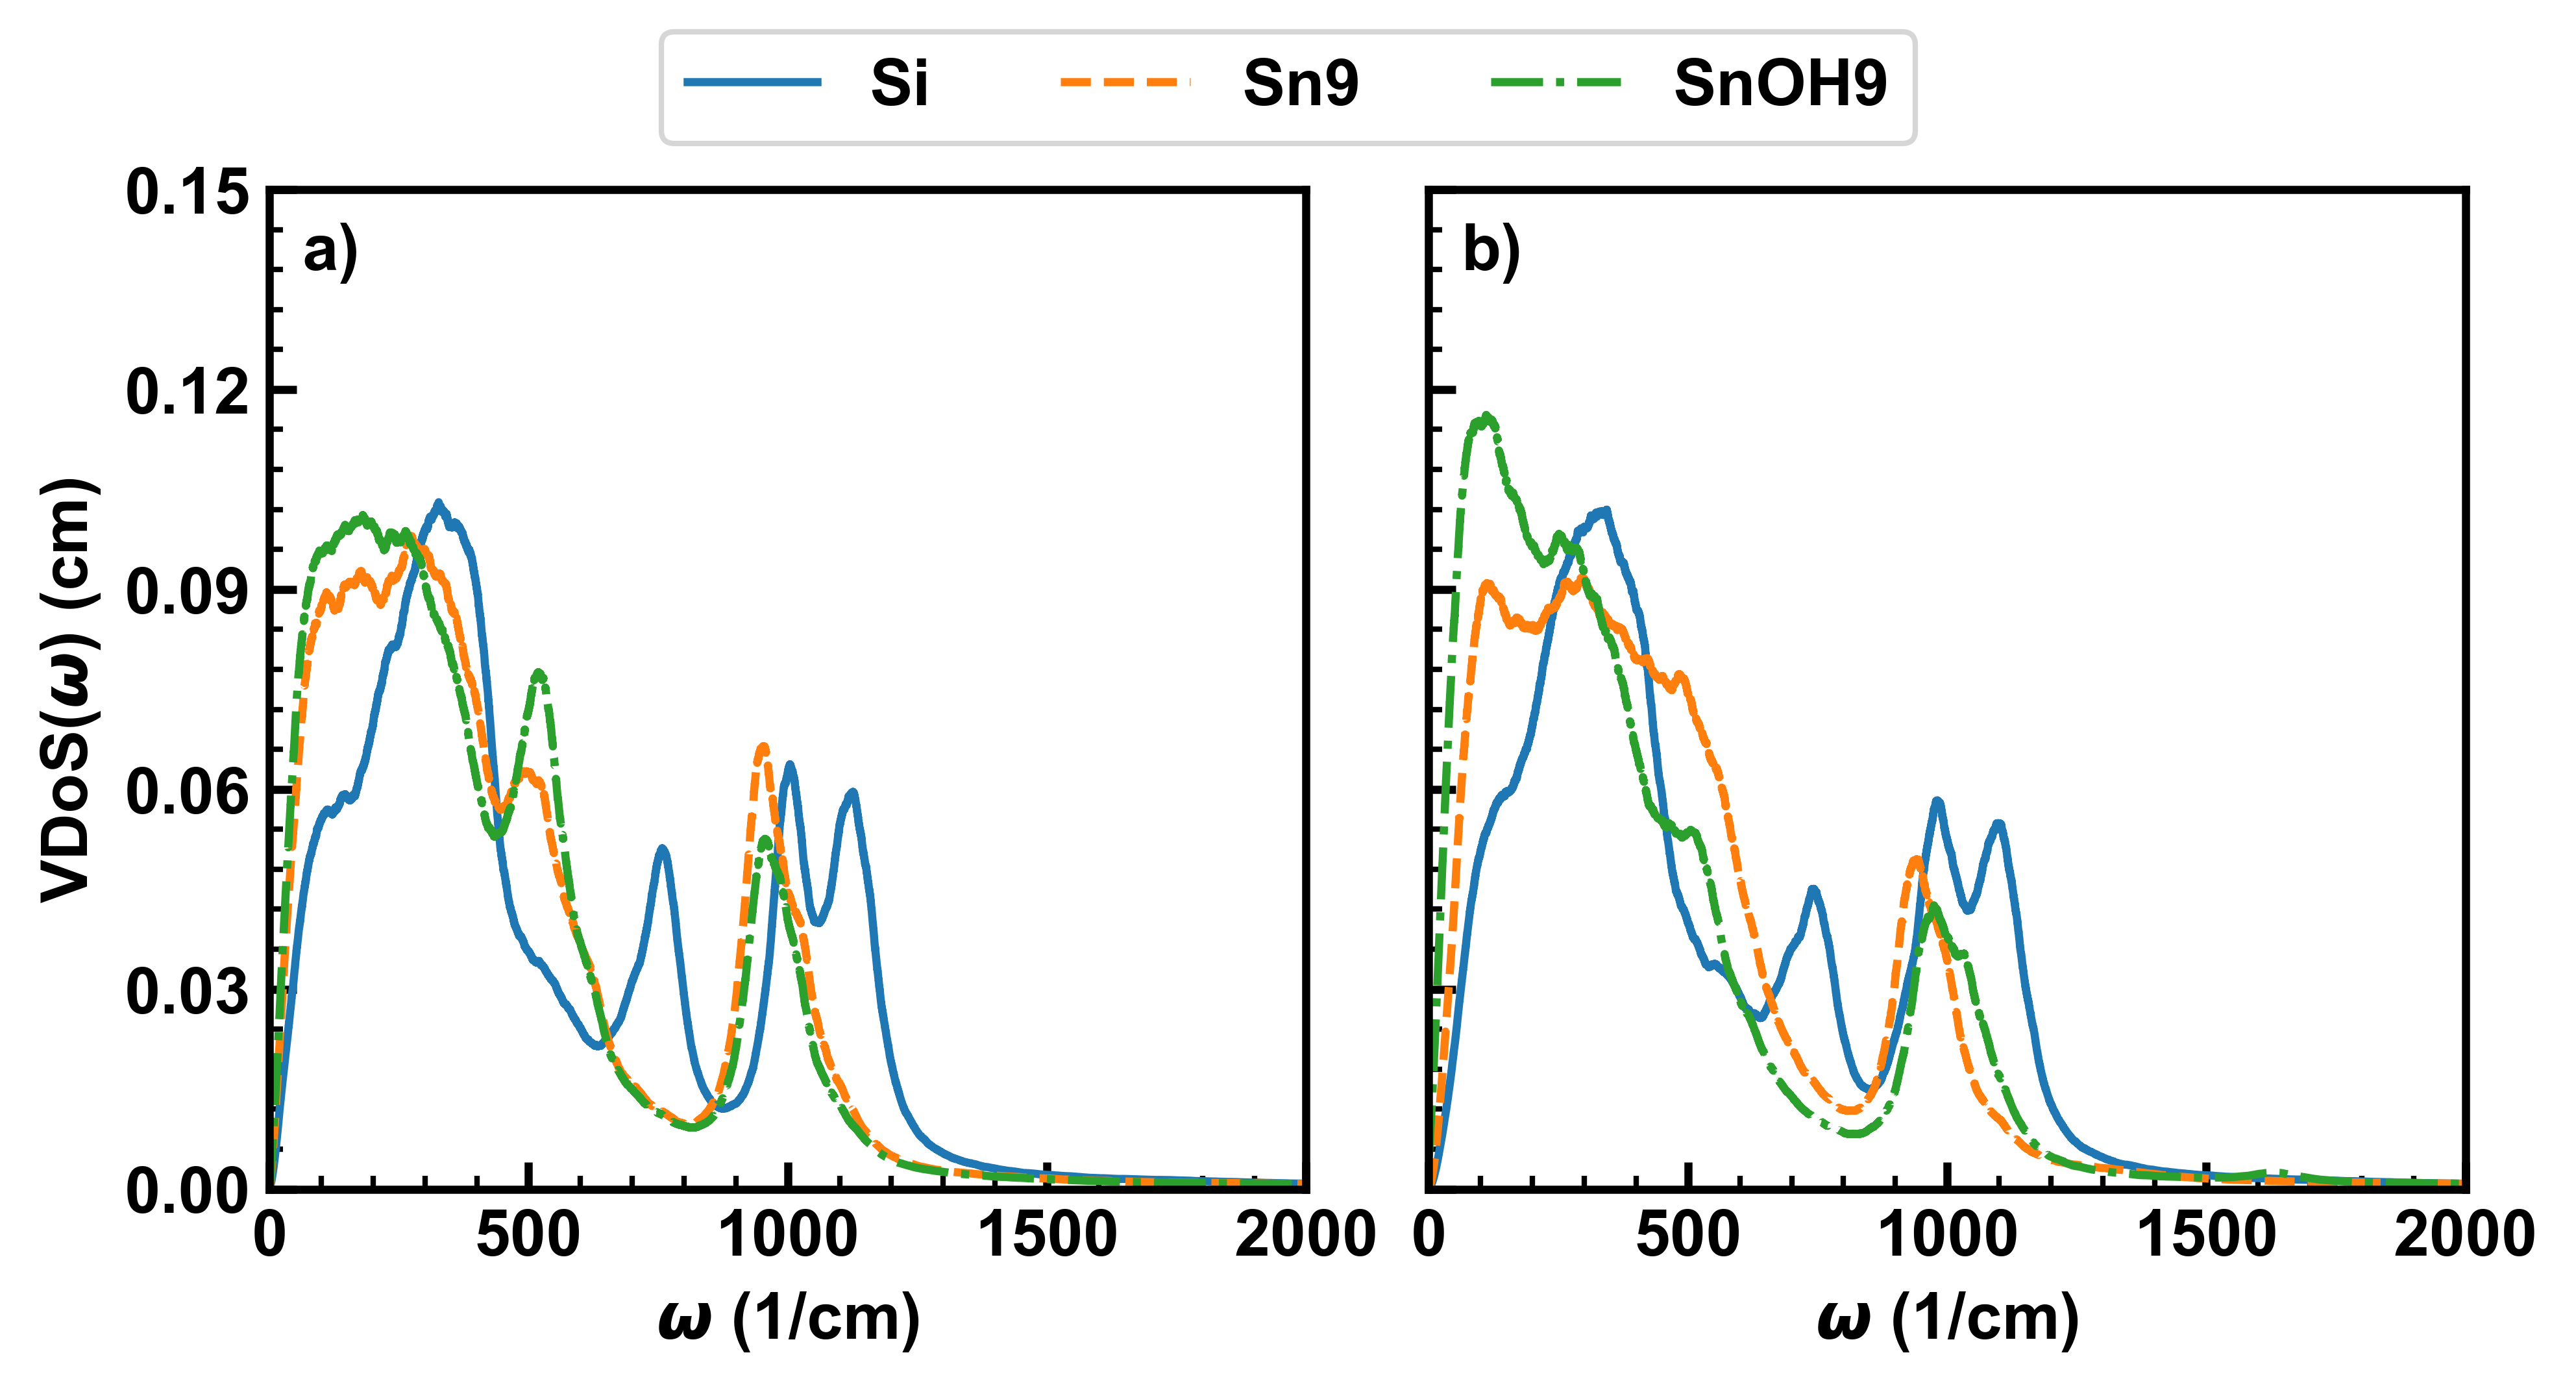

In [8]:



fig, axs = plt.subplot_mosaic([["a)", "b)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')


plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/si-t9/sv.csv", colors, decomposed=False, label = "Si", color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/t9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["a)"] , "../meoh-9/st9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")

plot_2pt(axs["b)"] , "../wat-39/pureSi/373/vdos/si-t9/sv.csv", colors, decomposed=False, label = None, color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../wat-39/t9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = None, color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["b)"] , "../wat-39/st9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = None, color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")


for key, ax in axs.items():
    
    ax.set_xlim(0, 2000)
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)


axs['a)'].set_ylim(0.0, 0.15)

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

axs["a)"].set_xlabel(r"$\omega$ (1/cm)")
axs["b)"].set_xlabel(r"$\omega$ (1/cm)")
label_mosaic_subplot(axs)

fig.legend(loc = "outside upper center", ncols = 3, )#columnspacing = 0.6, handletextpad=0.2)


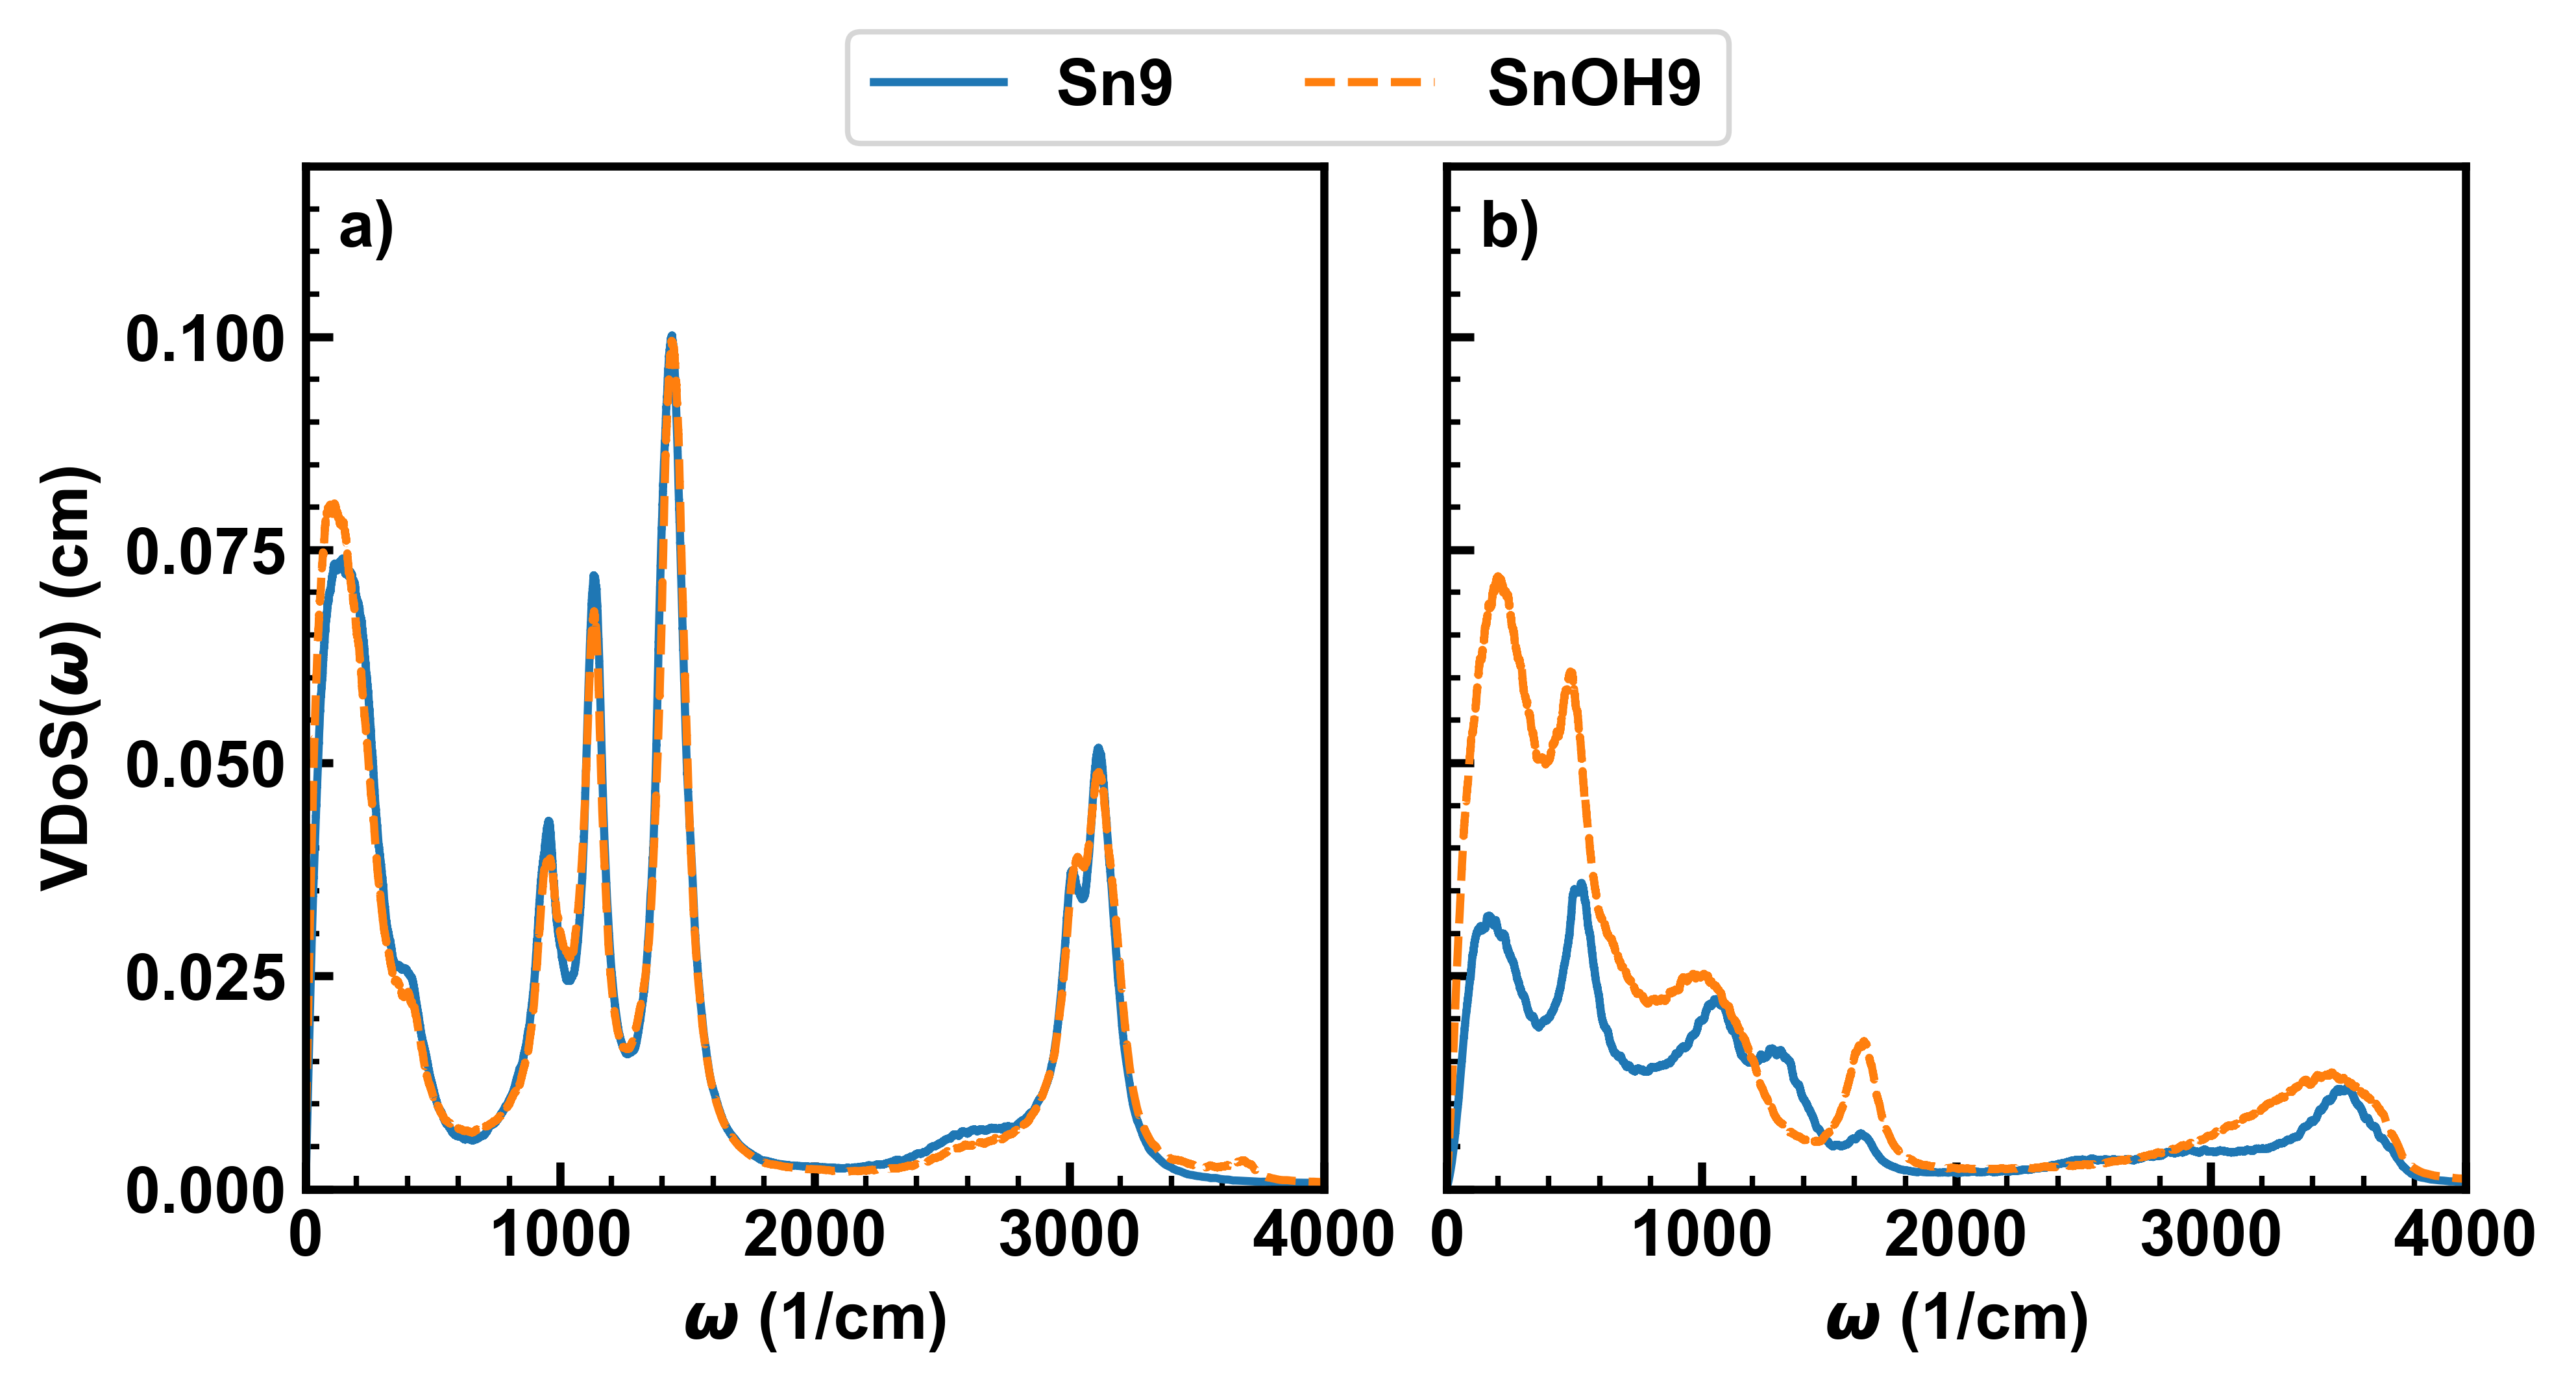

In [12]:

fig, axs = plt.subplot_mosaic([["a)", "b)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')


plot_2pt(axs["a)"] , "../meoh-9/t9/373/vdos/ads/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/st9/373/vdos/ads/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[1], normalize = 1, filter = True, linestyle = "dashed")

plot_2pt(axs["b)"] , "../wat-39/t9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../wat-39/st9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[1], normalize = 1, filter = True, linestyle = "dashed")


for key, ax in axs.items():
    ax.set_xlabel(r"$\omega$ (1/cm)")
    ax.set_xlim(0, 4000)
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs['a)'].set_ylim(0.0, 0.12)
axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")
label_mosaic_subplot(axs)

fig.legend(loc = "outside upper center", ncols = 3, )#columnspacing = 0.6, handletextpad=0.2)